<a href="https://colab.research.google.com/github/Gumagonza1/anchor/blob/master/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Celda 0: Instalación (Ejecutar solo si es necesario) ---
!pip install pandas numpy scikit-learn matplotlib statsmodels requests alpha-vantage ccxt pytrends tensorflow keras-tuner ipython pandas-ta

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.5/627.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 50.9 MB/s eta 0:00:00
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=6b5336fb9654feb678b520443aaecbf20e4a6368889387d5a53eb39c45e95feb
  Stored in directory: /home/deck/.cache/pip/wheels/fd/ed/18/2a12fd1b7906c63efca6accb351929f

In [ ]:

# --- Bloque 1: Importaciones y Setup Inicial ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
import warnings
import time
import datetime
import os
import requests
# from collections import defaultdict # Ya no se necesita
from IPython.display import display
# import pandas_ta as ta # Ya no se necesita

os.environ['CRYPTOGRAPHY_OPENSSL_NO_LEGACY'] = '1'

# --- Alpha Vantage Import ---
try:
    from alpha_vantage.timeseries import TimeSeries
    # from alpha_vantage.cryptocurrencies import CryptoCurrencies # No usada directamente ahora
    # from alpha_vantage.foreignexchange import ForeignExchange # No usada directamente ahora
    from alpha_vantage.techindicators import TechIndicators # <-- Necesaria para MACD/RSI
    # from alpha_vantage.econindicators import EconIndicators # Comentada - Probablemente falla
    alpha_vantage_installed = True
    tech_indicators_available = True
except ImportError as e:
    print(f"Error Fatal: Falló importación de alpha-vantage ({e}). Verifica instalación y reinicia.")
    alpha_vantage_installed = False
    tech_indicators_available = False # Asumir que falla si el base falla

# --- CCXT Import ---
try: import ccxt; ccxt_installed = True
except ImportError: print("Error Fatal: CCXT no instalado."); ccxt_installed = False

# --- Pytrends Import ---
try: from pytrends.request import TrendReq; pytrends_installed = True
except ImportError: print("Advertencia: pytrends no instalado."); pytrends_installed = False; TrendReq = None

# --- TensorFlow / Keras Imports ---
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout # Añadido GRU
    from tensorflow.keras.optimizers import Adam, Nadam # Añadido Nadam
    from tensorflow.keras.callbacks import EarlyStopping
    import keras_tuner as kt
    keras_installed = True
except ImportError: print("Error Fatal: TensorFlow/Keras/KerasTuner no instalado."); keras_installed = False

if not (alpha_vantage_installed and ccxt_installed and keras_installed):
     print("Error: Faltan librerías clave. Saliendo."); import os; os._exit(1)

warnings.filterwarnings("ignore")
print("Bloque 1 (Importaciones) completado.")

Bloque 1 (Importaciones) completado.


In [ ]:

# --- Bloque 2: Configuración General ---
AV_API_KEY = "VCZOTT2BZSYUVCXT" # !!! REEMPLAZA ESTO !!!

if AV_API_KEY == "TU_ALPHA_VANTAGE_API_KEY" or not AV_API_KEY:
     print("Error Crítico: Falta clave API de Alpha Vantage."); import os; os._exit(1)

start_date_str = "2017-01-01"
end_date_str = "2025-05-03"
start_date_dt = pd.to_datetime(start_date_str)
end_date_dt = pd.to_datetime(end_date_str)

forecast_steps = 30
n_steps = 60
resample_freq = 'D'

# --- Alpha Vantage Symbols (Solo TimeSeries ahora) ---
av_symbols_ts = {
    'SPY': {'type': 'stock', 'col_name': 'SP500_Close'},
    'QQQ': {'type': 'stock', 'col_name': 'Nasdaq_Close'},
    'GLD': {'type': 'stock', 'col_name': 'Precio_Oro_USD'},
    'VXX': {'type': 'stock', 'col_name': 'VIX_Close'},
    'UUP': {'type': 'stock', 'col_name': 'DXY_Close'},
}
# Símbolo base para indicadores técnicos AV
av_techindicator_symbol = 'BTC'
av_techindicator_market = 'USD' # Requerido por algunos indicadores crypto de AV

# Nombres definidos explícitamente
btc_col_name = 'Precio_BTC_USD'     # Vía CCXT
wti_col_name = 'WTI_Price'         # Vía requests
fedfunds_col_name = 'FEDFUNDS_Rate' # Vía requests
cpi_col_name = 'CPI_USA'             # Vía requests
gold_col_name = 'Precio_Oro_USD'     # Vía AV GLD
vix_col_name = 'VIX_Close'           # Vía AV VXX
dxy_col_name = 'DXY_Close'           # Vía AV UUP
trends_col_name_base = "Trends"      # Base para Pytrends
# Para Indicadores Técnicos de AV
macd_col_name = 'BTC_MACD'
macd_signal_col_name = 'BTC_MACD_Signal'
macd_hist_col_name = 'BTC_MACD_Hist'
rsi_col_name = 'BTC_RSI'

# --- CCXT Symbols ---
ticker_btc_exchange = 'BTC-USD'
exchange_id_btc = 'coinbase'


# --- Parámetros Modelo/Entrenamiento (Tuner ajustado) ---
n_epochs_per_trial = 100
patience_early_stopping = 10
# mc_samples eliminado
tuner_max_trials = 60 # Aumentado
tuner_executions_per_trial = 2 # Aumentado

# --- Delays API ---
AV_API_DELAY_SECONDS = 2.0
CCXT_DELAY_SECONDS = 0.5

print("Bloque 2 (Configuración) completado: +VIX/DXY/TechInd, -M2/Sentiment, Tuner ajustado.")

Bloque 2 (Configuración) completado: +VIX/DXY/TechInd, -M2/Sentiment, Tuner ajustado.


In [ ]:

# --- Bloque 3: Definición de Funciones Auxiliares ---
# (fetch_exchange_ohlcv_daily permanece igual)

def get_google_trends(keywords_list, start_date_req, end_date_req): # Acepta fechas inicio/fin para la solicitud
    global TrendReq, pytrends_installed, resample_freq, start_date_dt, end_date_dt, trends_col_name_base
    if TrendReq is None or not pytrends_installed:
         print("  Pytrends no disponible, saltando Google Trends.")
         return None
    # Limitar a 5 keywords por llamada
    if len(keywords_list) > 5:
        print(f"  Advertencia: Demasiados keywords ({len(keywords_list)}) para Trends. Usando los primeros 5.")
        keywords_list = keywords_list[:5]
    if not keywords_list:
         print("  Advertencia: Lista de keywords de Google Trends vacía.")
         return None

    keyword_str = ', '.join(keywords_list)
    # Indicar el rango solicitado a la API
    print(f"Descargando Google Trends ({start_date_req} a {end_date_req}) para: '{keyword_str}'...")
    try:
        # Usar las fechas específicas para el timeframe de la API
        timeframe_trends = f'{start_date_req} {end_date_req}'
        time.sleep(10) # Mantener el delay alto por si acaso
        pytrends_req = TrendReq(hl='es-MX', tz=360)
        pytrends_req.build_payload(keywords_list, cat=0, timeframe=timeframe_trends, geo='', gprop='')
        trends_df_raw = pytrends_req.interest_over_time()

        if trends_df_raw.empty:
            print(f"  No se encontraron datos de Google Trends para los keywords en el rango solicitado.")
            return None
        if 'isPartial' in trends_df_raw.columns:
            trends_df_raw = trends_df_raw.drop(columns=['isPartial'])

        keywords_found = [kw for kw in keywords_list if kw in trends_df_raw.columns]
        if not keywords_found:
            print(f"  Ninguno de los keywords solicitados se encontró en la respuesta de Trends.")
            return None

        print(f"  Keywords encontrados en Trends: {keywords_found}")
        trends_df_processed = trends_df_raw[keywords_found].copy()
        trends_df_processed.index = pd.to_datetime(trends_df_processed.index)

        # Remuestrear a diario y rellenar
        trends_df_resampled = trends_df_processed.resample(resample_freq).interpolate(method='linear').ffill().bfill()

        # Filtrar usando las fechas GLOBALES del script (start_date_dt, end_date_dt)
        # para asegurar alineación final, aunque la descarga haya sido más corta.
        trends_df_filtered = trends_df_resampled[(trends_df_resampled.index >= start_date_dt) & (trends_df_resampled.index <= end_date_dt)]

        # Crear nombres de columna finales y renombrar
        rename_map = {}; final_cols = []
        for keyword in keywords_found:
            col_name = f"{trends_col_name_base}_{keyword.lower().replace('&', 'and').replace(' ', '_').replace('%', 'pct')}"
            rename_map[keyword] = col_name; final_cols.append(col_name)

        trends_df_final = trends_df_filtered.rename(columns=rename_map)

        if not trends_df_final.empty:
            # Puede que la última fecha sea anterior a end_date_str si el rango solicitado fue menor
            print(f"  Google Trends procesados OK. Última fecha encontrada: {trends_df_final.index.max().strftime('%Y-%m-%d')}")
            # Devolver DataFrame con columnas renombradas existentes
            return trends_df_final[[col for col in final_cols if col in trends_df_final.columns]]
        else:
            print(f"  Adv: Trends sin datos en rango final para keywords: {keywords_found}")
            return None

    except Exception as e:
        print(f"  No se pudo descargar o procesar Google Trends: {type(e).__name__} - {e}")
        return None

# --- Definición fetch_exchange_ohlcv_daily (Sin Cambios) ---
# ... (pegar aquí la función fetch_exchange_ohlcv_daily como estaba antes) ...
def fetch_exchange_ohlcv_daily(exchange_id, symbol, start_dt, end_dt, delay_seconds, col_name):
    global ccxt
    print(f"Descargando datos DIARIOS de {symbol} desde {exchange_id}...")
    try: exchange_class = getattr(ccxt, exchange_id); exchange = exchange_class({'enableRateLimit': True})
    except Exception as e: print(f"Error init CCXT: {e}"); return None
    since = int(start_dt.timestamp() * 1000); now = int(end_dt.timestamp() * 1000)
    limit = 1000; timeframe = '1d'; all_ohlcv = []
    while since < now:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
            if not ohlcv: break
            last_ts = ohlcv[-1][0]; all_ohlcv.extend(ohlcv); since = last_ts + 1
            time.sleep(max(exchange.rateLimit / 1000, 0.1) + delay_seconds)
        except ccxt.RateLimitExceeded as e: print("    CCXT Rate Limit..."); time.sleep(15)
        except Exception as e: print(f"    Error CCXT fetch {symbol}: {type(e).__name__}"); time.sleep(5); break
    if not all_ohlcv: print(f"Adv: No OHLCV {symbol}."); return None
    df = pd.DataFrame(all_ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms'); df = df.set_index('Timestamp').sort_index()
    df_daily = df[['Close']].copy(); df_daily.rename(columns={'Close': col_name}, inplace=True)
    df_daily = df_daily[(df_daily.index >= start_date_dt) & (df_daily.index <= end_date_dt)]
    if not df_daily.empty: print(f"  CCXT {symbol} OK. Última fecha: {df_daily.index.max().strftime('%Y-%m-%d')}")
    else: print(f"Adv: CCXT {symbol} sin datos en rango."); df_daily=None
    return df_daily


print("Bloque 3 (Funciones Auxiliares) definido/actualizado.")

Bloque 3 (Funciones Auxiliares) definido/actualizado.


In [ ]:
# --- Bloque 4: Extracción y Consolidación de Datos (CORRECCIÓN FINAL TI - SIN MARKET) ---

import pandas as pd
import numpy as np
import requests
import time
# from collections import defaultdict # No se usa
# Asegúrate que las funciones auxiliares y variables de config estén definidas en celdas anteriores

fetched_data_all = {} # Diccionario principal para datos finales
# av_temp_storage ya no es necesario si procesamos y guardamos directo en fetched_data_all

# --- Descarga Alpha Vantage ---
print(f"\n--- Iniciando descarga Alpha Vantage ---")
ts = None; cc_av = None; ti = None
av_ts_ok = False; av_cc_ok = False; av_ti_ok = False

if 'alpha_vantage_installed' in locals() and alpha_vantage_installed:
    try:
        if 'TimeSeries' in globals() and TimeSeries is not None:
            ts = TimeSeries(key=AV_API_KEY, output_format='pandas'); av_ts_ok = True
            print("  Cliente TimeSeries AV inicializado.")
        else: print("Advertencia: Clase TimeSeries no disponible.")

        if 'CryptoCurrencies' in globals() and CryptoCurrencies is not None:
            cc_av = CryptoCurrencies(key=AV_API_KEY, output_format='pandas'); av_cc_ok = True
            print("  Cliente CryptoCurrencies AV inicializado.")
        else: print("Advertencia: Clase CryptoCurrencies no disponible.")

        # Usar la bandera correcta de importación del Bloque 1
        if 'tech_indicators_module_available' in locals() and tech_indicators_module_available and 'TechIndicators' in globals() and TechIndicators is not None:
            ti = TechIndicators(key=AV_API_KEY, output_format='pandas'); av_ti_ok = True
            print("  Cliente TechIndicators AV inicializado.")
        else: print("Advertencia: TechIndicators no se instanciará.")

    except Exception as e: print(f"Error inicializando uno o más clientes AV: {e}")
else: print("Advertencia: Biblioteca alpha_vantage no instalada.")


# Bucle sobre símbolos configurados en av_symbols (para biblioteca AV)
if 'av_symbols' in locals() and av_symbols:
    for symbol_key, config in av_symbols.items(): # 'symbol_key' es BTC, SPY, etc.
        df_processed_from_lib = None # DataFrame procesado para este símbolo
        is_direct_request_type = False # Flag para tipos como 'commodity' que usan requests

        try:
            current_cols_expected = [v for k, v in config.items() if k.startswith('col_name')]
            print(f"Procesando AV Lib: {symbol_key} ({', '.join(current_cols_expected)})... Tipo: {config['type']}")

            # Variables para la llamada a la API y procesamiento
            data_api = None; meta_data_api = None

            # --- Lógica de Descarga y Procesamiento Inicial con Biblioteca AV ---
            if config['type'] == 'stock' and av_ts_ok and ts:
                data_api, meta_data_api = ts.get_daily_adjusted(symbol=config['symbol_av'], outputsize='full')
                api_price_col_name = next((col for col in ['5. adjusted close', '4. close'] if col in data_api.columns), None)
                if not api_price_col_name: raise ValueError(f"Col Precio Stock NF {config['symbol_av']}")
                df_processed_from_lib = data_api[[api_price_col_name]].copy()
                df_processed_from_lib.rename(columns={api_price_col_name: config['col_name']}, inplace=True)

            elif config['type'] == 'crypto_intraday' and av_cc_ok and cc_av:
                print(f"  Descargando AV Intraday: {config['symbol_av']}/{config['market']} ({config['interval']})")
                data_api, meta_data_api = cc_av.get_crypto_intraday(symbol=config['symbol_av'], market=config['market'], interval=config['interval'], outputsize='full')
                if isinstance(meta_data_api, dict) and ("Error Message" in meta_data_api or "Information" in meta_data_api or "Note" in meta_data_api):
                    raise ValueError(f"API AV MSG ({config['symbol_av']}): {meta_data_api.get('Error Message', meta_data_api.get('Information', meta_data_api.get('Note')))}")
                if not isinstance(data_api, pd.DataFrame) or data_api.empty: raise ValueError(f"Respuesta inesperada/vacía AV Intraday {config['symbol_av']}. Tipo: {type(data_api)}")

                df_intraday_temp = data_api.copy(); df_intraday_temp.index = pd.to_datetime(df_intraday_temp.index)
                cols_to_add = {}
                if '4. close' in df_intraday_temp.columns and 'col_name_price' in config: cols_to_add[config['col_name_price']] = df_intraday_temp['4. close']
                if '5. volume' in df_intraday_temp.columns and 'col_name_volume' in config: cols_to_add[config['col_name_volume']] = df_intraday_temp['5. volume']
                if cols_to_add: df_processed_from_lib = pd.DataFrame(cols_to_add)
                else: raise ValueError(f"No cols cierre/volumen intradía {config['symbol_av']}. Cols: {df_intraday_temp.columns.tolist()}")

            elif config['type'] == 'commodity': # Para WTI usando requests
                 is_direct_request_type = True; col_name_req = config['col_name'] # El nombre final de la columna
                 print(f"  Descargando {symbol_key} (Commodity vía requests)...")
                 if AV_API_KEY != "TU_ALPHA_VANTAGE_API_KEY":
                    COMMODITY_API_URL = 'https://www.alphavantage.co/query'; params_req = {'function': config['symbol_av'], 'interval': config.get('interval', 'daily'), 'apikey': AV_API_KEY}
                    response = requests.get(COMMODITY_API_URL, params=params_req, timeout=30); response.raise_for_status(); data_json = response.json()
                    if 'Error Message' in data_json: print(f"  Error API {symbol_key}: {data_json['Error Message']}")
                    elif 'data' not in data_json or not data_json['data']: print(f"  Adv {symbol_key}: No data key.")
                    else:
                        df_req = pd.DataFrame(data_json['data'])
                        if 'date' in df_req.columns and 'value' in df_req.columns:
                            df_req['date'] = pd.to_datetime(df_req['date']); df_req.set_index('date', inplace=True); df_req['value'] = pd.to_numeric(df_req['value'], errors='coerce'); df_req.dropna(subset=['value'], inplace=True); df_req.rename(columns={'value': col_name_req}, inplace=True); df_req = df_req.sort_index()
                            df_req = df_req[(df_req.index >= start_date_dt.normalize()) & (df_req.index <= end_date_dt.normalize())]
                            if not df_req.empty: print(f"  {symbol_key} (req) OK. Última: {df_req.index.max().strftime('%Y-%m-%d')}"); fetched_data_all[col_name_req] = df_req # Añadir directo
                            else: print(f"  Adv {symbol_key}: Sin datos post-proceso.")
                        else: print(f"  Error {symbol_key}: JSON inesperado.")
                 else: print(f"Adv {symbol_key}: Falta clave API.")

            # --- Procesamiento Común para df_processed_from_lib (stock, crypto_intraday) ---
            if not is_direct_request_type and df_processed_from_lib is not None and not df_processed_from_lib.empty:
                 df_processed_from_lib.index = pd.to_datetime(df_processed_from_lib.index); df_processed_from_lib = df_processed_from_lib.sort_index(); df_processed_from_lib = df_processed_from_lib[~df_processed_from_lib.index.duplicated(keep='first')]
                 for final_col_name_loop in df_processed_from_lib.columns: df_processed_from_lib[final_col_name_loop] = pd.to_numeric(df_processed_from_lib[final_col_name_loop], errors='coerce')
                 df_processed_from_lib.dropna(how='any', inplace=True)
                 date_filter_start = start_date_dt if config['type'] == 'crypto_intraday' else start_date_dt.normalize()
                 date_filter_end = end_date_dt if config['type'] == 'crypto_intraday' else end_date_dt.normalize()
                 df_processed_from_lib = df_processed_from_lib[(df_processed_from_lib.index >= date_filter_start) & (df_processed_from_lib.index <= date_filter_end)]
                 if not df_processed_from_lib.empty:
                      print(f"  AV Lib {symbol_key} OK. Última: {df_processed_from_lib.index.max()}")
                      for final_col_name_loop in df_processed_from_lib.columns:
                           fetched_data_all[final_col_name_loop] = df_processed_from_lib[[final_col_name_loop]] # Guardar directo
                 else: print(f"  Adv AV Lib {symbol_key}: Sin datos post-proceso.")
            elif not is_direct_request_type: print(f"  Adv AV Lib: No se obtuvieron datos para {symbol_key}.")
        except ValueError as ve: print(f"  Error Proc {symbol_key} (Valor): {ve}")
        except Exception as e: print(f"  Error Proc {symbol_key} (General): {type(e).__name__} - {e}")
        print(f"  Esperando {AV_API_DELAY_SECONDS} segundos..."); time.sleep(AV_API_DELAY_SECONDS)
else: print("Advertencia: Diccionario av_symbols vacío o clientes AV no inicializados.")


# --- Descarga FEDFUNDS, CPI (vía requests) ---
# (Estos bloques permanecen igual, añaden a fetched_data_all)
print(f"\n--- Iniciando descarga FED FUNDS (vía requests) ---")
if 'AV_API_KEY' in locals() and AV_API_KEY != "TU_ALPHA_VANTAGE_API_KEY":
    try:
        FEDFUNDS_API_URL = 'https://www.alphavantage.co/query'; params = {'function': 'FEDERAL_FUNDS_RATE', 'interval': 'daily', 'apikey': AV_API_KEY}
        response = requests.get(FEDFUNDS_API_URL, params=params, timeout=30); response.raise_for_status(); data_json = response.json()
        if 'Error Message' in data_json: print(f"  Error API FEDFUNDS: {data_json['Error Message']}")
        elif 'data' not in data_json or not data_json['data']: print("  Adv FEDFUNDS: No data key.")
        else:
            df_fedfunds = pd.DataFrame(data_json['data']);
            if 'date' in df_fedfunds.columns and 'value' in df_fedfunds.columns:
                df_fedfunds['date'] = pd.to_datetime(df_fedfunds['date']); df_fedfunds.set_index('date', inplace=True); df_fedfunds['value'] = pd.to_numeric(df_fedfunds['value'], errors='coerce'); df_fedfunds.dropna(subset=['value'], inplace=True); df_fedfunds.rename(columns={'value': fedfunds_col_name}, inplace=True); df_fedfunds = df_fedfunds.sort_index(); df_fedfunds = df_fedfunds[(df_fedfunds.index >= start_date_dt.normalize()) & (df_fedfunds.index <= end_date_dt.normalize())]
                if not df_fedfunds.empty: print(f"  FEDFUNDS OK. Última: {df_fedfunds.index.max().strftime('%Y-%m-%d')}"); fetched_data_all[fedfunds_col_name] = df_fedfunds
            else: print("  Error FEDFUNDS: JSON inesperado.");
    except requests.exceptions.RequestException as e: print(f"  Error Red FEDFUNDS: {e}")
    except Exception as e: print(f"  Error FEDFUNDS: {type(e).__name__} - {e}")
else: print("Advertencia FEDFUNDS: Falta clave API.")
print(f"  Esperando {AV_API_DELAY_SECONDS} segundos..."); time.sleep(AV_API_DELAY_SECONDS)

print(f"\n--- Iniciando descarga CPI (vía requests) ---")
if 'AV_API_KEY' in locals() and AV_API_KEY != "TU_ALPHA_VANTAGE_API_KEY":
    try:
        CPI_API_URL = 'https://www.alphavantage.co/query'; params = {'function': 'CPI', 'interval': 'monthly', 'apikey': AV_API_KEY}
        response = requests.get(CPI_API_URL, params=params, timeout=30); response.raise_for_status(); data_json = response.json()
        if 'Error Message' in data_json: print(f"  Error API CPI: {data_json['Error Message']}")
        elif 'data' not in data_json or not data_json['data']: print("  Adv CPI: No data key.")
        else:
            df_cpi = pd.DataFrame(data_json['data']);
            if 'date' in df_cpi.columns and 'value' in df_cpi.columns:
                df_cpi['date'] = pd.to_datetime(df_cpi['date']); df_cpi.set_index('date', inplace=True); df_cpi['value'] = pd.to_numeric(df_cpi['value'], errors='coerce'); df_cpi.dropna(subset=['value'], inplace=True); df_cpi.rename(columns={'value': cpi_col_name}, inplace=True); df_cpi = df_cpi.sort_index(); df_cpi = df_cpi[df_cpi.index >= start_date_dt.normalize()]; df_cpi = df_cpi[df_cpi.index <= end_date_dt.normalize()]
                if not df_cpi.empty: print(f"  CPI OK. Última: {df_cpi.index.max().strftime('%Y-%m-%d')}"); fetched_data_all[cpi_col_name] = df_cpi
            else: print("  Error CPI: JSON inesperado.");
    except requests.exceptions.RequestException as e: print(f"  Error Red CPI: {e}")
    except Exception as e: print(f"  Error CPI: {type(e).__name__} - {e}")
else: print("Advertencia CPI: Falta clave API.")
print(f"  Esperando {AV_API_DELAY_SECONDS} segundos..."); time.sleep(AV_API_DELAY_SECONDS)

# --- Descarga Indicadores Técnicos (MACD, RSI) de AV para BTC ---
print("\n--- Iniciando descarga Indicadores Técnicos (AV) para BTC ---")
# Usar 'av_ti_client_ok' que se definió cuando se instanció 'ti'
if 'av_ti_client_ok' in locals() and av_ti_client_ok and ti is not None:
    # --- MACD ---
    print(f"Descargando MACD para {av_techindicator_symbol_param} (Intervalo: {av_techindicator_interval_param})...")
    try:
        # ***** CORRECCIÓN: NO USAR 'market' AQUÍ *****
        data_macd_av, _ = ti.get_macd(
            symbol=av_techindicator_symbol_param,
            interval=av_techindicator_interval_param,
            series_type='close',
            fastperiod=12, slowperiod=26, signalperiod=9
        )
        data_macd_av.index = pd.to_datetime(data_macd_av.index); data_macd_av = data_macd_av.sort_index()
        macd_cols_api = ['MACD', 'MACD_Hist', 'MACD_Signal']
        macd_rename_map_ti = {api_col: user_col for api_col, user_col in zip(macd_cols_api, [macd_col_name, macd_hist_col_name, macd_signal_col_name])}
        cols_found_macd = [c for c in macd_cols_api if c in data_macd_av.columns]
        if len(cols_found_macd) == 3: # Esperamos las 3 columnas de MACD
            df_macd_processed = data_macd_av[cols_found_macd].copy(); df_macd_processed.rename(columns=macd_rename_map_ti, inplace=True)
            for col in df_macd_processed.columns: df_macd_processed[col] = pd.to_numeric(df_macd_processed[col], errors='coerce')
            df_macd_processed.dropna(inplace=True) # Eliminar filas si alguna componente MACD es NaN
            df_macd_processed = df_macd_processed[(df_macd_processed.index >= start_date_dt) & (df_macd_processed.index <= end_date_dt)] # Filtrar
            if not df_macd_processed.empty:
                print(f"  MACD (AV) OK. Última: {df_macd_processed.index.max()}")
                # Añadir CADA columna como una entrada separada a fetched_data_all
                for col_name_ti in df_macd_processed.columns:
                    fetched_data_all[col_name_ti] = df_macd_processed[[col_name_ti]]
            else: print("  Adv MACD (AV): Sin datos post-proceso.")
        else: print(f"Error MACD (AV): Faltan columnas. Encontradas: {cols_found_macd}, Esperadas: {macd_cols_api}")
    except Exception as e: print(f"  Error descargando/procesando MACD de AV: {type(e).__name__} - {e}")
    print(f"  Esperando {AV_API_DELAY_SECONDS} segundos..."); time.sleep(AV_API_DELAY_SECONDS)

    # --- RSI ---
    print(f"Descargando RSI para {av_techindicator_symbol_param} (Intervalo: {av_techindicator_interval_param})...")
    try:
        # ***** CORRECCIÓN: NO USAR 'market' AQUÍ *****
        data_rsi_av, _ = ti.get_rsi(
            symbol=av_techindicator_symbol_param,
            interval=av_techindicator_interval_param,
            time_period=14,
            series_type='close'
        )
        data_rsi_av.index = pd.to_datetime(data_rsi_av.index); data_rsi_av = data_rsi_av.sort_index()
        rsi_col_av_api = 'RSI' # Nombre de columna estándar de AV
        if rsi_col_av_api in data_rsi_av.columns:
            df_rsi_processed = data_rsi_av[[rsi_col_av_api]].copy(); df_rsi_processed.rename(columns={rsi_col_av_api: rsi_col_name}, inplace=True)
            df_rsi_processed[rsi_col_name] = pd.to_numeric(df_rsi_processed[rsi_col_name], errors='coerce'); df_rsi_processed.dropna(inplace=True)
            df_rsi_processed = df_rsi_processed[(df_rsi_processed.index >= start_date_dt) & (df_rsi_processed.index <= end_date_dt)] # Filtrar
            if not df_rsi_processed.empty:
                print(f"  RSI (AV) OK. Última: {df_rsi_processed.index.max()}")
                fetched_data_all[rsi_col_name] = df_rsi_processed
            else: print("  Adv RSI (AV): Sin datos post-proceso.")
        else: print(f"Error RSI (AV): Columna '{rsi_col_av_api}' no encontrada. Columnas: {data_rsi_av.columns}")
    except Exception as e: print(f"  Error descargando/procesando RSI de AV: {type(e).__name__} - {e}")
    print(f"  Esperando {AV_API_DELAY_SECONDS} segundos..."); time.sleep(AV_API_DELAY_SECONDS)
else:
    print("Advertencia: Cliente TechIndicators AV no disponible. MACD/RSI de AV no se descargarán.")

# --- Consolidación Final de Datos ---
# Ya no se usa av_temp_storage ya que todo se añade a fetched_data_all directamente
print("\n--- Consolidando todos los datos descargados (verificando) ---")
print("\nDEBUG: Claves finales en diccionario de datos ANTES de combinar:")
print(sorted(list(fetched_data_all.keys())))

# --- Verificar BTC ---
if btc_col_name not in fetched_data_all:
     print(f"Error Fatal: Datos de BTC ('{btc_col_name}') no consolidados."); import os; os._exit(1)

print("Bloque 4 (Extracción y Consolidación) completado.")


--- Iniciando descarga Alpha Vantage ---
  Cliente TimeSeries AV inicializado.
Advertencia: Clase CryptoCurrencies no disponible.
Advertencia: TechIndicators no se instanciará.
Advertencia: Diccionario av_symbols vacío o clientes AV no inicializados.

--- Iniciando descarga FED FUNDS (vía requests) ---
  FEDFUNDS OK. Última: 2025-05-02
  Esperando 2.0 segundos...

--- Iniciando descarga CPI (vía requests) ---
  CPI OK. Última: 2025-03-01
  Esperando 2.0 segundos...


In [ ]:
# --- Bloque 5: Preparación de Datos ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Asegurarse que fetched_data_all y otras config existen

print("\n--- Combinando y preparando datos ---")
if 'fetched_data_all' not in locals(): print("Error Fatal: Diccionario fetched_data_all no existe."); import os; os._exit(1)
if 'btc_col_name' not in locals(): print("Error Fatal: Variable btc_col_name no definida."); import os; os._exit(1)
if 'log_btc_col' not in locals(): log_btc_col = 'log_Precio_BTC_USD' # Definir si falta

combined_data_list = [df for df in fetched_data_all.values() if isinstance(df, (pd.DataFrame, pd.Series))]
if not combined_data_list: print("Error Fatal: No hay datos válidos para combinar."); import os; os._exit(1)

combined_data = pd.concat(combined_data_list, axis=1).sort_index()
print(f"DEBUG: Fecha máxima DESPUÉS de concat: {combined_data.index.max()}")

combined_data.index = pd.to_datetime(combined_data.index)
combined_data = combined_data.resample(resample_freq).ffill().bfill()
print(f"DEBUG: Fecha máxima DESPUÉS de resample/ffill/bfill: {combined_data.index.max()}")

# Rellenado final (reemplazo de dropna)
print("DEBUG: Rellenando NaNs finales restantes...")
combined_data.ffill(inplace=True)
combined_data.bfill(inplace=True)
final_nan_check = combined_data.isnull().sum()
print(f"DEBUG: Conteo de NaNs DESPUÉS del rellenado final:\n{final_nan_check}")
if final_nan_check.sum() > 0:
     print("¡ADVERTENCIA! Aún quedan NaNs después del rellenado final:")
     print(final_nan_check[final_nan_check > 0])
     # Podrías decidir eliminar columnas con NaNs aquí si es necesario:
     # cols_with_nan = final_nan_check[final_nan_check > 0].index.tolist()
     # print(f"Eliminando columnas con NaNs persistentes: {cols_with_nan}")
     # combined_data.drop(columns=cols_with_nan, inplace=True)

final_max_date = combined_data.index.max()
print(f"DEBUG: Fecha máxima FINAL de combined_data: {final_max_date}")

# --- Log transform BTC y reordenar ---
if btc_col_name not in combined_data.columns:
     print(f"Error Fatal: La columna '{btc_col_name}' no está en combined_data para log."); import os; os._exit(1)
combined_data[btc_col_name] = pd.to_numeric(combined_data[btc_col_name], errors='coerce')
combined_data.dropna(subset=[btc_col_name], inplace=True) # Eliminar filas si BTC no es numérico
if combined_data.empty: print("Error Fatal: combined_data vacío después de limpiar NaNs de BTC."); import os; os._exit(1)
combined_data[btc_col_name] = combined_data[btc_col_name].apply(lambda x: max(x, 1e-9))
combined_data[log_btc_col] = np.log(combined_data[btc_col_name])

cols_to_drop_existing = [col for col in [btc_col_name] if col in combined_data.columns]
combined_data_cleaned = combined_data.drop(columns=cols_to_drop_existing)

if log_btc_col not in combined_data_cleaned.columns:
     print(f"Error Fatal: La columna '{log_btc_col}' no se creó correctamente."); import os; os._exit(1)

cols_ordered = [log_btc_col] + [col for col in combined_data_cleaned.columns if col != log_btc_col]
combined_data_final = combined_data_cleaned[cols_ordered].copy()
n_features = combined_data_final.shape[1]

print(f"\nCaracterísticas finales combinadas (n_features = {n_features}): {list(combined_data_final.columns)}")

# --- Escalar datos ---
combined_data_final.replace([np.inf, -np.inf], np.nan, inplace=True)
if combined_data_final.isnull().values.any():
    print("Advertencia: NaNs/Infs detectados antes de escalar. Rellenando...");
    print(combined_data_final.isnull().sum()[combined_data_final.isnull().sum() > 0])
    combined_data_final.ffill(inplace=True); combined_data_final.bfill(inplace=True)
    if combined_data_final.isnull().values.any(): print("Error Fatal: Aún hay NaNs antes de escalar."); exit()
if combined_data_final.empty: print("Error Fatal: combined_data_final vacío antes de escalar."); import os; os._exit(1)

scaler = MinMaxScaler(feature_range=(0, 1))
feature_names = combined_data_final.columns
date_index = combined_data_final.index
scaled_data = scaler.fit_transform(combined_data_final)
scaled_df = pd.DataFrame(scaled_data, index=date_index, columns=feature_names)

# --- Crear secuencias ---
X, y = [], []
if len(scaled_data) > n_steps:
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i-n_steps:i, :]); y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
else: print(f"Error Fatal: Datos insuficientes ({len(scaled_data)}) para secuencias (n_steps={n_steps})."); import os; os._exit(1)
if X.shape[0] == 0: print("Error Fatal: No se crearon secuencias."); import os; os._exit(1)

# --- División Train/Test ---
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print(f"Forma X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Forma X_test: {X_test.shape}, y_test: {y_test.shape}")
print("Bloque 5 (Preparación Datos) completado.")


--- Combinando y preparando datos ---
DEBUG: Fecha máxima DESPUÉS de concat: 2025-05-05 00:00:00
DEBUG: Fecha máxima DESPUÉS de resample/ffill/bfill: 2025-05-05 00:00:00
DEBUG: Rellenando NaNs finales restantes...
DEBUG: Conteo de NaNs DESPUÉS del rellenado final:
SP500_Close       0
Nasdaq_Close      0
Precio_Oro_USD    0
VIX_Close         0
DXY_Close         0
WTI_Price         0
FEDFUNDS_Rate     0
CPI_USA           0
Precio_BTC_USD    0
dtype: int64
DEBUG: Fecha máxima FINAL de combined_data: 2025-05-05 00:00:00

Características finales combinadas (n_features = 9): ['log_Precio_BTC_USD', 'SP500_Close', 'Nasdaq_Close', 'Precio_Oro_USD', 'VIX_Close', 'DXY_Close', 'WTI_Price', 'FEDFUNDS_Rate', 'CPI_USA']
Forma X_train: (2389, 60, 9), y_train: (2389,)
Forma X_test: (598, 60, 9), y_test: (598,)
Bloque 5 (Preparación Datos) completado.


In [ ]:
# --- Bloque 6: Pronóstico Variables Exógenas ---
print(f"\n--- Pronosticando variables exógenas DIARIAS para {forecast_steps} días ---")
future_X_scaled_list = []
# Verificar si existen variables necesarias
if 'n_features' not in locals() or 'feature_names' not in locals() or 'scaled_df' not in locals() or 'n_steps' not in locals() or 'split_idx' not in locals():
     print("Error: Faltan variables de la celda 5. Ejecútala primero.")
     future_X_exog_scaled = np.empty((forecast_steps, 0)) # Crear array vacío para evitar error abajo
else:
    end_train_idx_in_scaled_df = n_steps + split_idx -1
    if n_features > 1:
        for i in range(1, n_features): # Empezar desde 1 para omitir target log_BTC
            col_name = feature_names[i]
            print(f"  Pronosticando {col_name}...")
            history_exog = scaled_df.iloc[:end_train_idx_in_scaled_df + 1, i].dropna()
            if len(history_exog) < 20:
                 print(f"    Adv: Poca historia ARIMA ({len(history_exog)}) {col_name}. Usando último valor.")
                 last_value = history_exog.iloc[-1] if not history_exog.empty else scaled_df.iloc[end_train_idx_in_scaled_df, i]
                 future_X_scaled_list.append(np.full(forecast_steps, last_value))
                 continue
            try:
                # Importar ARIMA aquí por si acaso el kernel se reinició
                from statsmodels.tsa.arima.model import ARIMA
                arima_exog = ARIMA(history_exog.values, order=(1, 1, 1)) # Orden simple
                with warnings.catch_warnings(): warnings.simplefilter("ignore"); model_fit_exog = arima_exog.fit()
                forecast_exog = model_fit_exog.forecast(steps=forecast_steps)
                # Rellenar posibles NaNs en el pronóstico ARIMA
                forecast_exog = pd.Series(forecast_exog).ffill().bfill().values
                future_X_scaled_list.append(forecast_exog)
            except Exception as e:
                print(f"    ARIMA falló {col_name}: {type(e).__name__}. Usando último valor.")
                last_value = history_exog.iloc[-1] if not history_exog.empty else scaled_df.iloc[end_train_idx_in_scaled_df, i]
                future_X_scaled_list.append(np.full(forecast_steps, last_value))
    else: print("  No hay variables exógenas para pronosticar (n_features <= 1).")

    # Combinar pronósticos exógenos
    if not future_X_scaled_list:
         print("  No se generaron pronósticos exógenos.")
         # Asegurar que future_X_exog_scaled tenga la forma correcta (forecast_steps, n_exog_features)
         # n_exog_features es n_features - 1
         n_exog_features = max(0, n_features - 1)
         future_X_exog_scaled = np.empty((forecast_steps, n_exog_features))
         # Rellenar con 0 o algún valor si es necesario (o manejar downstream)
         # future_X_exog_scaled.fill(0) # Ejemplo
    else:
         future_X_exog_scaled = np.array(future_X_scaled_list).T
         # Verificar forma final
         expected_shape = (forecast_steps, max(0, n_features - 1))
         if future_X_exog_scaled.shape != expected_shape:
              print(f"¡Advertencia! Forma inesperada de future_X_exog_scaled: {future_X_exog_scaled.shape}. Esperada: {expected_shape}")
              # Intentar redimensionar o manejar error
              # Si solo hay 1 exógena, puede quedar como (forecast_steps,)
              if future_X_exog_scaled.ndim == 1 and future_X_exog_scaled.shape[0] == forecast_steps and expected_shape[1] == 1:
                   future_X_exog_scaled = future_X_exog_scaled.reshape(expected_shape)
              # else: # Manejar otros casos de error de forma

         if np.isnan(future_X_exog_scaled).any():
              print("¡Advertencia! NaNs en future_X_exog_scaled. Rellenando...");
              future_X_exog_scaled = pd.DataFrame(future_X_exog_scaled).ffill().bfill().values

    print(f"Pronósticos exógenos generados. Forma final: {future_X_exog_scaled.shape}")
    print("Bloque 6 (Pronóstico Exógenas) completado.")


--- Pronosticando variables exógenas DIARIAS para 30 días ---
  Pronosticando SP500_Close...
  Pronosticando Nasdaq_Close...
  Pronosticando Precio_Oro_USD...
  Pronosticando VIX_Close...
  Pronosticando DXY_Close...
  Pronosticando WTI_Price...
  Pronosticando FEDFUNDS_Rate...
  Pronosticando CPI_USA...
Pronósticos exógenos generados. Forma final: (30, 8)
Bloque 6 (Pronóstico Exógenas) completado.


In [ ]:
# --- Bloque 7: Definición del Modelo LSTM/GRU (Dinámico) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
import keras_tuner as kt

# Asegurarse que n_steps y n_features existen
if 'n_steps' not in locals() or 'n_features' not in locals():
     print("Error: Faltan n_steps o n_features. Ejecuta la celda 5 primero.")
     # exit() o os._exit(1)
else:
    def build_model(hp):
        # Hiperparámetros a ajustar
        num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
        cell_type = hp.Choice('cell_type', values=['lstm', 'gru'])
        optimizer_name = hp.Choice('optimizer', values=['adam', 'nadam'])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4, 1e-5])
        hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)

        # Ajustar unidades dinámicamente (unidades diferentes por capa)
        hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
        hp_units_2 = hp.Int('units_2', min_value=16, max_value=128, step=16) if num_layers > 1 else 0
        hp_units_3 = hp.Int('units_3', min_value=8, max_value=64, step=8) if num_layers > 2 else 0
        all_units = [hp_units_1, hp_units_2, hp_units_3]

        model = Sequential()
        # Añadir capas recurrentes
        for i in range(num_layers):
            units = all_units[i]
            if units == 0: continue # Saltar si unidad es 0 (para capas no usadas)
            return_sequences = (i < num_layers - 1)
            input_s = (n_steps, n_features) if i == 0 else None

            if cell_type == 'lstm': layer = LSTM(units=units, return_sequences=return_sequences, input_shape=input_s)
            else: layer = GRU(units=units, return_sequences=return_sequences, input_shape=input_s)

            model.add(layer)
            model.add(Dropout(hp_dropout))

        model.add(Dense(1)) # Salida

        # Compilar
        if optimizer_name == 'adam': optimizer = Adam(learning_rate=hp_learning_rate)
        else: optimizer = Nadam(learning_rate=hp_learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model

    print("Bloque 7 (Definición Modelo Dinámico) completado.")

Bloque 7 (Definición Modelo Dinámico) completado.


In [ ]:
# --- Bloque 8: Ejecución de Keras Tuner ---
# Asegurarse que las variables necesarias existen
if 'build_model' not in locals() or 'X_train' not in locals() or 'y_train' not in locals() or 'X_test' not in locals() or 'y_test' not in locals() or 'kt' not in locals() or 'tuner_max_trials' not in locals() or 'tuner_executions_per_trial' not in locals() or 'patience_early_stopping' not in locals() or 'n_epochs_per_trial' not in locals():
     print("Error: Faltan variables/funciones. Ejecútalas primero.")
     # exit() o os._exit(1)
else:
    # Importar tf y callbacks aquí por si acaso
    import tensorflow as tf
    from tensorflow.keras.callbacks import EarlyStopping
    import keras_tuner as kt

    tf.keras.backend.clear_session()
    tuner_dir = 'keras_tuner_dir_mixed_tuned_v2' # Nuevo directorio
    tuner_proj = 'btc_lstm_tuning_mixed_tuned_v2_es'

    tuner = kt.BayesianOptimization(
        hypermodel=build_model, objective=kt.Objective('val_loss', direction='min'),
        max_trials=tuner_max_trials, # Usar valor de config (60)
        executions_per_trial=tuner_executions_per_trial, # Usar valor de config (2)
        directory=tuner_dir, project_name=tuner_proj, overwrite=True)

    print(f"\n--- Iniciando Búsqueda de Hiperparámetros (Trials={tuner_max_trials}, Exec/Trial={tuner_executions_per_trial}) ---")
    early_stopping_callback = EarlyStopping( monitor='val_loss', patience=patience_early_stopping, verbose=1, restore_best_weights=True)
    if X_train.shape[0] == 0 or X_test.shape[0] == 0: print("Error Fatal: Train/Test vacío."); import os; os._exit(1)

    tuner.search( X_train, y_train, epochs=n_epochs_per_trial, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping_callback], verbose=1 )
    print("\n--- Búsqueda de Hiperparámetros Finalizada ---")

    # Obtener el mejor modelo (con fallbacks)
    best_model = None
    try:
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print("\nMejores Hiperparámetros Encontrados:")
        for hp_name in best_hps.values: print(f" - {hp_name}: {best_hps.get(hp_name)}") # Imprimir todos
        best_model = tuner.get_best_models(num_models=1)[0]
        if best_model is None: raise ValueError("get_best_models devolvió None")
        print("Mejor modelo obtenido del tuner.")
    except Exception as e:
         print(f"\nAdvertencia: No se pudo obtener el mejor modelo del tuner ({e}). Usando fallback.")
         try: # Fallback a últimos HPs probados
             last_trial_hps = tuner.get_best_hyperparameters(num_trials=tuner_max_trials)[-1]; best_model = tuner.hypermodel.build(last_trial_hps)
             print("Re-entrenando brevemente con últimos HPs..."); best_model.fit(X_train, y_train, epochs=max(5, n_epochs_per_trial // 10), batch_size=64, verbose=0)
         except: # Fallback a HPs por defecto (más genérico)
             print("Fallback a HPs por defecto (1 capa LSTM)...")
             default_hps = kt.HyperParameters(); default_hps.Fixed('num_layers', 1); default_hps.Fixed('units_1', 64); default_hps.Fixed('cell_type', 'lstm'); default_hps.Fixed('dropout', 0.2); default_hps.Fixed('learning_rate', 1e-3); default_hps.Fixed('optimizer','adam'); best_model = build_model(default_hps)
             best_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=0)], verbose=0)
    if best_model is not None: print("Modelo listo para predicción.")
    else: print("Error Fatal: No se pudo obtener o construir un modelo."); import os; os._exit(1)

    print("Bloque 8 (Keras Tuner) completado.")

Trial 60 Complete [00h 01m 23s]
val_loss: 7.359734809142537e-05

Best val_loss So Far: 5.077260902908165e-05
Total elapsed time: 02h 28m 26s

--- Búsqueda de Hiperparámetros Finalizada ---

Mejores Hiperparámetros Encontrados:
 - num_layers: 1
 - cell_type: gru
 - optimizer: nadam
 - learning_rate: 0.001
 - dropout: 0.1
 - units_1: 160
 - units_2: 16
 - units_3: 8
Mejor modelo obtenido del tuner.
Modelo listo para predicción.
Bloque 8 (Keras Tuner) completado.


In [ ]:
# --- Bloque 9: Generación del Pronóstico (Determinista) ---
import numpy as np
import pandas as pd
# Asegurarse que las variables necesarias existen
required_vars_pred = ['best_model', 'X_test', 'n_steps', 'n_features',
                      'forecast_steps', 'future_X_exog_scaled']
if not all(var in locals() or var in globals() for var in required_vars_pred):
    print("Error: Faltan variables/modelo de celdas anteriores para predicción.")
    # exit() o os._exit(1)
elif best_model is None:
     print("Error: La variable 'best_model' es None.")
     # exit() o os._exit(1)
else:
    print(f"\n--- Generando pronóstico DIARIO (Determinista) para {forecast_steps} días ---")
    model_for_prediction = best_model
    if len(X_test) == 0: print("Error Fatal: X_test vacío."); import os; os._exit(1)
    last_real_sequence = X_test[-1].reshape(1, n_steps, n_features)

    forecast_scaled_log = [] # Guardar la trayectoria única
    current_sequence = last_real_sequence.copy()

    # Bucle para pronosticar iterativamente
    print("Iniciando bucle de predicción iterativa...")
    for i in range(forecast_steps):
        # Predicción determinista
        pred_scaled = model_for_prediction.predict(current_sequence, verbose=0)[0, 0]
        forecast_scaled_log.append(pred_scaled)

        # --- Construcción del vector para el siguiente paso ---
        # Asegurar que future_X_exog_scaled tenga la forma correcta (N_steps, N_exog_features)
        n_exog_features = max(0, n_features - 1) # Número esperado de exógenas
        if n_exog_features > 0:
            if future_X_exog_scaled.ndim == 2 and future_X_exog_scaled.shape == (forecast_steps, n_exog_features):
                 exog_features_step = future_X_exog_scaled[i, :]
            # Manejar caso donde solo hay 1 exógena y el array es 1D
            elif future_X_exog_scaled.ndim == 1 and future_X_exog_scaled.shape[0] == forecast_steps and n_exog_features == 1:
                 exog_features_step = np.array([future_X_exog_scaled[i]]) # Tomar valor y asegurar shape (1,)
            else:
                 print(f"Advertencia: Forma de future_X_exog_scaled ({future_X_exog_scaled.shape}) no coincide con esperado ({forecast_steps}, {n_exog_features}). Usando ceros.")
                 exog_features_step = np.zeros(n_exog_features)
        else: # No hay características exógenas
             exog_features_step = np.array([])

        new_features_vector = np.concatenate((np.array([pred_scaled]), exog_features_step))

        if len(new_features_vector) != n_features:
             print(f"Error Fatal: Discrepancia features en predicción. Esperado: {n_features}, Obtenido: {len(new_features_vector)}"); import os; os._exit(1)

        new_features_vector = new_features_vector.reshape(1, 1, n_features)
        next_sequence = np.concatenate((current_sequence[:, 1:, :], new_features_vector), axis=1)
        current_sequence = next_sequence

    forecast_scaled_log = np.array(forecast_scaled_log) # Convertir a numpy array
    print("Bloque 9 (Predicción Determinista) completado.")


--- Generando pronóstico DIARIO (Determinista) para 30 días ---
Iniciando bucle de predicción iterativa...
Bloque 9 (Predicción Determinista) completado.


In [ ]:
# --- Bloque 10: Post-procesamiento y DataFrame de Resultados ---
import pandas as pd
import numpy as np
from IPython.display import display

# Asegurarse que las variables necesarias existen
required_vars_post = ['forecast_scaled_log', 'scaler', 'n_features', 'date_index', 'forecast_steps']
if not all(var in locals() or var in globals() for var in required_vars_post):
     print("Error: Faltan variables de celdas anteriores para post-procesamiento.")
     # exit() o os._exit(1)
else:
    print("\n--- Post-procesando resultados del pronóstico ---")
    # Redefinir función inverse_scale_column aquí por si acaso
    def inverse_scale_column(scaler_obj, data_scaled, column_index, n_total_features):
        data_scaled_np = np.array(data_scaled).flatten(); temp_array = np.zeros((len(data_scaled_np), n_total_features))
        temp_array[:, column_index] = data_scaled_np; return scaler_obj.inverse_transform(temp_array)[:, column_index]

    # Invertir escala para obtener log(BTC)
    forecast_log = inverse_scale_column(scaler, forecast_scaled_log, 0, n_features)

    # Convertir de log(BTC) a BTC/USD
    forecast_usd = np.exp(forecast_log)

    # Calcular fechas del pronóstico
    last_actual_data_date = date_index[-1]
    start_forecast_date = last_actual_data_date + pd.DateOffset(days=1)
    print(f"Última fecha de datos reales procesados: {last_actual_data_date.strftime('%Y-%m-%d')}")
    print(f"Fecha de inicio del pronóstico calculada: {start_forecast_date.strftime('%Y-%m-%d')}")
    forecast_dates = pd.date_range(start=start_forecast_date, periods=forecast_steps, freq='D')

    # Crear DataFrame de resultados (solo con pronóstico)
    results_df = pd.DataFrame({'Fecha': forecast_dates, 'Pronostico_USD': forecast_usd})
    results_df = results_df.set_index('Fecha')

    print(f"\n--- Resultados del Pronóstico a {forecast_steps} Días (DataFrame Final) ---")
    print("Primeras 5 filas del pronóstico:"); display(results_df.head())
    print("\nÚltimas 5 filas del pronóstico:"); display(results_df.tail())
    print("Bloque 10 (Post-procesamiento) completado.")


--- Post-procesando resultados del pronóstico ---
Última fecha de datos reales procesados: 2025-05-05
Fecha de inicio del pronóstico calculada: 2025-05-06

--- Resultados del Pronóstico a 30 Días (DataFrame Final) ---
Primeras 5 filas del pronóstico:


Pronostico_USD
Fecha                     
2025-05-06    94279.274224
2025-05-07    89041.133440
2025-05-08    78351.217316
2025-05-09    71244.080841
2025-05-10    66656.566933


Últimas 5 filas del pronóstico:


Pronostico_USD
Fecha                     
2025-05-31    46569.846891
2025-06-01    46181.818186
2025-06-02    45806.828101
2025-06-03    45444.266215
2025-06-04    45093.161617

Bloque 10 (Post-procesamiento) completado.



--- Generando gráfica ---


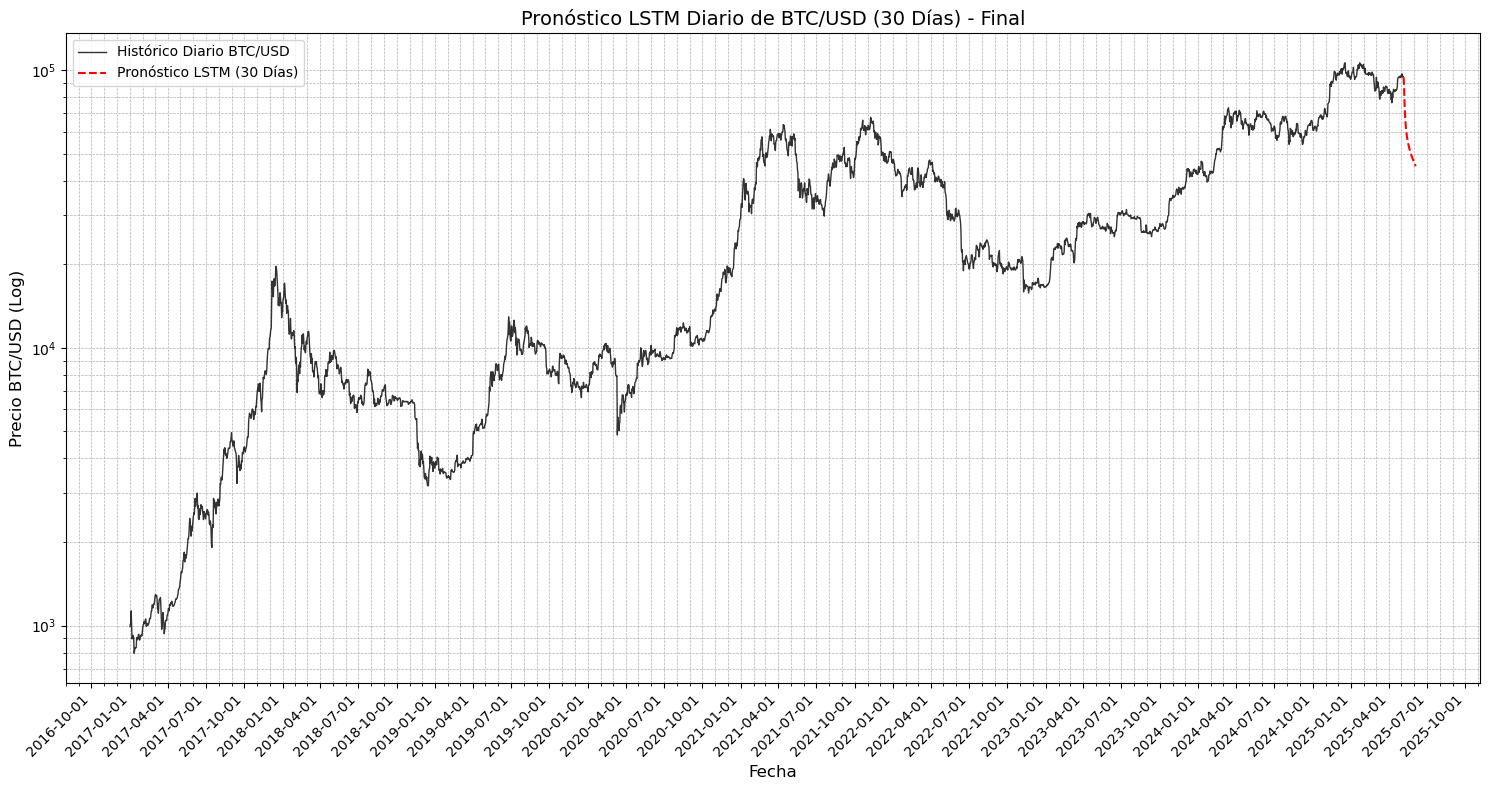


--- Script Finalizado (Versión con Tuning y sin MC) ---
Bloque 11 (Visualización) completado.


In [ ]:
# --- Bloque 11: Visualización ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
# Asegurarse que las variables necesarias existen
if 'log_btc_col' not in locals() or 'combined_data_final' not in locals() or 'results_df' not in locals():
     print("Error: Faltan variables de celdas anteriores.")
else:
    print("\n--- Generando gráfica ---")
    fig, ax = plt.subplots(figsize=(15, 8))
    # Recalcular histórico en USD por si acaso
    if log_btc_col in combined_data_final.columns:
        hist_btc_usd = np.exp(combined_data_final[log_btc_col])

        # Graficar histórico
        ax.plot(hist_btc_usd.index, hist_btc_usd, label='Histórico Diario BTC/USD', color='black', linewidth=1.0, alpha=0.8)
        # Graficar pronóstico determinista
        ax.plot(results_df.index, results_df['Pronostico_USD'], label=f'Pronóstico LSTM ({forecast_steps} Días)', color='red', linestyle='--', linewidth=1.5) # Rojo para destacar

        # --- ELIMINAR fill_between ---

        # Configuración del gráfico
        ax.set_yscale('log'); ax.set_title(f'Pronóstico LSTM Diario de BTC/USD ({forecast_steps} Días) - Final', fontsize=14)
        ax.set_ylabel('Precio BTC/USD (Log)', fontsize=12); ax.set_xlabel('Fecha', fontsize=12)
        ax.legend(loc='upper left'); ax.grid(True, which="both", ls="--", linewidth=0.5)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)); ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
    else: print("Error: No se pudo graficar.")

    print("\n--- Script Finalizado (Versión con Tuning y sin MC) ---")
    print("Bloque 11 (Visualización) completado.")


--- Iniciando Backtesting MENSUAL para Ene 2024 - Abr 2025 (con MAPE) ---
Reconstruyendo secuencias X y fechas objetivo...
Preparando datos históricos reales (USD)...
  Histórico USD listo.
Generando periodos mensuales para backtesting...
Periodos mensuales generados: 16

--- Backtesting para: Enero 2024 (2024-01-01 a 2024-01-31) ---
Realizando predicciones para 31 días...
MAPE para Enero 2024: 2.26%

Resultados Backtesting - Enero 2024:


Pronostico_USD  Real_USD
2024-01-01    42194.405771  44220.78
2024-01-02    43122.640452  44972.80
2024-01-03    43932.790844  42862.44
2024-01-04    43502.750820  44193.29
2024-01-05    43707.718138  44186.59
2024-01-06    43948.862302  43992.44
2024-01-07    43939.121323  43950.28
2024-01-08    44029.461930  46995.10
2024-01-09    45417.353970  46124.08
2024-01-10    45827.728547  46666.11
2024-01-11    46269.549282  46342.66
2024-01-12    46344.374070  42773.03
2024-01-13    44710.107553  42839.33
2024-01-14    43701.752404  41697.33
2024-01-15    42683.732976  42490.16
2024-01-16    42519.938737  43130.45
2024-01-17    42765.978817  42739.49
2024-01-18    42680.346846  41293.50
2024-01-19    42027.291544  41624.07
2024-01-20    41895.455180  41666.67
2024-01-21    41997.858050  41554.05
2024-01-22    41862.817169  39524.27
2024-01-23    40775.235823  39878.30
2024-01-24    40317.476200  40077.78
2024-01-25    40203.923610  39941.66
2024-01-26    40260.929956  41814.80
2024-01-27    41124.745782  42126.55
2024-01-28    41691.616776  42034.59
2024-01-29    42015.880860  43306.18
2024-01-30    42709.934764  42942.78
2024-01-31    42997.161405  42548.08


Generando gráfica para Enero 2024...


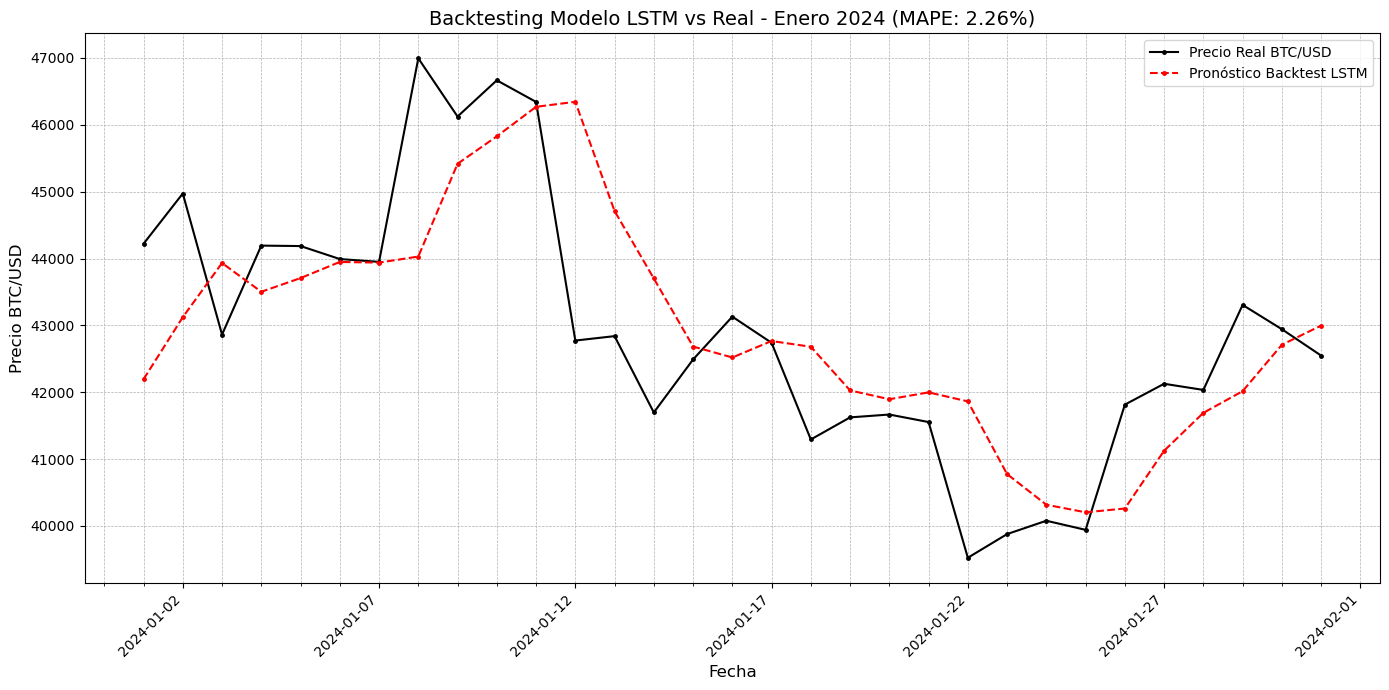


--- Backtesting para: Febrero 2024 (2024-02-01 a 2024-02-29) ---
Realizando predicciones para 29 días...
MAPE para Febrero 2024: 2.52%

Resultados Backtesting - Febrero 2024:


Pronostico_USD  Real_USD
2024-02-01    42611.089779  43078.81
2024-02-02    42748.282598  43181.66
2024-02-03    42914.571098  43010.67
2024-02-04    43089.385751  42568.55
2024-02-05    42959.592696  42657.67
2024-02-06    42897.526562  43095.79
2024-02-07    43174.050225  44343.61
2024-02-08    43923.796469  45305.20
2024-02-09    44856.400308  47160.41
2024-02-10    46135.976346  47767.06
2024-02-11    47119.452807  48316.30
2024-02-12    47784.939417  49941.81
2024-02-13    48839.350994  49725.36
2024-02-14    49162.435164  51858.59
2024-02-15    50264.186907  51934.29
2024-02-16    51255.052914  52162.64
2024-02-17    51808.156982  51666.22
2024-02-18    51612.540043  52153.63
2024-02-19    51717.827857  51787.05
2024-02-20    51641.601964  52277.52
2024-02-21    51831.992207  51851.67
2024-02-22    51840.610046  51258.70
2024-02-23    51699.533642  50747.05
2024-02-24    51430.230663  51570.65
2024-02-25    51534.560359  51731.00
2024-02-26    51607.617701  54533.48
2024-02-27    52927.796733  57077.07
2024-02-28    54932.412166  62518.90
2024-02-29    58469.750579  61179.03


Generando gráfica para Febrero 2024...


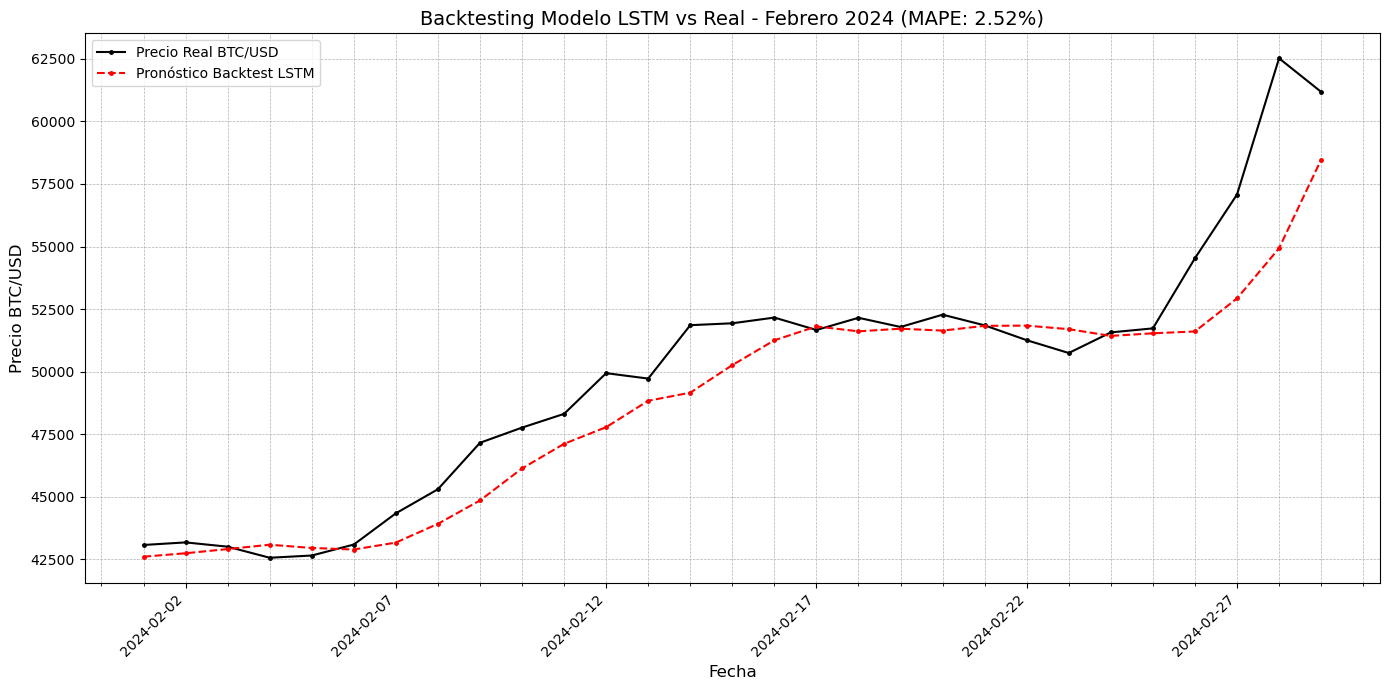


--- Backtesting para: Marzo 2024 (2024-03-01 a 2024-03-31) ---
Realizando predicciones para 31 días...
MAPE para Marzo 2024: 3.11%

Resultados Backtesting - Marzo 2024:


Pronostico_USD  Real_USD
2024-03-01    59796.876539  62436.72
2024-03-02    61257.415604  62045.78
2024-03-03    61699.888588  63154.49
2024-03-04    62387.937355  68360.14
2024-03-05    65053.008871  63800.78
2024-03-06    64325.886382  66122.28
2024-03-07    64922.447747  66938.21
2024-03-08    65745.267547  68289.16
2024-03-09    66859.320275  68480.00
2024-03-10    67443.251067  69032.12
2024-03-11    67964.651186  72110.98
2024-03-12    69639.818800  71475.93
2024-03-13    70388.873609  73135.04
2024-03-14    71764.633542  71364.58
2024-03-15    71429.968358  69506.88
2024-03-16    70138.481826  65254.22
2024-03-17    67453.402104  68343.64
2024-03-18    67521.193516  67613.04
2024-03-19    67278.294804  61906.27
2024-03-20    64621.122649  67858.80
2024-03-21    65956.405685  65484.70
2024-03-22    65784.090873  63814.56
2024-03-23    64740.559236  63998.86
2024-03-24    64311.197542  67204.93
2024-03-25    65480.733757  69890.28
2024-03-26    67404.116991  69992.40
2024-03-27    68516.036482  69435.96
2024-03-28    69068.671770  70801.18
2024-03-29    70077.832049  69903.75
2024-03-30    69990.323929  69626.87
2024-03-31    69788.415320  71288.90


Generando gráfica para Marzo 2024...


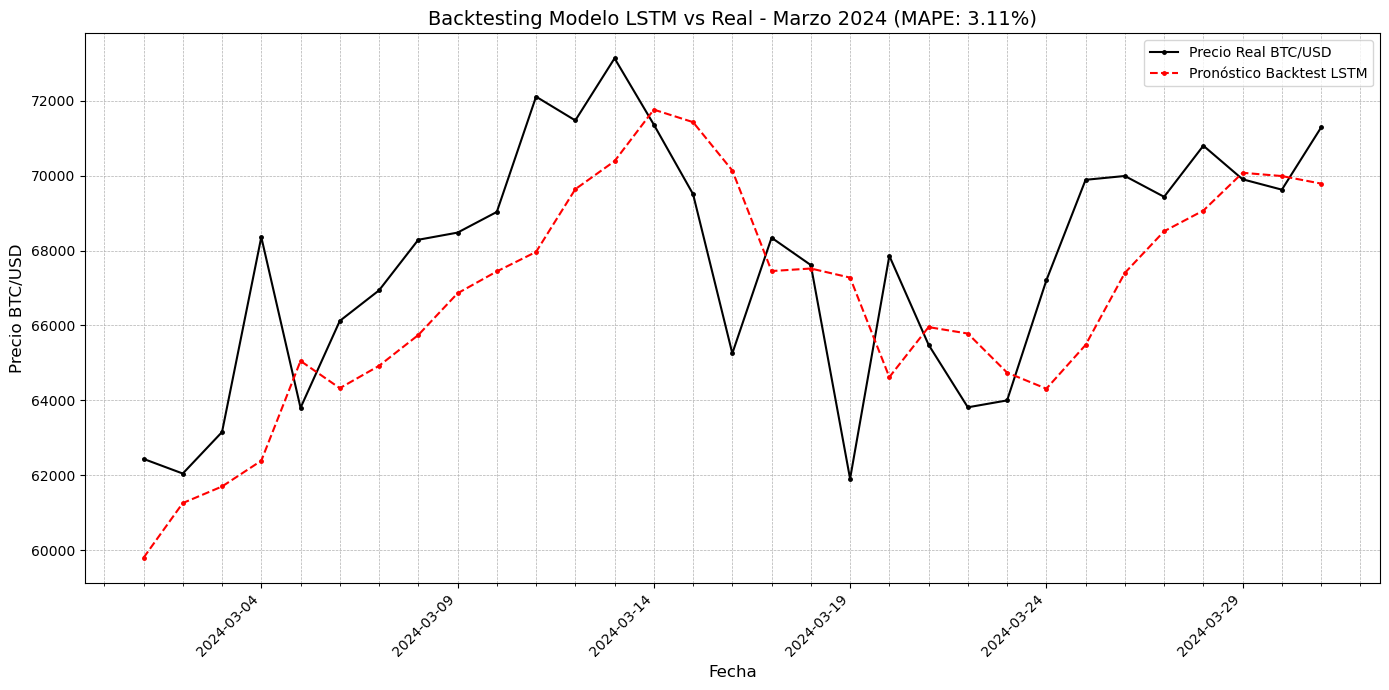


--- Backtesting para: Abril 2024 (2024-04-01 a 2024-04-30) ---
Realizando predicciones para 30 días...
MAPE para Abril 2024: 2.37%

Resultados Backtesting - Abril 2024:


Pronostico_USD  Real_USD
2024-04-01    70359.152131  69681.82
2024-04-02    69861.752479  65464.14
2024-04-03    67471.071699  65987.92
2024-04-04    66418.289611  68525.23
2024-04-05    66989.106621  67856.51
2024-04-06    67146.087633  68919.89
2024-04-07    67920.103355  69350.34
2024-04-08    68502.029151  71622.53
2024-04-09    69789.697702  69117.01
2024-04-10    69180.789885  70634.04
2024-04-11    69403.629069  70020.73
2024-04-12    69198.689960  67148.61
2024-04-13    67814.775275  64024.77
2024-04-14    65256.099447  65777.05
2024-04-15    64856.584478  63452.18
2024-04-16    63726.739414  63814.94
2024-04-17    63260.006726  61279.36
2024-04-18    61751.684562  63513.85
2024-04-19    61995.186108  63848.37
2024-04-20    62488.299436  64968.87
2024-04-21    63335.294472  64952.92
2024-04-22    63767.792911  66859.17
2024-04-23    64868.465206  66414.16
2024-04-24    65490.856834  64255.78
2024-04-25    64668.108805  64484.44
2024-04-26    64260.759520  63742.39
2024-04-27    63749.456877  63422.00
2024-04-28    63448.634706  63108.94
2024-04-29    63089.878269  63844.85
2024-04-30    63197.968165  60622.10


Generando gráfica para Abril 2024...


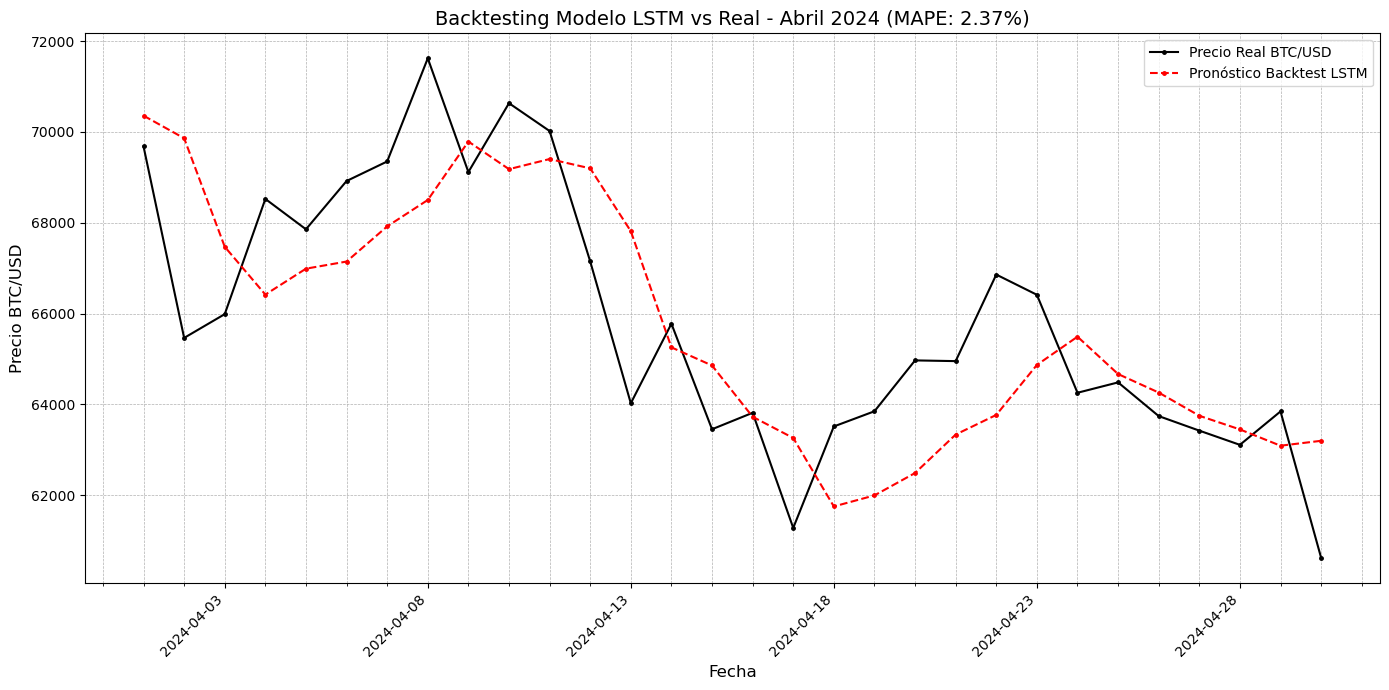


--- Backtesting para: Mayo 2024 (2024-05-01 a 2024-05-31) ---
Realizando predicciones para 31 días...
MAPE para Mayo 2024: 2.18%

Resultados Backtesting - Mayo 2024:


Pronostico_USD  Real_USD
2024-05-01    61420.166237  58265.59
2024-05-02    59174.102407  59071.89
2024-05-03    58726.083490  62913.03
2024-05-04    60460.141554  63902.88
2024-05-05    62302.453774  64023.45
2024-05-06    63327.573266  63162.24
2024-05-07    63287.449242  62315.76
2024-05-08    62760.291084  61169.53
2024-05-09    61914.484275  63073.57
2024-05-10    62504.103263  60787.47
2024-05-11    61712.379016  60814.63
2024-05-12    61321.036770  61453.02
2024-05-13    61306.998326  62932.37
2024-05-14    61985.097149  61539.84
2024-05-15    61728.688770  66244.69
2024-05-16    64078.893187  65252.18
2024-05-17    64922.050095  67046.33
2024-05-18    66115.459658  66923.87
2024-05-19    66523.447166  66261.62
2024-05-20    66438.807858  71432.17
2024-05-21    68677.396910  70142.84
2024-05-22    69321.006477  69109.93
2024-05-23    68859.600088  67940.45
2024-05-24    67696.656586  68547.80
2024-05-25    67593.469049  69289.67
2024-05-26    68116.626518  68473.72
2024-05-27    68002.920633  69368.72
2024-05-28    68309.334959  68321.98
2024-05-29    67975.911667  67569.45
2024-05-30    67213.903461  68338.58
2024-05-31    67087.477537  67472.41


Generando gráfica para Mayo 2024...


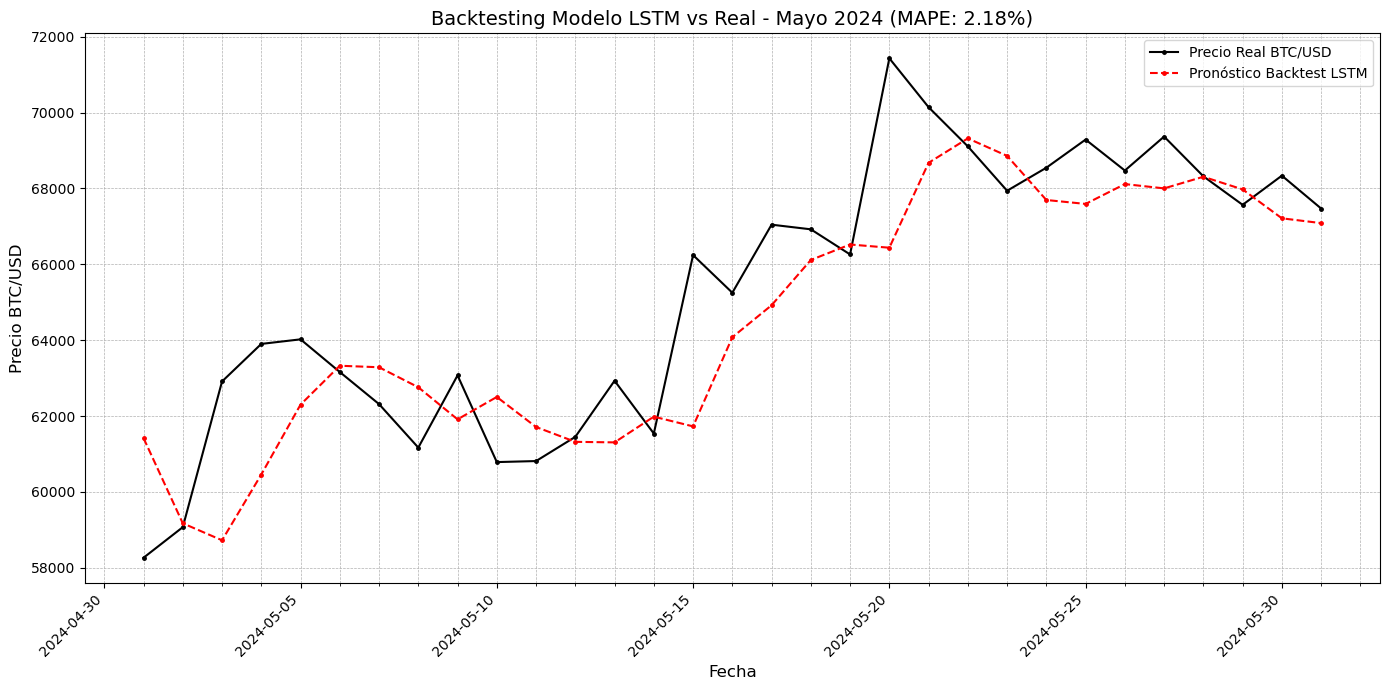


--- Backtesting para: Junio 2024 (2024-06-01 a 2024-06-30) ---
Realizando predicciones para 30 días...
MAPE para Junio 2024: 1.42%

Resultados Backtesting - Junio 2024:


Pronostico_USD  Real_USD
2024-06-01    67042.585600  67719.29
2024-06-02    66877.263379  67735.52
2024-06-03    66993.952372  68791.00
2024-06-04    67607.211722  70542.32
2024-06-05    68697.871678  71121.11
2024-06-06    69768.653333  70773.64
2024-06-07    70442.642245  69324.53
2024-06-08    69774.595588  69304.05
2024-06-09    69356.823140  69637.87
2024-06-10    69264.134245  69497.73
2024-06-11    69120.867437  67316.53
2024-06-12    67960.210946  68248.60
2024-06-13    67967.307540  66738.85
2024-06-14    67209.963136  66004.39
2024-06-15    66314.129975  66192.00
2024-06-16    66251.917447  66628.75
2024-06-17    66305.001301  66481.81
2024-06-18    66150.218194  65152.80
2024-06-19    65569.526315  64943.79
2024-06-20    65128.872832  64840.88
2024-06-21    64799.292431  64120.28
2024-06-22    64158.617336  64235.01
2024-06-23    64022.530877  63171.43
2024-06-24    63311.376570  60263.00
2024-06-25    61589.528482  61789.71
2024-06-26    61315.957522  60816.68
2024-06-27    60918.120149  61615.39
2024-06-28    61158.209888  60313.35
2024-06-29    60625.247465  60885.67
2024-06-30    60627.245618  62668.26


Generando gráfica para Junio 2024...


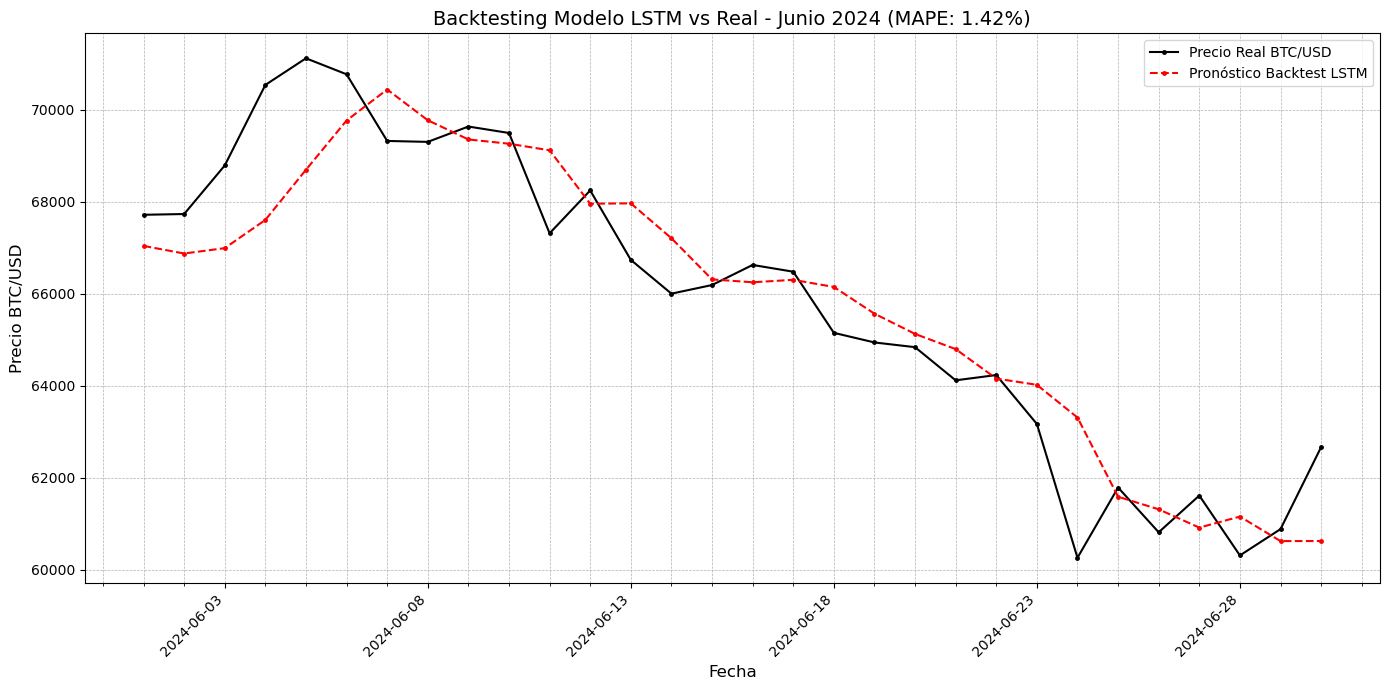


--- Backtesting para: Julio 2024 (2024-07-01 a 2024-07-31) ---
Realizando predicciones para 31 días...
MAPE para Julio 2024: 2.44%

Resultados Backtesting - Julio 2024:


Pronostico_USD  Real_USD
2024-07-01    61464.573988  62830.13
2024-07-02    61977.251316  62040.22
2024-07-03    61851.149397  60145.01
2024-07-04    61013.163624  57042.14
2024-07-05    59003.740705  56639.43
2024-07-06    57789.540320  58244.75
2024-07-07    57806.482469  55854.09
2024-07-08    56716.003968  56699.43
2024-07-09    56528.856390  58047.86
2024-07-10    57080.504719  57712.59
2024-07-11    57521.690344  57340.77
2024-07-12    57697.616796  57909.03
2024-07-13    57873.422989  59224.58
2024-07-14    58621.555450  60808.42
2024-07-15    59786.290871  64757.16
2024-07-16    62203.551307  65088.99
2024-07-17    63858.471928  64085.81
2024-07-18    64405.936615  63982.86
2024-07-19    63832.178130  66707.61
2024-07-20    64619.501746  67163.83
2024-07-21    65589.858880  68181.28
2024-07-22    66805.032715  67558.22
2024-07-23    67128.424829  65939.24
2024-07-24    66311.170755  65366.40
2024-07-25    65526.261703  65795.42
2024-07-26    65146.085520  67924.08
2024-07-27    66228.037784  67899.41
2024-07-28    67009.058515  68244.30
2024-07-29    67688.285231  66771.45
2024-07-30    67325.583124  66169.68
2024-07-31    66804.701473  64609.62


Generando gráfica para Julio 2024...


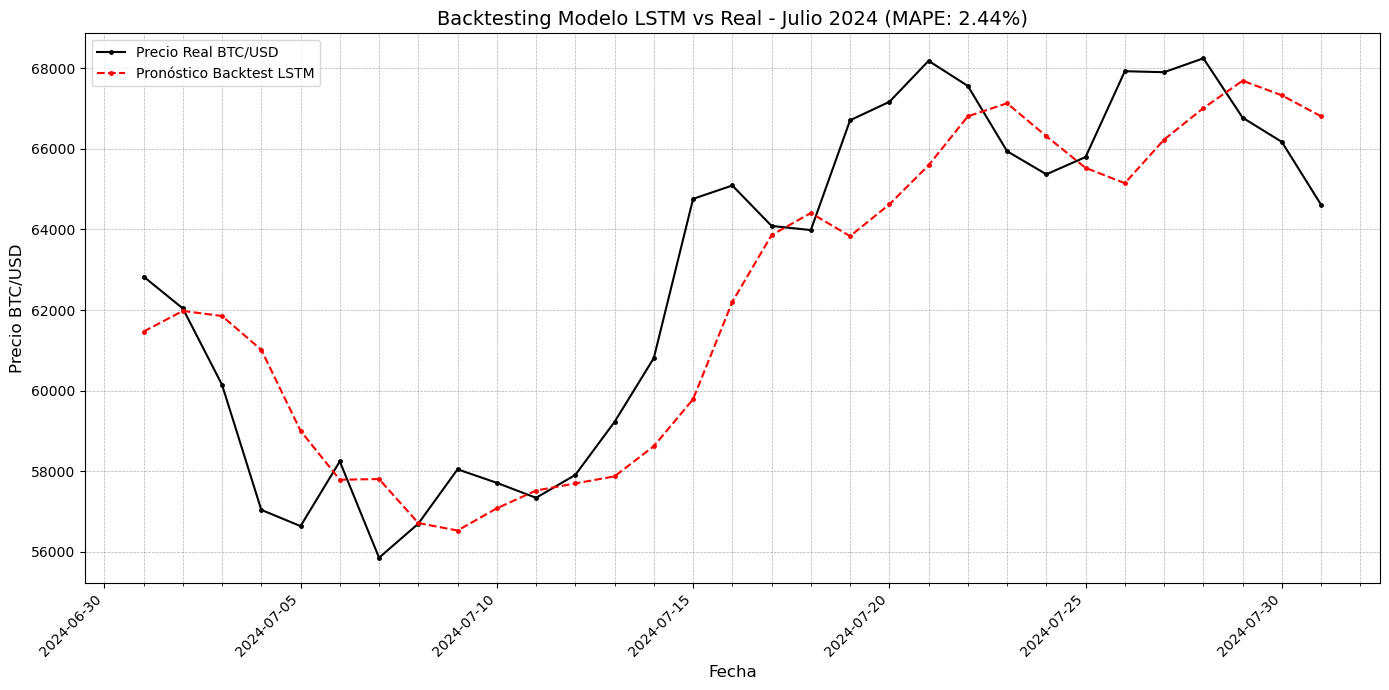


--- Backtesting para: Agosto 2024 (2024-08-01 a 2024-08-31) ---
Realizando predicciones para 31 días...
MAPE para Agosto 2024: 3.07%

Resultados Backtesting - Agosto 2024:


Pronostico_USD  Real_USD
2024-08-01    66065.938138  65288.18
2024-08-02    65872.526264  61418.06
2024-08-03    63197.654808  60674.93
2024-08-04    60846.291386  58130.95
2024-08-05    58689.730837  54029.12
2024-08-06    56019.862108  56048.08
2024-08-07    55980.661680  55148.10
2024-08-08    55751.579203  61705.58
2024-08-09    58912.119522  60862.13
2024-08-10    60681.716209  60935.02
2024-08-11    61554.832341  58722.49
2024-08-12    60665.541529  59358.78
2024-08-13    60290.174463  60603.19
2024-08-14    60713.989966  58690.62
2024-08-15    60176.385585  57543.61
2024-08-16    59420.367492  58888.99
2024-08-17    59706.026392  59497.49
2024-08-18    60140.591060  58437.90
2024-08-19    59854.947919  59452.67
2024-08-20    60049.726625  59017.59
2024-08-21    59856.781016  61163.28
2024-08-22    60659.490405  60383.29
2024-08-23    60882.292840  64086.72
2024-08-24    62907.362369  64179.63
2024-08-25    64273.074745  64251.93
2024-08-26    64715.525508  62840.00
2024-08-27    64187.460624  59439.64
2024-08-28    62091.384809  59045.88
2024-08-29    60772.012548  59364.47
2024-08-30    60389.592568  59112.77
2024-08-31    60170.874649  58968.37


Generando gráfica para Agosto 2024...


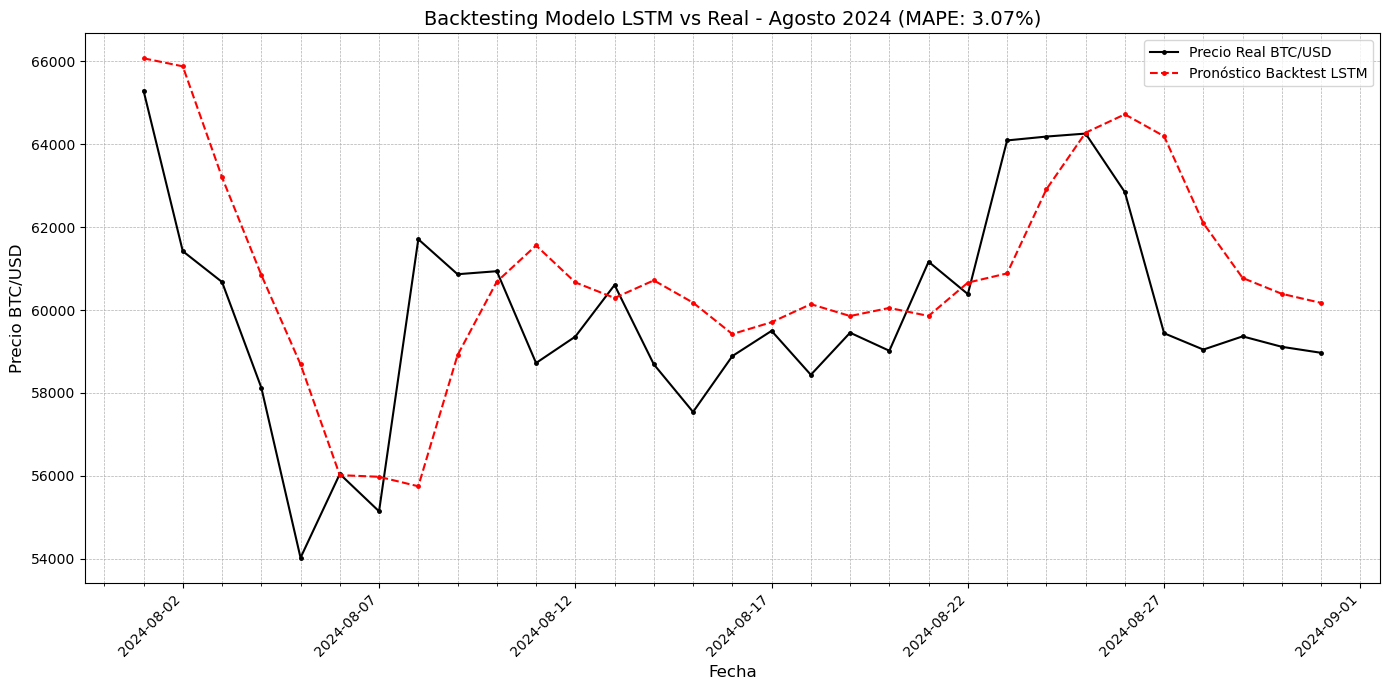


--- Backtesting para: Septiembre 2024 (2024-09-01 a 2024-09-30) ---
Realizando predicciones para 30 días...
MAPE para Septiembre 2024: 2.08%

Resultados Backtesting - Septiembre 2024:


Pronostico_USD  Real_USD
2024-09-01    59713.236375  57299.00
2024-09-02    58683.620049  59139.83
2024-09-03    59164.196443  57468.84
2024-09-04    58779.240293  57971.00
2024-09-05    58748.286286  56156.82
2024-09-06    57815.705806  53950.01
2024-09-07    56101.012424  54156.33
2024-09-08    55500.718023  54881.11
2024-09-09    55751.611725  57053.90
2024-09-10    56940.030605  57645.59
2024-09-11    57753.413664  57352.79
2024-09-12    58327.320591  58137.54
2024-09-13    59271.818418  60543.35
2024-09-14    60876.220096  60012.35
2024-09-15    61576.542078  59122.33
2024-09-16    61132.831789  58208.75
2024-09-17    60315.642552  60312.60
2024-09-18    60893.871797  61769.18
2024-09-19    61815.927247  62960.14
2024-09-20    63281.598023  63210.69
2024-09-21    63867.394168  63362.74
2024-09-22    64245.579613  63577.66
2024-09-23    64574.924007  63338.87
2024-09-24    64556.732470  64272.93
2024-09-25    65038.059145  63130.89
2024-09-26    64477.040183  65177.21
2024-09-27    65174.688394  65789.00
2024-09-28    66055.456441  65858.99
2024-09-29    66485.001941  65600.01
2024-09-30    66527.521877  63301.25


Generando gráfica para Septiembre 2024...


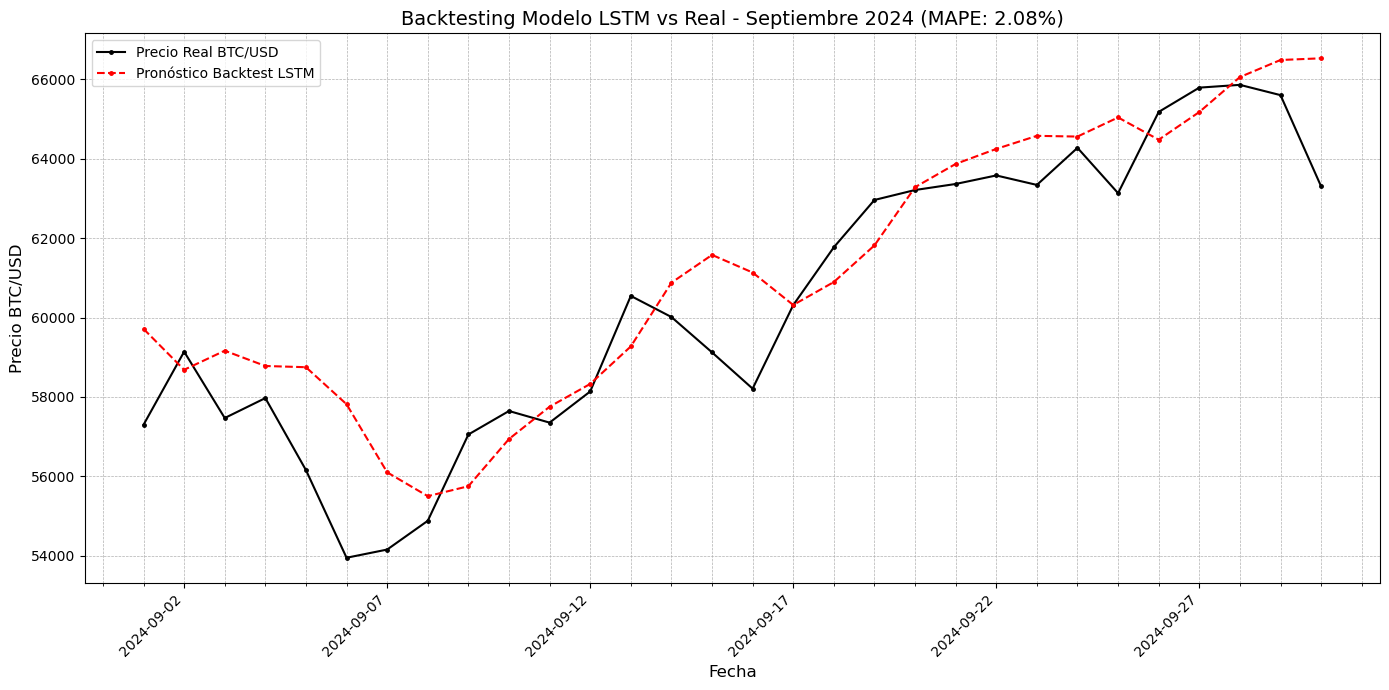


--- Backtesting para: Octubre 2024 (2024-10-01 a 2024-10-31) ---
Realizando predicciones para 31 días...
MAPE para Octubre 2024: 2.05%

Resultados Backtesting - Octubre 2024:


Pronostico_USD  Real_USD
2024-10-01    65392.614554  60790.00
2024-10-02    63514.624270  60631.37
2024-10-03    62415.347449  60744.99
2024-10-04    62131.729106  62090.71
2024-10-05    62701.449161  62051.29
2024-10-06    62997.754928  62810.86
2024-10-07    63238.939248  62200.28
2024-10-08    63071.442830  62122.02
2024-10-09    62834.910794  60578.28
2024-10-10    62265.975756  60279.53
2024-10-11    61897.836572  62518.75
2024-10-12    62836.780173  63187.47
2024-10-13    63562.826637  62845.30
2024-10-14    63962.897295  66065.65
2024-10-15    65595.980924  67056.60
2024-10-16    66838.867109  67608.44
2024-10-17    67841.443194  67402.33
2024-10-18    68299.931628  68426.11
2024-10-19    68990.633265  68363.73
2024-10-20    69360.970251  69014.86
2024-10-21    69784.792210  67346.15
2024-10-22    69117.016912  67380.08
2024-10-23    68765.088619  66601.11
2024-10-24    67969.825225  68156.84
2024-10-25    68121.573699  66564.51
2024-10-26    67635.790438  67012.56
2024-10-27    67557.479252  67943.19
2024-10-28    68126.978259  69924.50
2024-10-29    69376.893411  72724.35
2024-10-30    71232.050436  72322.91
2024-10-31    72371.962329  70197.83


Generando gráfica para Octubre 2024...


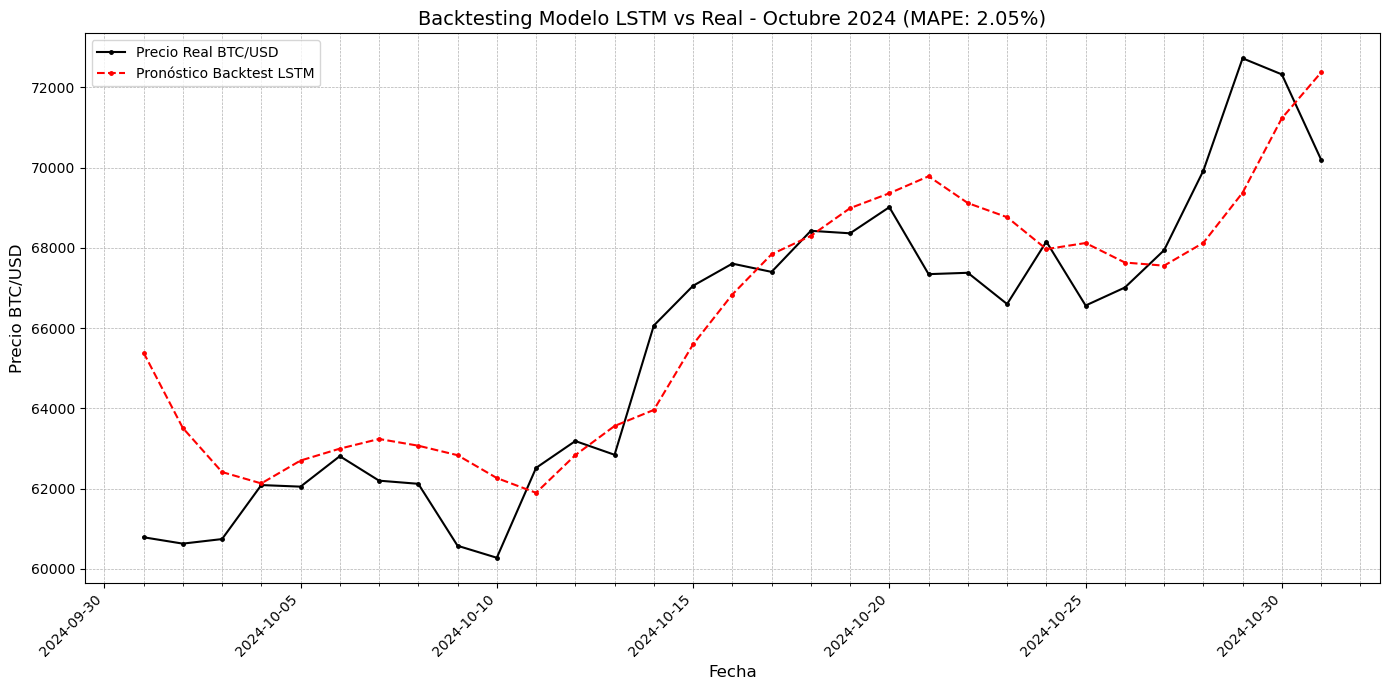


--- Backtesting para: Noviembre 2024 (2024-11-01 a 2024-11-30) ---
Realizando predicciones para 30 días...
MAPE para Noviembre 2024: 2.86%

Resultados Backtesting - Noviembre 2024:


Pronostico_USD  Real_USD
2024-11-01    71307.050226  69467.29
2024-11-02    70131.567638  69358.94
2024-11-03    69811.501802  68738.18
2024-11-04    69280.035175  67807.48
2024-11-05    68600.820929  69380.73
2024-11-06    69353.728142  75646.55
2024-11-07    73165.639679  75920.00
2024-11-08    75488.140368  76566.73
2024-11-09    76888.671697  76716.06
2024-11-10    77082.429408  80428.92
2024-11-11    78876.270040  88770.73
2024-11-12    83729.330526  88035.43
2024-11-13    85971.685792  90493.82
2024-11-14    88279.629307  87340.40
2024-11-15    87719.839358  91058.36
2024-11-16    88850.610254  90636.24
2024-11-17    89545.083257  89886.69
2024-11-18    89714.432232  90520.30
2024-11-19    90051.885301  92435.89
2024-11-20    91171.438049  94393.15
2024-11-21    92772.223422  98439.09
2024-11-22    95918.958749  99024.03
2024-11-23    98059.477808  97778.77
2024-11-24    98325.941607  98028.18
2024-11-25    98031.338599  93000.01
2024-11-26    95347.873933  91929.54
2024-11-27    93556.379897  95951.19
2024-11-28    94739.533072  95665.53
2024-11-29    95171.943700  97490.56
2024-11-30    96443.324308  96465.42


Generando gráfica para Noviembre 2024...


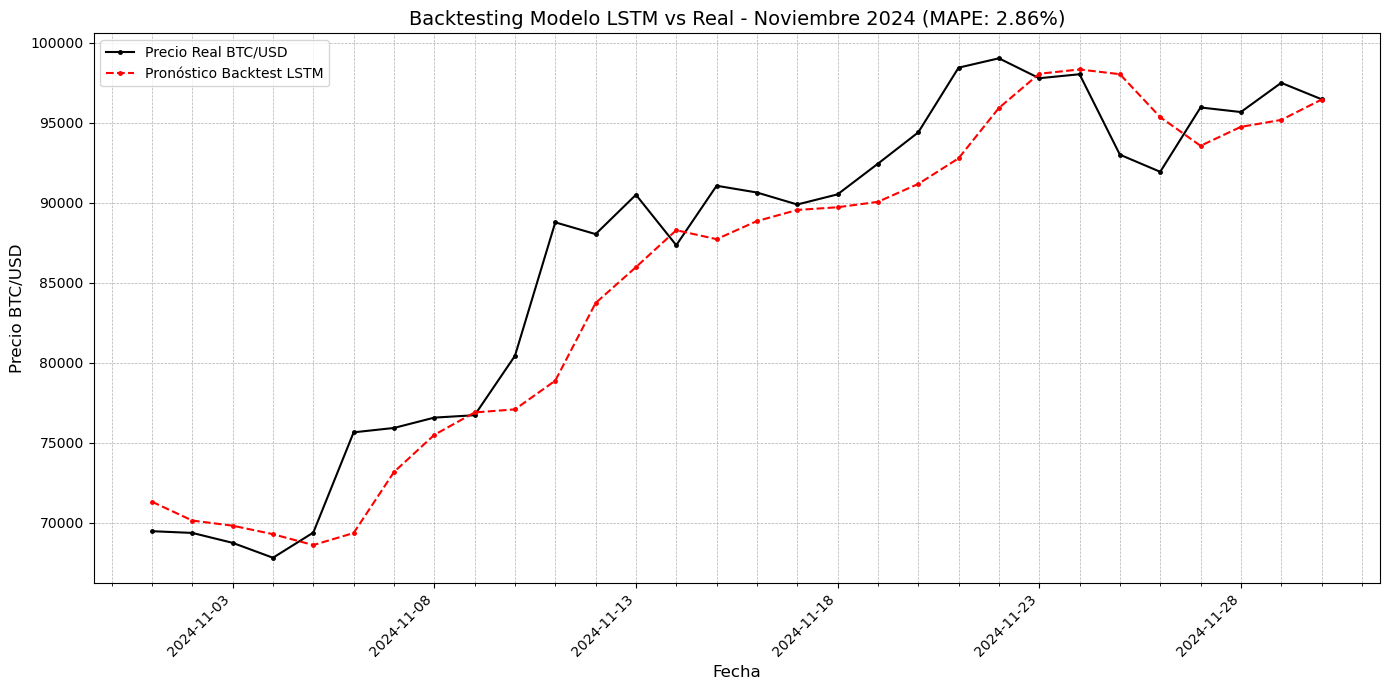


--- Backtesting para: Diciembre 2024 (2024-12-01 a 2024-12-31) ---
Realizando predicciones para 31 días...
MAPE para Diciembre 2024: 1.96%

Resultados Backtesting - Diciembre 2024:


Pronostico_USD   Real_USD
2024-12-01    96308.032104   97263.18
2024-12-02    96759.736281   95862.89
2024-12-03    96013.510070   95924.52
2024-12-04    95874.877856   98746.24
2024-12-05    97067.616560   97044.23
2024-12-06    97131.338491   99891.35
2024-12-07    98047.752156   99929.32
2024-12-08    98693.396876  101174.99
2024-12-09    99626.233573   97324.81
2024-12-10    98290.128584   96660.76
2024-12-11    97126.409170  101202.11
2024-12-12    98903.381747  100030.47
2024-12-13    99351.261698  101428.75
2024-12-14    99738.896336  101399.99
2024-12-15    99673.870749  104447.76
2024-12-16   101321.225171  106099.81
2024-12-17   102910.706176  106136.99
2024-12-18   103467.499534  100150.73
2024-12-19    99894.711317   97372.21
2024-12-20    96839.071955   97765.00
2024-12-21    96266.327457   97230.08
2024-12-22    96126.825534   95087.75
2024-12-23    95147.768979   94764.56
2024-12-24    94377.576845   98594.47
2024-12-25    96183.421192   99346.28
2024-12-26    97538.272951   95669.49
2024-12-27    96312.723251   94171.89
2024-12-28    94544.068987   95130.82
2024-12-29    93516.603254   93563.35
2024-12-30    92383.556418   92620.71
2024-12-31    91607.065878   93354.22


Generando gráfica para Diciembre 2024...


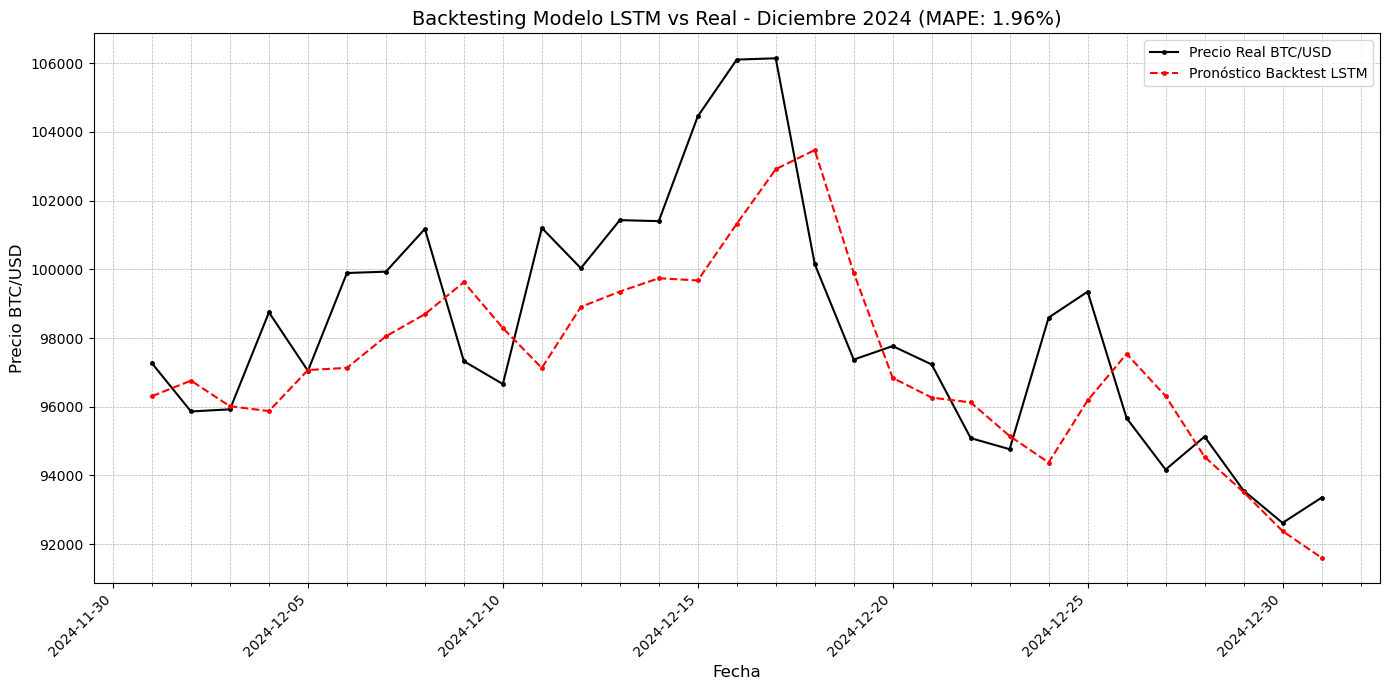


--- Backtesting para: Enero 2025 (2025-01-01 a 2025-01-31) ---
Realizando predicciones para 31 días...
MAPE para Enero 2025: 2.39%

Resultados Backtesting - Enero 2025:


Pronostico_USD   Real_USD
2025-01-01    91750.792576   94383.59
2025-01-02    92352.547498   96903.19
2025-01-03    93915.707127   98136.51
2025-01-04    95845.939813   98209.85
2025-01-05    96767.469354   98345.33
2025-01-06    97079.168366  102279.41
2025-01-07    98890.661037   96941.98
2025-01-08    97124.171227   95036.63
2025-01-09    95117.052909   92547.44
2025-01-10    92902.738248   94701.18
2025-01-11    92771.925776   94565.02
2025-01-12    93202.260363   94509.62
2025-01-13    93135.682952   94506.45
2025-01-14    93080.120463   96534.96
2025-01-15    94068.268800  100510.23
2025-01-16    97209.391074   99981.78
2025-01-17    98513.362455  104107.00
2025-01-18   100833.255820  104435.00
2025-01-19   102773.595320  101211.13
2025-01-20   101878.808177  102145.43
2025-01-21   101518.974420  106159.26
2025-01-22   103129.363203  103667.11
2025-01-23   102718.904005  103926.36
2025-01-24   103085.185754  104850.27
2025-01-25   103582.482004  104733.56
2025-01-26   103310.510987  102563.00
2025-01-27   101837.483218  102062.42
2025-01-28   101126.604158  101290.00
2025-01-29   100755.320349  103747.25
2025-01-30   101629.983317  104742.64
2025-01-31   102945.440331  102411.26


Generando gráfica para Enero 2025...


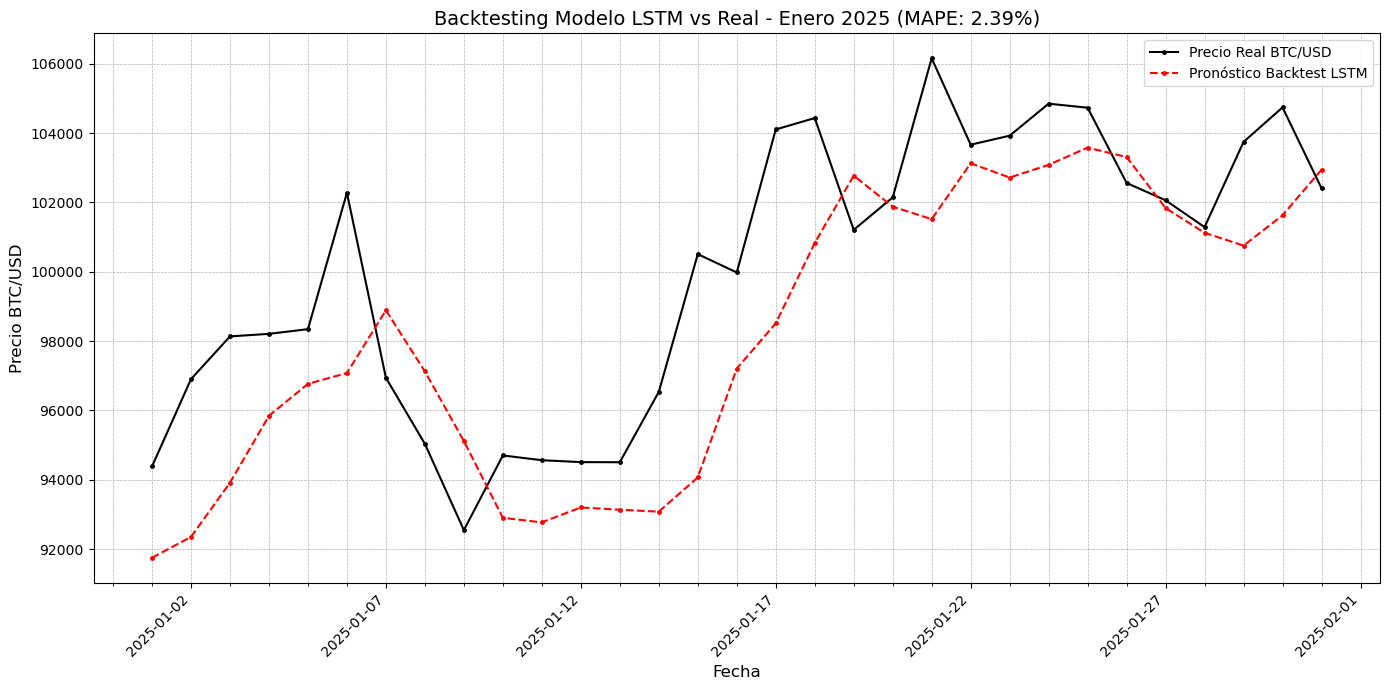


--- Backtesting para: Febrero 2025 (2025-02-01 a 2025-02-28) ---
Realizando predicciones para 28 días...
MAPE para Febrero 2025: 1.64%

Resultados Backtesting - Febrero 2025:


Pronostico_USD   Real_USD
2025-02-01   102184.735137  100623.85
2025-02-02   100791.473032   97676.52
2025-02-03    98582.375138  101460.20
2025-02-04    99346.654361   97795.05
2025-02-05    98240.344646   96638.33
2025-02-06    97156.215550   96564.62
2025-02-07    96628.030345   96537.08
2025-02-08    96057.486602   96476.25
2025-02-09    95898.118492   96475.82
2025-02-10    96094.812420   97444.41
2025-02-11    96505.763828   95774.08
2025-02-12    96037.232487   97862.53
2025-02-13    96039.641466   96625.29
2025-02-14    96076.147698   97509.03
2025-02-15    96342.251826   97596.94
2025-02-16    96587.342152   96119.88
2025-02-17    96022.023699   95781.80
2025-02-18    95449.935495   95607.40
2025-02-19    95011.855516   96632.03
2025-02-20    95437.909485   98347.20
2025-02-21    96341.633628   96157.03
2025-02-22    94858.372192   96582.12
2025-02-23    94600.919234   96265.98
2025-02-24    94537.837123   91510.82
2025-02-25    92429.887129   88583.74
2025-02-26    89854.508083   84111.78
2025-02-27    86181.872160   84625.19
2025-02-28    84707.649779   84297.73


Generando gráfica para Febrero 2025...


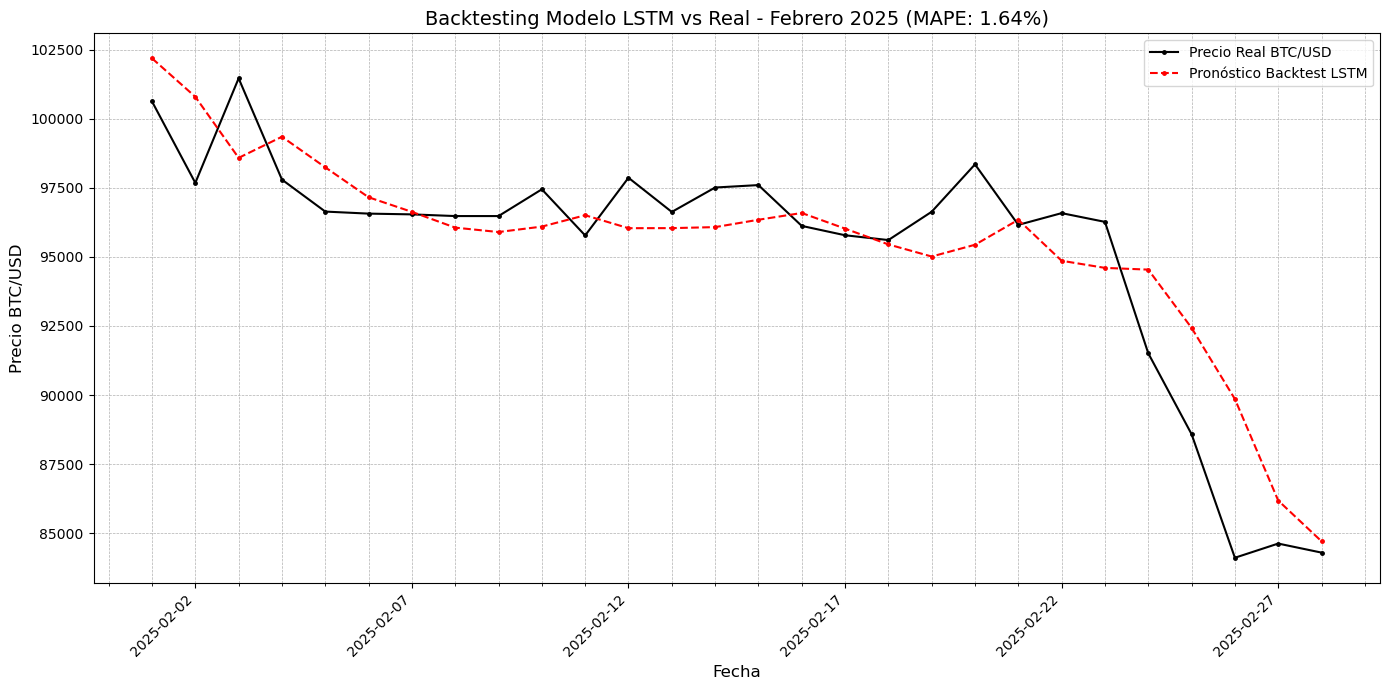


--- Backtesting para: Marzo 2025 (2025-03-01 a 2025-03-31) ---
Realizando predicciones para 31 días...
MAPE para Marzo 2025: 2.34%

Resultados Backtesting - Marzo 2025:


Pronostico_USD  Real_USD
2025-03-01    84090.589094  86018.76
2025-03-02    84470.872526  94265.48
2025-03-03    88517.013302  86161.10
2025-03-04    87242.776447  87249.96
2025-03-05    86434.915399  90603.73
2025-03-06    87977.962832  89921.85
2025-03-07    88318.157300  86756.98
2025-03-08    86952.362557  86206.69
2025-03-09    85471.765670  80699.17
2025-03-10    82029.187410  78544.71
2025-03-11    79622.564291  82914.51
2025-03-12    80352.948687  83659.43
2025-03-13    81569.510873  81073.43
2025-03-14    80916.452108  83980.49
2025-03-15    82600.543056  84351.46
2025-03-16    84080.509276  82562.57
2025-03-17    83641.655480  84011.40
2025-03-18    83818.979900  82698.76
2025-03-19    83022.189223  86877.96
2025-03-20    84791.223837  84183.42
2025-03-21    84711.182890  84061.96
2025-03-22    84273.731974  83852.03
2025-03-23    84418.829542  86092.94
2025-03-24    85482.485994  87523.62
2025-03-25    86511.967319  87427.88
2025-03-26    86907.383309  86926.01
2025-03-27    86681.647562  87217.48
2025-03-28    86578.809625  84381.80
2025-03-29    84751.243353  82616.83
2025-03-30    83539.012881  82379.98
2025-03-31    82880.410768  82534.32


Generando gráfica para Marzo 2025...


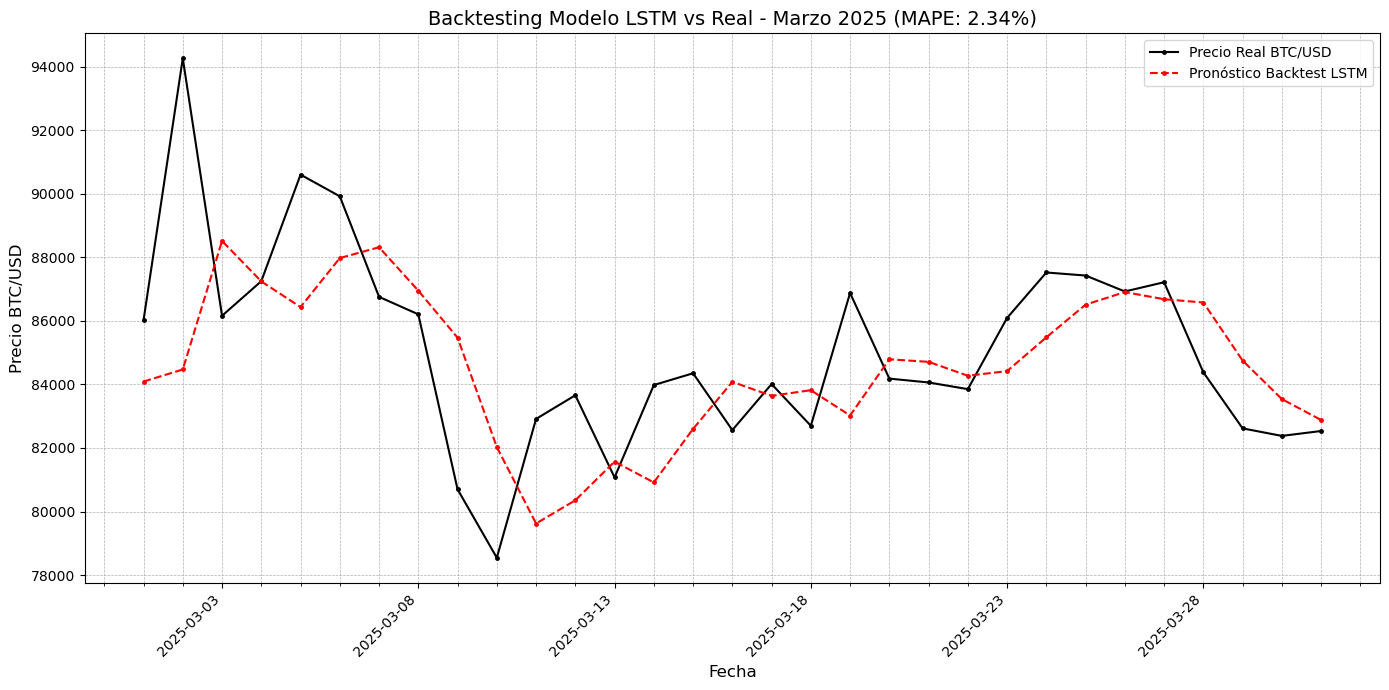


--- Backtesting para: Abril 2025 (2025-04-01 a 2025-04-30) ---
Realizando predicciones para 30 días...
MAPE para Abril 2025: 2.52%

Resultados Backtesting - Abril 2025:


Pronostico_USD  Real_USD
2025-04-01    82608.927489  85170.37
2025-04-02    83636.996043  82490.08
2025-04-03    83269.598135  83174.33
2025-04-04    81470.789361  83860.16
2025-04-05    78853.612657  83498.25
2025-04-06    78126.465203  78370.75
2025-04-07    76547.858806  79140.01
2025-04-08    76556.678321  76251.64
2025-04-09    75113.739370  82594.75
2025-04-10    80037.902718  79552.34
2025-04-11    80459.443999  83380.47
2025-04-12    82115.675191  85271.01
2025-04-13    84145.448406  83733.07
2025-04-14    84008.122155  84590.36
2025-04-15    84030.839065  83629.78
2025-04-16    83289.273026  84028.72
2025-04-17    82909.738539  84961.97
2025-04-18    83376.578697  84466.47
2025-04-19    82595.459805  85074.99
2025-04-20    82742.108224  85177.34
2025-04-21    83087.934637  87522.07
2025-04-22    84388.820277  93489.10
2025-04-23    88654.185249  93740.92
2025-04-24    91036.876386  94021.96
2025-04-25    92802.669494  94708.79
2025-04-26    93949.487849  94666.64
2025-04-27    94041.110337  93780.57
2025-04-28    93413.829822  95042.57
2025-04-29    93517.366981  94271.09
2025-04-30    93339.505421  94182.54


Generando gráfica para Abril 2025...


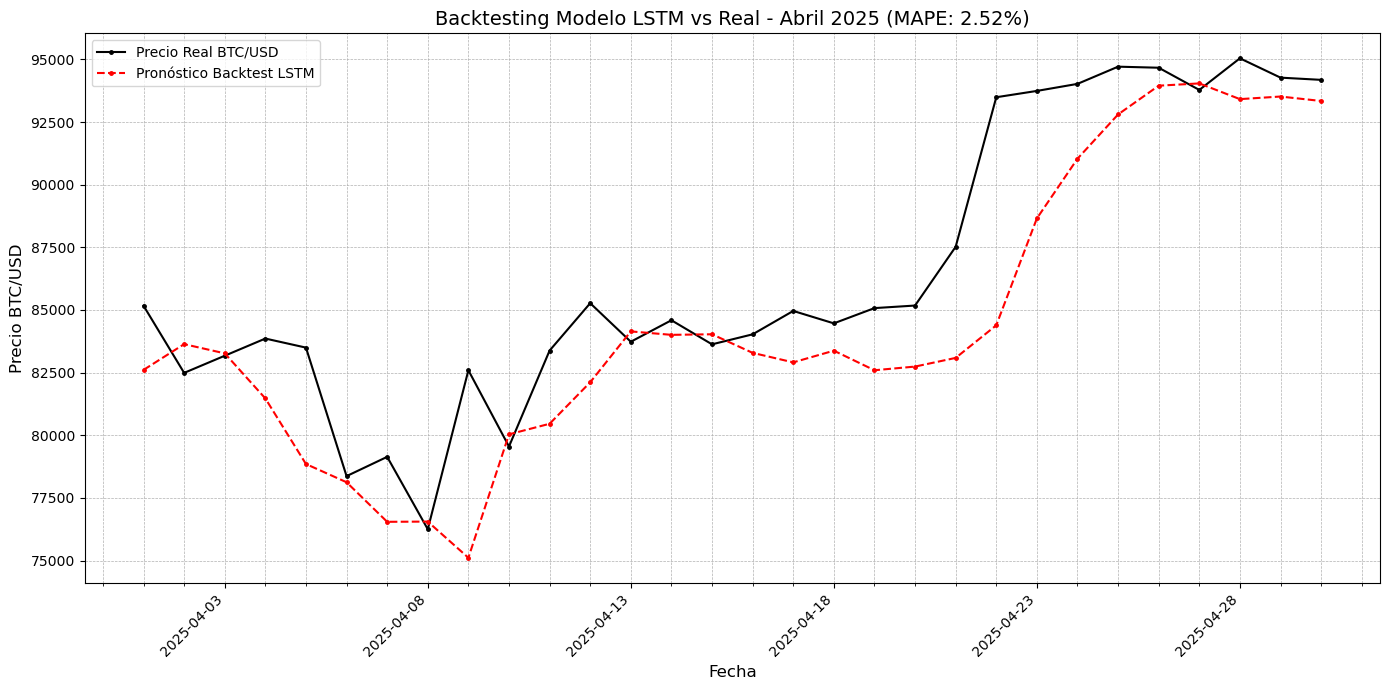


--- Resumen de Errores MAPE ---

  Promedio General MAPE (Ene 2024 - Abr 2025): 2.33%

MAPEs Mensuales Individuales:
 - Enero 2024: 2.26%
 - Febrero 2024: 2.52%
 - Marzo 2024: 3.11%
 - Abril 2024: 2.37%
 - Mayo 2024: 2.18%
 - Junio 2024: 1.42%
 - Julio 2024: 2.44%
 - Agosto 2024: 3.07%
 - Septiembre 2024: 2.08%
 - Octubre 2024: 2.05%
 - Noviembre 2024: 2.86%
 - Diciembre 2024: 1.96%
 - Enero 2025: 2.39%
 - Febrero 2025: 1.64%
 - Marzo 2025: 2.34%
 - Abril 2025: 2.52%

--- Backtesting Mensual Finalizado ---


In [ ]:
# --- Bloque 12: Backtesting del Modelo Entrenado (MENSUAL: Ene 2024 - Abr 2025 con MAPE) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display
import locale # Para nombres de meses en español
import datetime # Para ordenar meses al final

# Intentar establecer locale en español para nombres de meses
try:
    # Ajusta según tu sistema operativo si es necesario ('es_ES.UTF-8', 'es_MX.UTF-8', 'Spanish_Spain.1252' etc.)
    locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')
except locale.Error:
    try:
        locale.setlocale(locale.LC_TIME, 'Spanish') # Alternativa para Windows
    except locale.Error:
        print("Advertencia: No se pudo establecer locale en español. Los nombres de meses podrían aparecer en inglés.")


print("\n--- Iniciando Backtesting MENSUAL para Ene 2024 - Abr 2025 (con MAPE) ---")

# --- (Verificación de variables requeridas como antes) ---
required_vars = ['best_model', 'scaler', 'scaled_data', 'date_index',
                 'n_steps', 'n_features', #'inverse_scale_column', # Se redefine abajo
                 'combined_data_final', 'log_btc_col']
variables_exist = True
for var_name in required_vars:
    if var_name not in locals() and var_name not in globals(): print(f"Error: Variable '{var_name}' no encontrada."); variables_exist = False
if not variables_exist: print("Asegúrate de haber ejecutado los bloques anteriores (1-11).")
# --- Fin Verificación ---

else:
    # --- (Reconstrucción de all_X y target_dates como antes) ---
    print("Reconstruyendo secuencias X y fechas objetivo...")
    all_X = []; target_dates_list = []
    # (Asegurarse que scaled_data existe y tiene datos)
    if 'scaled_data' in locals() or 'scaled_data' in globals():
        if hasattr(scaled_data, '__len__') and len(scaled_data) > n_steps:
             for i in range(n_steps, len(scaled_data)): all_X.append(scaled_data[i-n_steps:i, :]); target_dates_list.append(date_index[i])
             all_X = np.array(all_X); target_dates = pd.Series(target_dates_list, name="TargetDate"); target_dates = pd.to_datetime(target_dates)
        else: print(f"Error: Datos insuficientes ({len(scaled_data)})."); exit() # O os._exit(1)
    else: print("Error: 'scaled_data' no definida."); exit() # O os._exit(1)
    if len(all_X) == 0: print("Error: No se reconstruyeron secuencias X."); exit() # O os._exit(1)
    # --- Fin Reconstrucción ---

    # --- (Preparación hist_btc_usd como antes) ---
    print("Preparando datos históricos reales (USD)...")
    try:
        if 'combined_data_final' not in locals() or 'combined_data_final' not in globals(): raise NameError("'combined_data_final' no def.")
        if log_btc_col not in combined_data_final.columns: raise NameError(f"Col '{log_btc_col}' no encontrada.")
        hist_btc_usd = np.exp(combined_data_final[log_btc_col]);
        if not isinstance(hist_btc_usd.index, pd.DatetimeIndex): hist_btc_usd.index = pd.to_datetime(hist_btc_usd.index)
        print("  Histórico USD listo.")
    except Exception as e: print(f"Error prep hist USD: {e}"); exit() # O os._exit(1)
    # --- Fin Preparación hist_btc_usd ---


    # --- *** GENERAR PERIODOS MENSUALES *** ---
    print("Generando periodos mensuales para backtesting...")
    backtest_periods = {} # Diccionario para guardar los periodos
    bt_start_overall = pd.to_datetime('2024-01-01')
    bt_end_overall = pd.to_datetime('2025-04-30')
    current_month_start = bt_start_overall.replace(day=1)

    while current_month_start <= bt_end_overall:
        # Calcular inicio y fin del mes actual
        start_of_month = current_month_start
        end_of_month = start_of_month + pd.offsets.MonthEnd(0)
        # Ajustar si el fin calculado supera el fin general
        if end_of_month > bt_end_overall:
            end_of_month = bt_end_overall
        # Salir si el inicio del mes ya supera el fin general (evita bucle infinito si algo falla)
        if start_of_month > bt_end_overall:
             break

        # Usar formato con nombre de mes (requiere locale español configurado)
        # Capitalizar el nombre del mes
        period_name = start_of_month.strftime('%B %Y').capitalize()
        backtest_periods[period_name] = (start_of_month.strftime('%Y-%m-%d'), end_of_month.strftime('%Y-%m-%d'))

        # Avanzar al inicio del siguiente mes
        current_month_start = (end_of_month + pd.DateOffset(days=1)).replace(day=1)


    print(f"Periodos mensuales generados: {len(backtest_periods)}")
    if not backtest_periods: print("Error: No se generaron periodos de backtesting."); exit()
    # --- *** FIN GENERAR PERIODOS *** ---


    # --- Variables para almacenar errores globales ---
    monthly_mapes = {}
    all_reals = []
    all_preds = []

    # --- Bucle de Backtesting Mensual ---
    # Iterar sobre CADA mes generado en backtest_periods
    for period_name, (start_bt, end_bt) in backtest_periods.items():
        print(f"\n--- Backtesting para: {period_name} ({start_bt} a {end_bt}) ---")
        start_bt_dt = pd.to_datetime(start_bt); end_bt_dt = pd.to_datetime(end_bt)

        # Encontrar índices para este mes
        period_mask = (target_dates >= start_bt_dt) & (target_dates <= end_bt_dt)
        selected_indices = target_dates[period_mask].index.to_numpy()

        if len(selected_indices) == 0: print(f"No data in range for {period_name}."); continue

        X_backtest = all_X[selected_indices]
        dates_backtest = target_dates.iloc[selected_indices].values

        if X_backtest.shape[0] == 0: print(f"No input sequences for {period_name}"); continue

        print(f"Realizando predicciones para {len(dates_backtest)} días...")
        preds_scaled_log = best_model.predict(X_backtest, verbose=0)

        # Redefinir función inverse_scale_column por robustez
        def inverse_scale_column(scaler_obj, data_scaled, column_index, n_total_features):
            data_scaled_np = np.array(data_scaled).flatten(); temp_array = np.zeros((len(data_scaled_np), n_total_features))
            temp_array[:, column_index] = data_scaled_np; return scaler_obj.inverse_transform(temp_array)[:, column_index]

        preds_log = inverse_scale_column(scaler, preds_scaled_log, 0, n_features)
        preds_usd = np.exp(preds_log)

        # Obtener y alinear valores reales
        try:
            dates_present_in_hist = pd.to_datetime(dates_backtest)[pd.to_datetime(dates_backtest).isin(hist_btc_usd.index)]
            if len(dates_present_in_hist) == 0: print(f"Error: Fechas backtest no en hist_btc_usd."); continue
            actuals_usd_series = hist_btc_usd.loc[dates_present_in_hist]
            df_compare = pd.DataFrame(index=dates_present_in_hist)
            preds_series = pd.Series(preds_usd, index=pd.to_datetime(dates_backtest))
            df_compare['Pronostico_USD'] = preds_series.reindex(dates_present_in_hist)
            df_compare['Real_USD'] = actuals_usd_series
            df_compare.dropna(inplace=True)
        except Exception as e: print(f"Error inesperado al obtener/alinear reales: {e}"); continue

        if df_compare.empty: print("No se pudieron generar resultados comparativos."); continue

        # Calcular y almacenar MAPE para ESTE mes
        y_true = df_compare['Real_USD']; y_pred = df_compare['Pronostico_USD']
        zero_mask = y_true != 0; mape = np.nan
        if zero_mask.sum() > 0:
            mape = np.mean(np.abs((y_true[zero_mask] - y_pred[zero_mask]) / y_true[zero_mask])) * 100
            print(f"MAPE para {period_name}: {mape:.2f}%") # Imprimir MAPE mensual
            monthly_mapes[period_name] = mape
            all_reals.extend(y_true[zero_mask].values) # Acumular para promedio general
            all_preds.extend(y_pred[zero_mask].values)
        else: print(f"No se pudo calcular MAPE para {period_name}.")

        print(f"\nResultados Backtesting - {period_name}:")
        display(df_compare) # Mostrar tabla mensual

        # Generar Gráfica Mensual
        print(f"\nGenerando gráfica para {period_name}...")
        fig_bt, ax_bt = plt.subplots(figsize=(14, 7))
        ax_bt.plot(df_compare.index, df_compare['Real_USD'], label='Precio Real BTC/USD', color='black', marker='.', markersize=5, linestyle='-')
        ax_bt.plot(df_compare.index, df_compare['Pronostico_USD'], label='Pronóstico Backtest LSTM', color='red', marker='.', markersize=5, linestyle='--')
        ax_bt.set_title(f'Backtesting Modelo LSTM vs Real - {period_name} (MAPE: {mape:.2f}%)' if not np.isnan(mape) else f'Backtesting Modelo LSTM vs Real - {period_name}', fontsize=14)
        ax_bt.set_ylabel('Precio BTC/USD', fontsize=12); ax_bt.set_xlabel('Fecha', fontsize=12)
        ax_bt.legend(); ax_bt.grid(True, which="both", ls="--", linewidth=0.5)
        ax_bt.xaxis.set_major_locator(mdates.DayLocator(interval=5)); ax_bt.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax_bt.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

    # --- FIN DEL BUCLE for period_name... ---

    # --- Calcular y Mostrar MAPE General y Resumen Mensual ---
    print("\n--- Resumen de Errores MAPE ---")
    if all_reals and all_preds:
         all_reals_np = np.array(all_reals); all_preds_np = np.array(all_preds)
         zero_mask_overall = all_reals_np != 0
         if zero_mask_overall.sum() > 0:
             # Calcular MAPE sobre todos los puntos combinados de los meses probados
             overall_mape = np.mean(np.abs((all_reals_np[zero_mask_overall] - all_preds_np[zero_mask_overall]) / all_reals_np[zero_mask_overall])) * 100
             print(f"\n==============================================================")
             print(f"  Promedio General MAPE (Ene 2024 - Abr 2025): {overall_mape:.2f}%")
             print(f"==============================================================")
         else: print("\nNo se pudo calcular MAPE general.")

         print("\nMAPEs Mensuales Individuales:")
         if monthly_mapes:
             # Mostrar ordenado por fecha (requiere convertir keys a fecha)
             try:
                  sorted_mapes = sorted(monthly_mapes.items(), key=lambda item: datetime.datetime.strptime(item[0], '%B %Y'))
                  for name, mape_val in sorted_mapes: print(f" - {name}: {mape_val:.2f}%")
             except Exception as sort_e: # Fallback si falla el parseo del nombre del mes
                  print(f"(No se pudo ordenar por fecha: {sort_e}). Mostrando en orden de cálculo:")
                  for name, mape_val in monthly_mapes.items(): print(f" - {name}: {mape_val:.2f}%")
         else: print("No se calcularon MAPEs mensuales.")
    else: print("No se acumularon datos suficientes para calcular el MAPE general.")

print("\n--- Backtesting Mensual Finalizado ---")

Advertencia: Locale español no disponible.

--- Iniciando Simulación de Pronóstico Mensual Iterativo ---
Preparando datos históricos reales (USD)...
  Histórico USD listo.
Generando periodos mensuales para backtesting...
Periodos generados: 16


***** INICIANDO PERIODO DE SIMULACIÓN: January 2024 (2024-01-01 a 2024-01-31) *****
  Secuencia inicial obtenida (hasta 2023-12-31).
  Iniciando bucle de predicción para January 2024...
    Simulando día: 2024-01-01...
    Simulando día: 2024-01-02...
    Simulando día: 2024-01-03...
    Simulando día: 2024-01-04...
    Simulando día: 2024-01-05...
    Simulando día: 2024-01-06...
    Simulando día: 2024-01-07...
    Simulando día: 2024-01-08...
    Simulando día: 2024-01-09...
    Simulando día: 2024-01-10...
    Simulando día: 2024-01-11...
    Simulando día: 2024-01-12...
    Simulando día: 2024-01-13...
    Simulando día: 2024-01-14...
    Simulando día: 2024-01-15...
    Simulando día: 2024-01-16...
    Simulando día: 2024-01-17...
    Sim

Pronostico_Iterativo_USD  Real_USD
2024-01-01              42816.051746  44220.78
2024-01-02              43052.376865  44972.80
2024-01-03              43852.214697  42862.44
2024-01-04              44564.616863  44193.29
2024-01-05              45091.307187  44186.59
2024-01-06              45780.261954  43992.44
2024-01-07              46553.088537  43950.28
2024-01-08              47214.982715  46995.10
2024-01-09              47634.666630  46124.08
2024-01-10              47953.096185  46666.11
2024-01-11              48203.882610  46342.66
2024-01-12              48501.312462  42773.03
2024-01-13              48913.865875  42839.33
2024-01-14              49175.356422  41697.33
2024-01-15              49339.166430  42490.16
2024-01-16              49374.911433  43130.45
2024-01-17              49087.527298  42739.49
2024-01-18              48395.867520  41293.50
2024-01-19              48168.100272  41624.07
2024-01-20              48145.093313  41666.67
2024-01-21              47915.571356  41554.05
2024-01-22              47390.863773  39524.27
2024-01-23              46900.647462  39878.30
2024-01-24              46783.356364  40077.78
2024-01-25              46832.504996  39941.66
2024-01-26              47171.114536  41814.80
2024-01-27              47305.049030  42126.55
2024-01-28              47520.085765  42034.59
2024-01-29              47634.611056  43306.18
2024-01-30              47676.490618  42942.78
2024-01-31              47717.905956  42548.08


Generando gráfica (Sim) para January 2024...


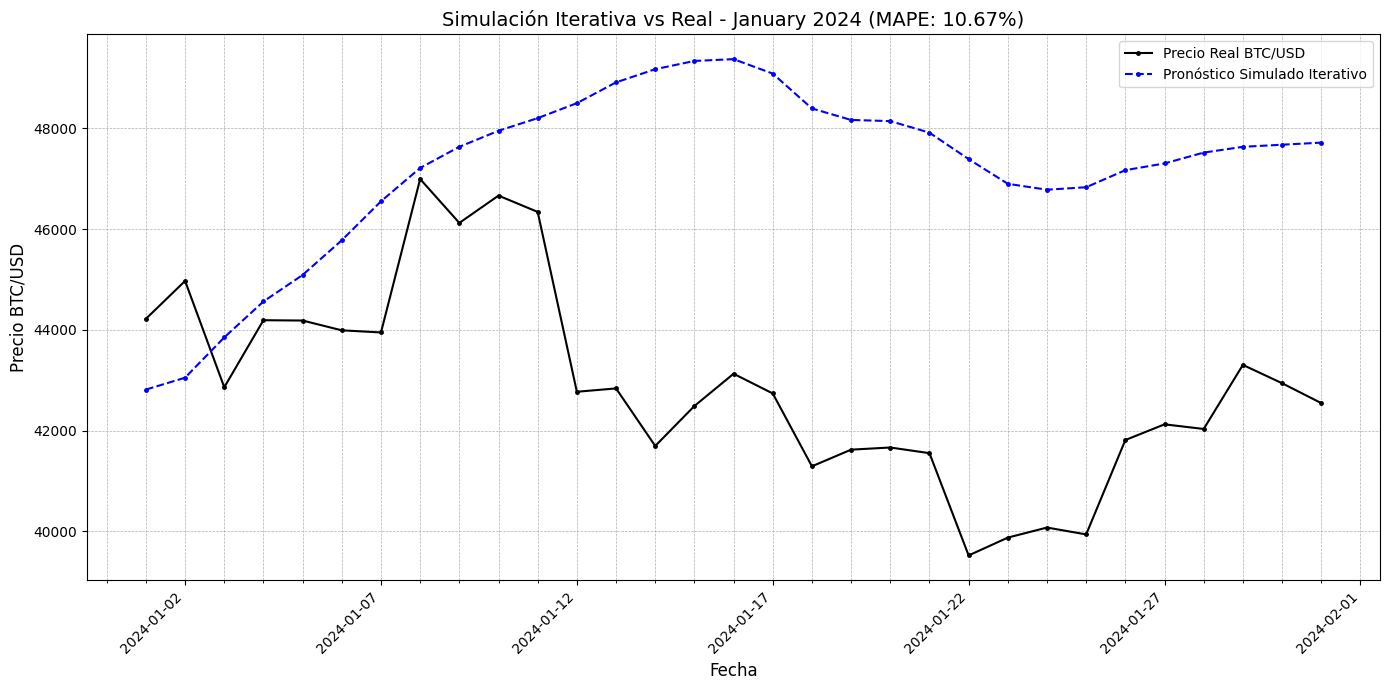



***** INICIANDO PERIODO DE SIMULACIÓN: February 2024 (2024-02-01 a 2024-02-29) *****
  Secuencia inicial obtenida (hasta 2024-01-31).
  Iniciando bucle de predicción para February 2024...
    Simulando día: 2024-02-01...
    Simulando día: 2024-02-02...
    Simulando día: 2024-02-03...
    Simulando día: 2024-02-04...
    Simulando día: 2024-02-05...
    Simulando día: 2024-02-06...
    Simulando día: 2024-02-07...
    Simulando día: 2024-02-08...
    Simulando día: 2024-02-09...
    Simulando día: 2024-02-10...
    Simulando día: 2024-02-11...
    Simulando día: 2024-02-12...
    Simulando día: 2024-02-13...
    Simulando día: 2024-02-14...
    Simulando día: 2024-02-15...
    Simulando día: 2024-02-16...
    Simulando día: 2024-02-17...
    Simulando día: 2024-02-18...
    Simulando día: 2024-02-19...
    Simulando día: 2024-02-20...
    Simulando día: 2024-02-21...
    Simulando día: 2024-02-22...
    Simulando día: 2024-02-23...
    Simulando día: 2024-02-24...
    Simulando día:

Pronostico_Iterativo_USD  Real_USD
2024-02-01              42922.557577  43078.81
2024-02-02              42905.284615  43181.66
2024-02-03              43649.726997  43010.67
2024-02-04              44211.603408  42568.55
2024-02-05              44567.632523  42657.67
2024-02-06              45057.519947  43095.79
2024-02-07              46002.641422  44343.61
2024-02-08              47419.069905  45305.20
2024-02-09              49072.381947  47160.41
2024-02-10              50846.683859  47767.06
2024-02-11              52358.096734  48316.30
2024-02-12              53792.390199  49941.81
2024-02-13              54896.790671  49725.36
2024-02-14              55007.623064  51858.59
2024-02-15              55158.659600  51934.29
2024-02-16              55581.132519  52162.64
2024-02-17              55829.458596  51666.22
2024-02-18              55743.676927  52153.63
2024-02-19              55729.663710  51787.05
2024-02-20              56012.281219  52277.52
2024-02-21              56480.469262  51851.67
2024-02-22              56851.215995  51258.70
2024-02-23              58069.679478  50747.05
2024-02-24              58726.871409  51570.65
2024-02-25              59086.852390  51731.00
2024-02-26              59323.462043  54533.48
2024-02-27              59433.661894  57077.07
2024-02-28              59690.581846  62518.90
2024-02-29              59729.191993  61179.03


Generando gráfica (Sim) para February 2024...


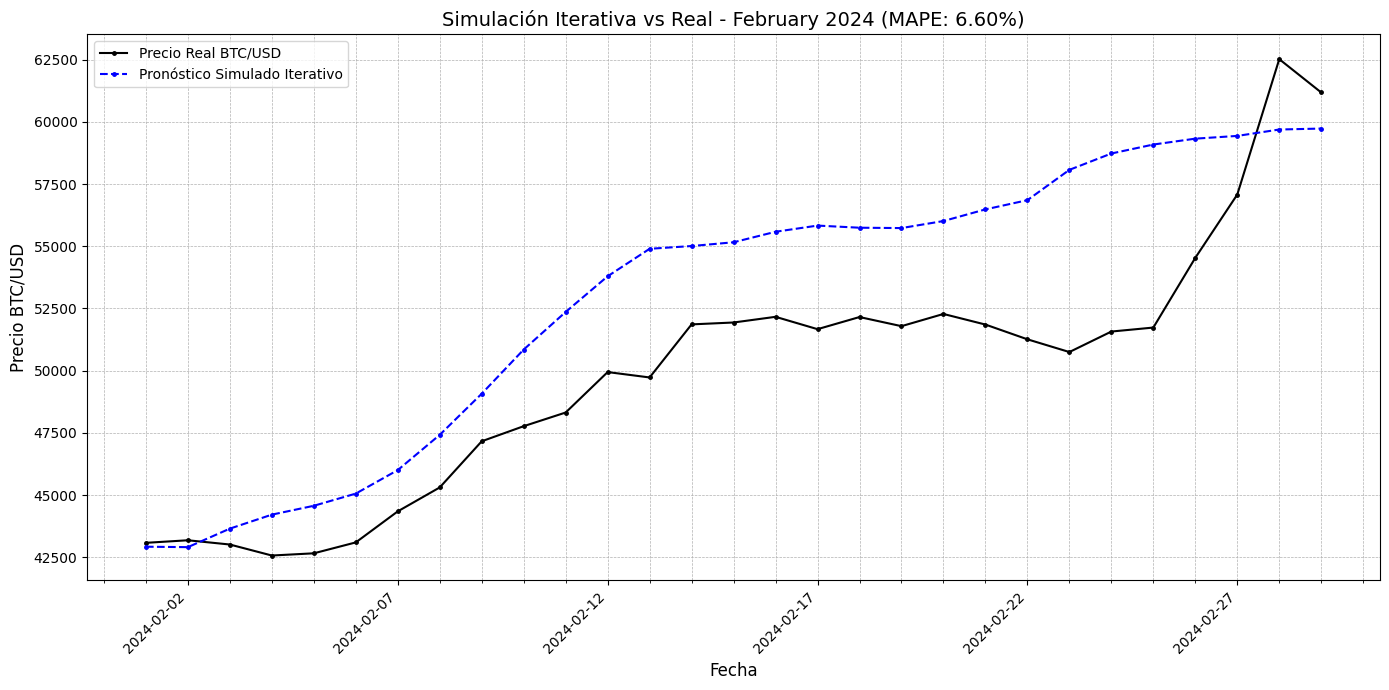



***** INICIANDO PERIODO DE SIMULACIÓN: March 2024 (2024-03-01 a 2024-03-31) *****
  Secuencia inicial obtenida (hasta 2024-02-29).
  Iniciando bucle de predicción para March 2024...
    Simulando día: 2024-03-01...
    Simulando día: 2024-03-02...
    Simulando día: 2024-03-03...
    Simulando día: 2024-03-04...
    Simulando día: 2024-03-05...
    Simulando día: 2024-03-06...
    Simulando día: 2024-03-07...
    Simulando día: 2024-03-08...
    Simulando día: 2024-03-09...
    Simulando día: 2024-03-10...
    Simulando día: 2024-03-11...
    Simulando día: 2024-03-12...
    Simulando día: 2024-03-13...
    Simulando día: 2024-03-14...
    Simulando día: 2024-03-15...
    Simulando día: 2024-03-16...
    Simulando día: 2024-03-17...
    Simulando día: 2024-03-18...
    Simulando día: 2024-03-19...
    Simulando día: 2024-03-20...
    Simulando día: 2024-03-21...
    Simulando día: 2024-03-22...
    Simulando día: 2024-03-23...
    Simulando día: 2024-03-24...
    Simulando día: 2024-

Pronostico_Iterativo_USD  Real_USD
2024-03-01              60406.486509  62436.72
2024-03-02              61960.659024  62045.78
2024-03-03              62773.142650  63154.49
2024-03-04              62986.363792  68360.14
2024-03-05              62887.017621  63800.78
2024-03-06              62091.819453  66122.28
2024-03-07              61854.342565  66938.21
2024-03-08              62171.501210  68289.16
2024-03-09              61942.951021  68480.00
2024-03-10              61663.511577  69032.12
2024-03-11              61496.618388  72110.98
2024-03-12              61430.324501  71475.93
2024-03-13              61572.177968  73135.04
2024-03-14              61659.914621  71364.58
2024-03-15              61710.687081  69506.88
2024-03-16              61237.443712  65254.22
2024-03-17              61337.940816  68343.64
2024-03-18              61377.920872  67613.04
2024-03-19              61254.771366  61906.27
2024-03-20              61429.607813  67858.80
2024-03-21              61871.880868  65484.70
2024-03-22              62281.759687  63814.56
2024-03-23              62393.796934  63998.86
2024-03-24              62412.780654  67204.93
2024-03-25              62386.809176  69890.28
2024-03-26              62395.907974  69992.40
2024-03-27              62332.953288  69435.96
2024-03-28              62470.258431  70801.18
2024-03-29              62822.559634  69903.75
2024-03-30              63170.306503  69626.87
2024-03-31              63192.899333  71288.90


Generando gráfica (Sim) para March 2024...


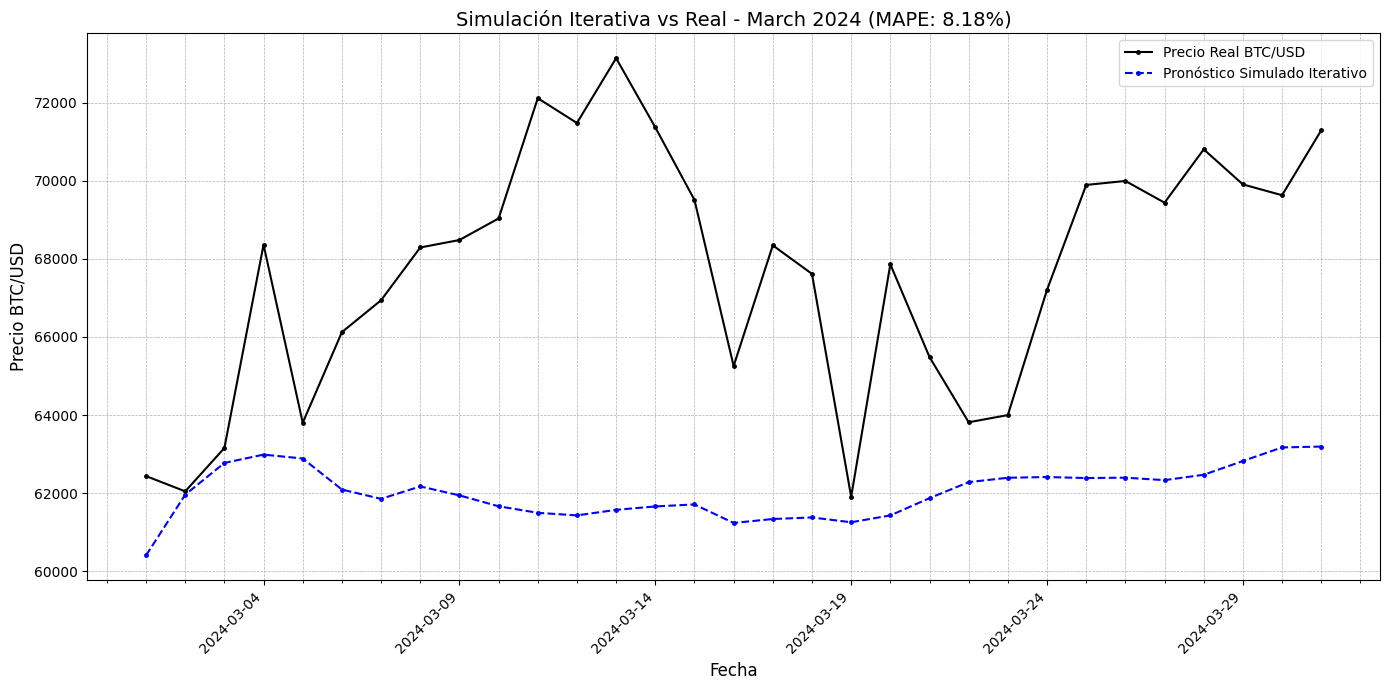



***** INICIANDO PERIODO DE SIMULACIÓN: April 2024 (2024-04-01 a 2024-04-30) *****
  Secuencia inicial obtenida (hasta 2024-03-31).
  Iniciando bucle de predicción para April 2024...
    Simulando día: 2024-04-01...
    Simulando día: 2024-04-02...
    Simulando día: 2024-04-03...
    Simulando día: 2024-04-04...
    Simulando día: 2024-04-05...
    Simulando día: 2024-04-06...
    Simulando día: 2024-04-07...
    Simulando día: 2024-04-08...
    Simulando día: 2024-04-09...
    Simulando día: 2024-04-10...
    Simulando día: 2024-04-11...
    Simulando día: 2024-04-12...
    Simulando día: 2024-04-13...
    Simulando día: 2024-04-14...
    Simulando día: 2024-04-15...
    Simulando día: 2024-04-16...
    Simulando día: 2024-04-17...
    Simulando día: 2024-04-18...
    Simulando día: 2024-04-19...
    Simulando día: 2024-04-20...
    Simulando día: 2024-04-21...
    Simulando día: 2024-04-22...
    Simulando día: 2024-04-23...
    Simulando día: 2024-04-24...
    Simulando día: 2024-

Pronostico_Iterativo_USD  Real_USD
2024-04-01              69561.662484  69681.82
2024-04-02              69124.294787  65464.14
2024-04-03              68698.913610  65987.92
2024-04-04              68341.280088  68525.23
2024-04-05              67444.549370  67856.51
2024-04-06              67377.267247  68919.89
2024-04-07              67261.578119  69350.34
2024-04-08              66972.442258  71622.53
2024-04-09              66675.155715  69117.01
2024-04-10              66559.915008  70634.04
2024-04-11              66235.455787  70020.73
2024-04-12              66487.193226  67148.61
2024-04-13              65906.426612  64024.77
2024-04-14              64892.990275  65777.05
2024-04-15              64005.876411  63452.18
2024-04-16              63144.351309  63814.94
2024-04-17              62018.027936  61279.36
2024-04-18              60157.397797  63513.85
2024-04-19              58597.793962  63848.37
2024-04-20              57004.637632  64968.87
2024-04-21              55880.352041  64952.92
2024-04-22              55061.958793  66859.17
2024-04-23              54483.492078  66414.16
2024-04-24              54537.453239  64255.78
2024-04-25              54627.687874  64484.44
2024-04-26              54591.435999  63742.39
2024-04-27              55025.948354  63422.00
2024-04-28              55210.052651  63108.94
2024-04-29              55218.829502  63844.85
2024-04-30              54867.689181  60622.10


Generando gráfica (Sim) para April 2024...


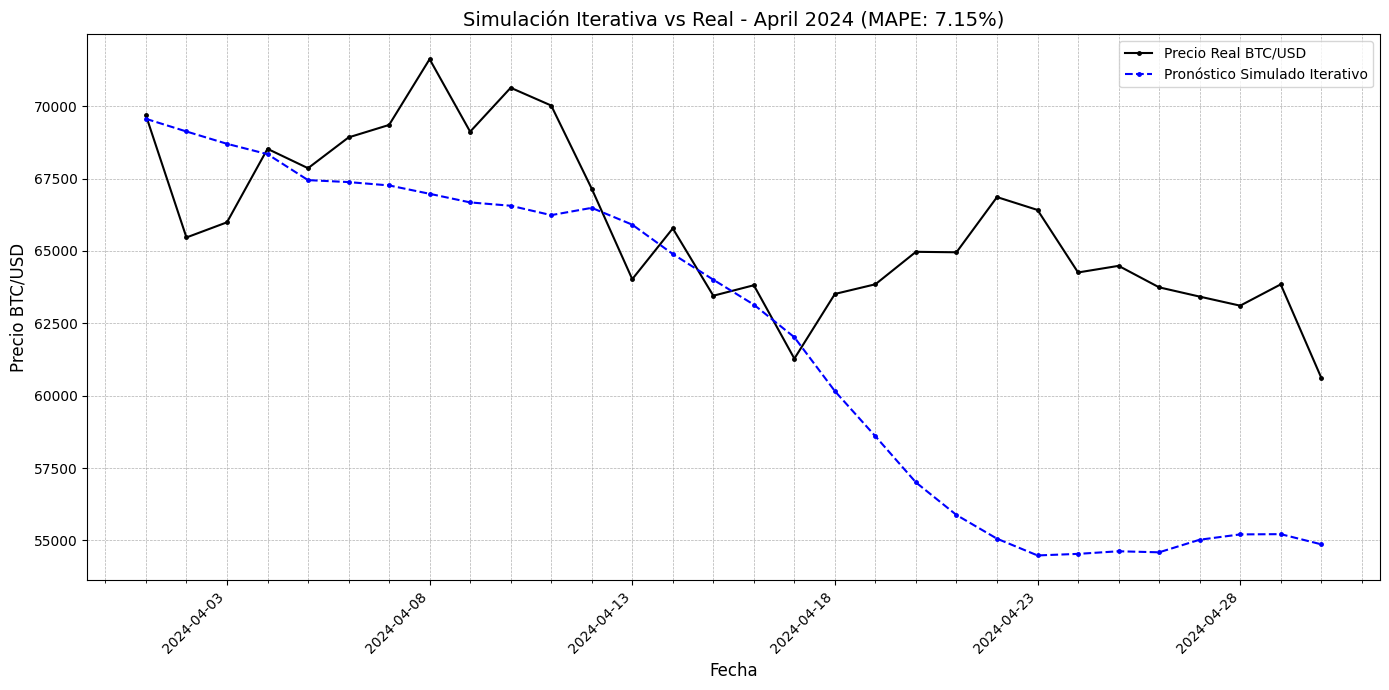



***** INICIANDO PERIODO DE SIMULACIÓN: May 2024 (2024-05-01 a 2024-05-31) *****
  Secuencia inicial obtenida (hasta 2024-04-30).
  Iniciando bucle de predicción para May 2024...
    Simulando día: 2024-05-01...
    Simulando día: 2024-05-02...
    Simulando día: 2024-05-03...
    Simulando día: 2024-05-04...
    Simulando día: 2024-05-05...
    Simulando día: 2024-05-06...
    Simulando día: 2024-05-07...
    Simulando día: 2024-05-08...
    Simulando día: 2024-05-09...
    Simulando día: 2024-05-10...
    Simulando día: 2024-05-11...
    Simulando día: 2024-05-12...
    Simulando día: 2024-05-13...
    Simulando día: 2024-05-14...
    Simulando día: 2024-05-15...
    Simulando día: 2024-05-16...
    Simulando día: 2024-05-17...
    Simulando día: 2024-05-18...
    Simulando día: 2024-05-19...
    Simulando día: 2024-05-20...
    Simulando día: 2024-05-21...
    Simulando día: 2024-05-22...
    Simulando día: 2024-05-23...
    Simulando día: 2024-05-24...
    Simulando día: 2024-05-2

Pronostico_Iterativo_USD  Real_USD
2024-05-01              59743.705553  58265.59
2024-05-02              57291.364646  59071.89
2024-05-03              55632.026758  62913.03
2024-05-04              54601.850374  63902.88
2024-05-05              53949.971016  64023.45
2024-05-06              52998.949048  63162.24
2024-05-07              52348.354610  62315.76
2024-05-08              52384.430916  61169.53
2024-05-09              52763.597643  63073.57
2024-05-10              53477.453796  60787.47
2024-05-11              54224.101031  60814.63
2024-05-12              54936.546012  61453.02
2024-05-13              55650.576294  62932.37
2024-05-14              56173.759908  61539.84
2024-05-15              56472.381317  66244.69
2024-05-16              57158.273245  65252.18
2024-05-17              57556.496919  67046.33
2024-05-18              57991.178333  66923.87
2024-05-19              58434.289465  66261.62
2024-05-20              58643.513472  71432.17
2024-05-21              58648.388448  70142.84
2024-05-22              58574.007936  69109.93
2024-05-23              58176.786711  67940.45
2024-05-24              57406.093853  68547.80
2024-05-25              57320.915698  69289.67
2024-05-26              57792.439520  68473.72
2024-05-27              58086.178554  69368.72
2024-05-28              58318.066665  68321.98
2024-05-29              58456.347841  67569.45
2024-05-30              58173.461012  68338.58
2024-05-31              57494.266055  67472.41


Generando gráfica (Sim) para May 2024...


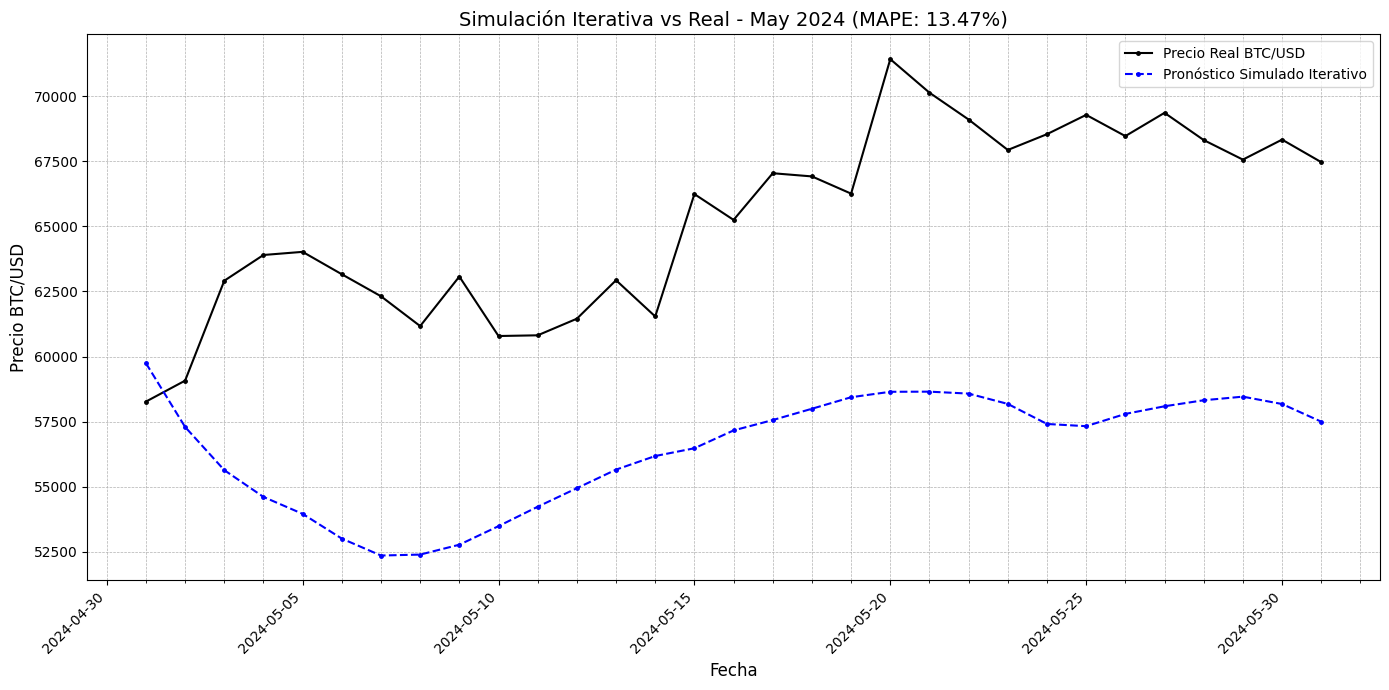



***** INICIANDO PERIODO DE SIMULACIÓN: June 2024 (2024-06-01 a 2024-06-30) *****
  Secuencia inicial obtenida (hasta 2024-05-31).
  Iniciando bucle de predicción para June 2024...
    Simulando día: 2024-06-01...
    Simulando día: 2024-06-02...
    Simulando día: 2024-06-03...
    Simulando día: 2024-06-04...
    Simulando día: 2024-06-05...
    Simulando día: 2024-06-06...
    Simulando día: 2024-06-07...
    Simulando día: 2024-06-08...
    Simulando día: 2024-06-09...
    Simulando día: 2024-06-10...
    Simulando día: 2024-06-11...
    Simulando día: 2024-06-12...
    Simulando día: 2024-06-13...
    Simulando día: 2024-06-14...
    Simulando día: 2024-06-15...
    Simulando día: 2024-06-16...
    Simulando día: 2024-06-17...
    Simulando día: 2024-06-18...
    Simulando día: 2024-06-19...
    Simulando día: 2024-06-20...
    Simulando día: 2024-06-21...
    Simulando día: 2024-06-22...
    Simulando día: 2024-06-23...
    Simulando día: 2024-06-24...
    Simulando día: 2024-06

Pronostico_Iterativo_USD  Real_USD
2024-06-01              65489.214115  67719.29
2024-06-02              64781.547843  67735.52
2024-06-03              64225.851095  68791.00
2024-06-04              63713.135122  70542.32
2024-06-05              63163.194935  71121.11
2024-06-06              63607.855938  70773.64
2024-06-07              64042.962788  69324.53
2024-06-08              63791.473906  69304.05
2024-06-09              63978.868793  69637.87
2024-06-10              64003.636230  69497.73
2024-06-11              63815.498728  67316.53
2024-06-12              63805.281025  68248.60
2024-06-13              64154.594157  66738.85
2024-06-14              64380.957166  66004.39
2024-06-15              64688.803346  66192.00
2024-06-16              65267.710701  66628.75
2024-06-17              65477.181502  66481.81
2024-06-18              65461.905179  65152.80
2024-06-19              65610.369978  64943.79
2024-06-20              65666.961801  64840.88
2024-06-21              65579.376206  64120.28
2024-06-22              64976.569969  64235.01
2024-06-23              64265.239215  63171.43
2024-06-24              63813.488559  60263.00
2024-06-25              63196.419824  61789.71
2024-06-26              62446.630773  60816.68
2024-06-27              61495.775372  61615.39
2024-06-28              60644.099915  60313.35
2024-06-29              59374.700403  60885.67
2024-06-30              58385.855044  62668.26


Generando gráfica (Sim) para June 2024...


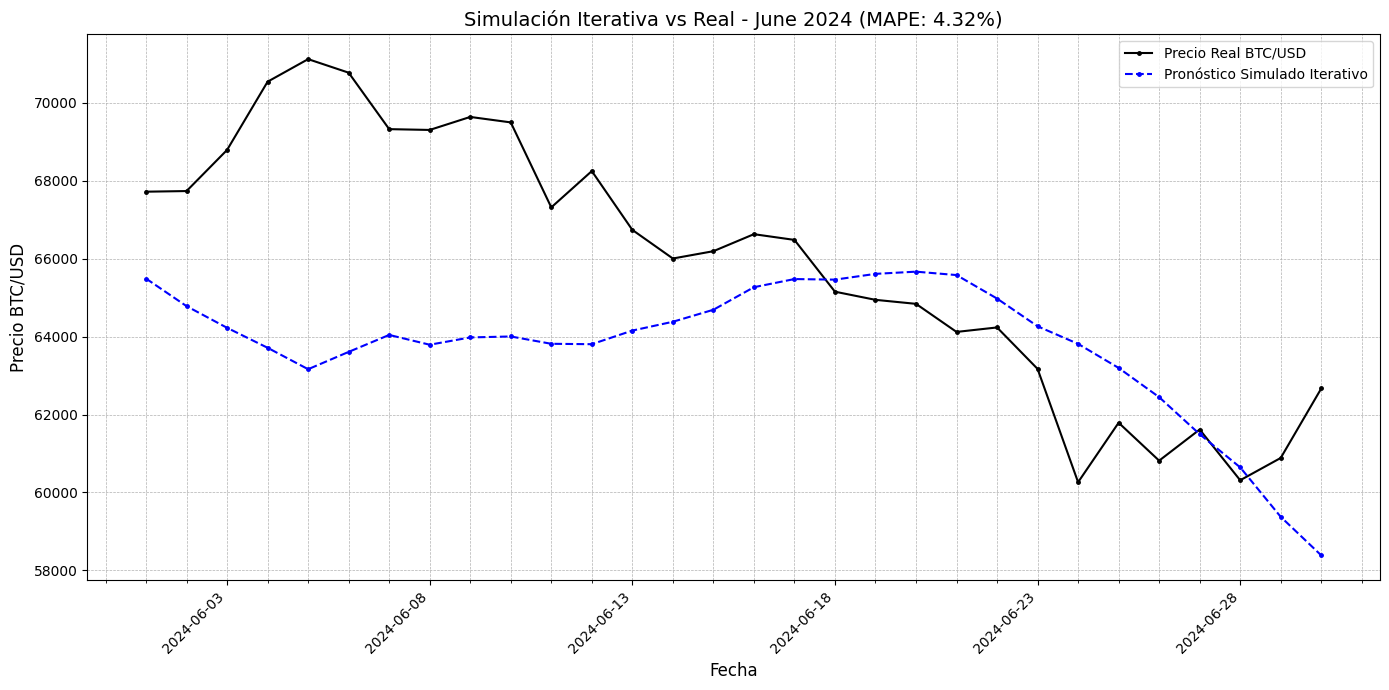



***** INICIANDO PERIODO DE SIMULACIÓN: July 2024 (2024-07-01 a 2024-07-31) *****
  Secuencia inicial obtenida (hasta 2024-06-30).
  Iniciando bucle de predicción para July 2024...
    Simulando día: 2024-07-01...
    Simulando día: 2024-07-02...
    Simulando día: 2024-07-03...
    Simulando día: 2024-07-04...
    Simulando día: 2024-07-05...
    Simulando día: 2024-07-06...
    Simulando día: 2024-07-07...
    Simulando día: 2024-07-08...
    Simulando día: 2024-07-09...
    Simulando día: 2024-07-10...
    Simulando día: 2024-07-11...
    Simulando día: 2024-07-12...
    Simulando día: 2024-07-13...
    Simulando día: 2024-07-14...
    Simulando día: 2024-07-15...
    Simulando día: 2024-07-16...
    Simulando día: 2024-07-17...
    Simulando día: 2024-07-18...
    Simulando día: 2024-07-19...
    Simulando día: 2024-07-20...
    Simulando día: 2024-07-21...
    Simulando día: 2024-07-22...
    Simulando día: 2024-07-23...
    Simulando día: 2024-07-24...
    Simulando día: 2024-07

Pronostico_Iterativo_USD  Real_USD
2024-07-01              58826.765666  62830.13
2024-07-02              58231.110734  62040.22
2024-07-03              57774.844290  60145.01
2024-07-04              57628.627249  57042.14
2024-07-05              57610.191323  56639.43
2024-07-06              57335.094914  58244.75
2024-07-07              56828.569892  55854.09
2024-07-08              56345.185813  56699.43
2024-07-09              56174.562735  58047.86
2024-07-10              56523.712466  57712.59
2024-07-11              57598.211974  57340.77
2024-07-12              58189.174915  57909.03
2024-07-13              59027.684021  59224.58
2024-07-14              60136.048083  60808.42
2024-07-15              61292.194380  64757.16
2024-07-16              62163.504864  65088.99
2024-07-17              62719.117895  64085.81
2024-07-18              62194.807084  63982.86
2024-07-19              61645.708696  66707.61
2024-07-20              60660.728890  67163.83
2024-07-21              60602.794881  68181.28
2024-07-22              60727.467522  67558.22
2024-07-23              60531.408539  65939.24
2024-07-24              59476.095602  65366.40
2024-07-25              57234.828916  65795.42
2024-07-26              55095.839413  67924.08
2024-07-27              53869.481057  67899.41
2024-07-28              52755.395688  68244.30
2024-07-29              51613.473384  66771.45
2024-07-30              51358.982311  66169.68
2024-07-31              51637.023250  64609.62


Generando gráfica (Sim) para July 2024...


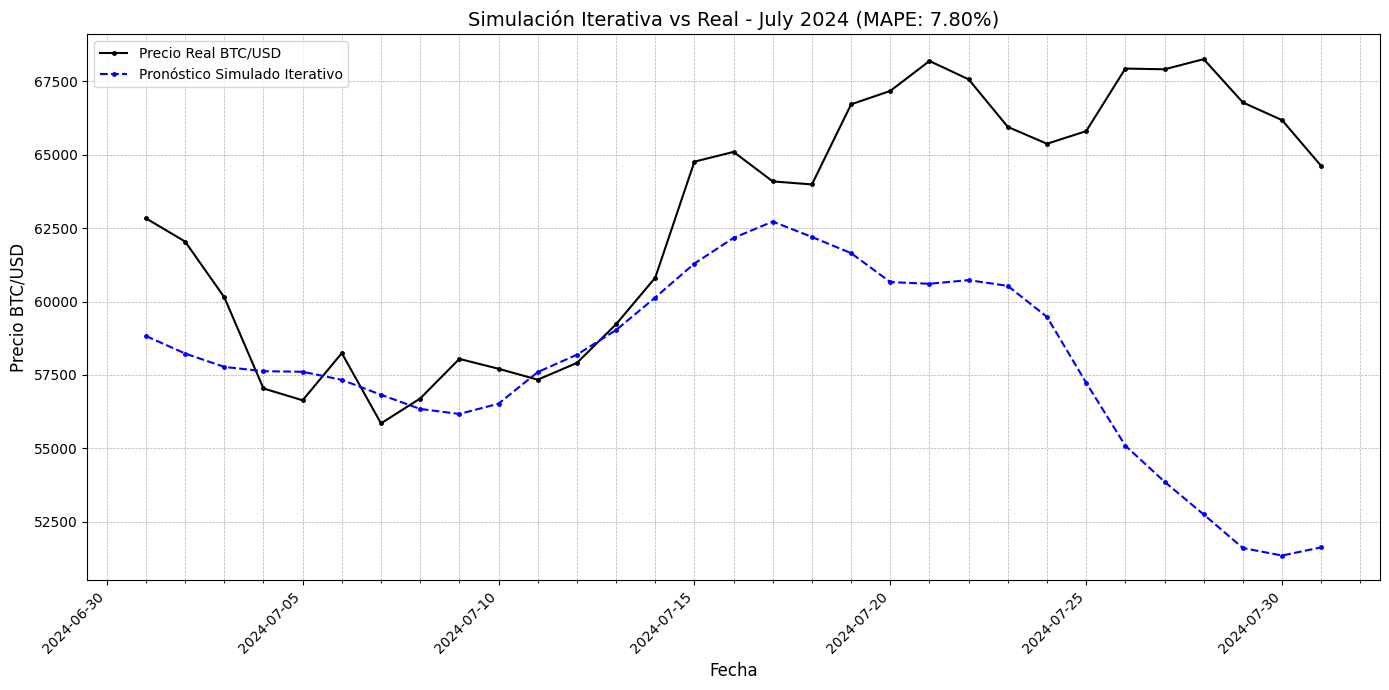



***** INICIANDO PERIODO DE SIMULACIÓN: August 2024 (2024-08-01 a 2024-08-31) *****
  Secuencia inicial obtenida (hasta 2024-07-31).
  Iniciando bucle de predicción para August 2024...
    Simulando día: 2024-08-01...
    Simulando día: 2024-08-02...
    Simulando día: 2024-08-03...
    Simulando día: 2024-08-04...
    Simulando día: 2024-08-05...
    Simulando día: 2024-08-06...
    Simulando día: 2024-08-07...
    Simulando día: 2024-08-08...
    Simulando día: 2024-08-09...
    Simulando día: 2024-08-10...
    Simulando día: 2024-08-11...
    Simulando día: 2024-08-12...
    Simulando día: 2024-08-13...
    Simulando día: 2024-08-14...
    Simulando día: 2024-08-15...
    Simulando día: 2024-08-16...
    Simulando día: 2024-08-17...
    Simulando día: 2024-08-18...
    Simulando día: 2024-08-19...
    Simulando día: 2024-08-20...
    Simulando día: 2024-08-21...
    Simulando día: 2024-08-22...
    Simulando día: 2024-08-23...
    Simulando día: 2024-08-24...
    Simulando día: 202

Pronostico_Iterativo_USD  Real_USD
2024-08-01              66764.866882  65288.18
2024-08-02              67353.630247  61418.06
2024-08-03              66809.455940  60674.93
2024-08-04              65694.126350  58130.95
2024-08-05              65910.867235  54029.12
2024-08-06              65516.286026  56048.08
2024-08-07              64710.542573  55148.10
2024-08-08              63429.169414  61705.58
2024-08-09              63168.335081  60862.13
2024-08-10              62506.473270  60935.02
2024-08-11              61696.649408  58722.49
2024-08-12              60222.476062  59358.78
2024-08-13              59065.072915  60603.19
2024-08-14              58743.077469  58690.62
2024-08-15              58209.578775  57543.61
2024-08-16              58594.580917  58888.99
2024-08-17              58687.847893  59497.49
2024-08-18              58533.003148  58437.90
2024-08-19              58211.870836  59452.67
2024-08-20              57861.270769  59017.59
2024-08-21              57395.797493  61163.28
2024-08-22              56865.461468  60383.29
2024-08-23              56050.048795  64086.72
2024-08-24              56107.819803  64179.63
2024-08-25              56227.476325  64251.93
2024-08-26              56228.821123  62840.00
2024-08-27              56189.736693  59439.64
2024-08-28              56002.545202  59045.88
2024-08-29              55399.571729  59364.47
2024-08-30              55169.150002  59112.77
2024-08-31              55107.234023  58968.37


Generando gráfica (Sim) para August 2024...


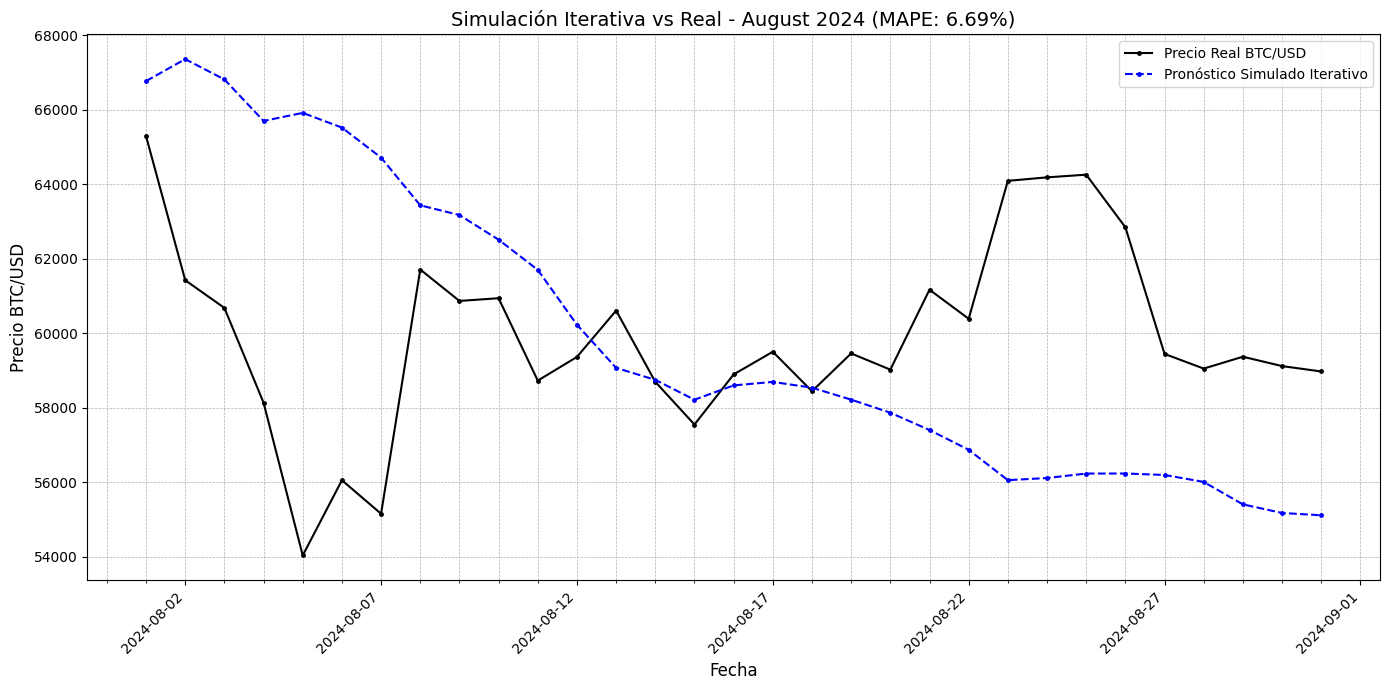



***** INICIANDO PERIODO DE SIMULACIÓN: September 2024 (2024-09-01 a 2024-09-30) *****
  Secuencia inicial obtenida (hasta 2024-08-31).
  Iniciando bucle de predicción para September 2024...
    Simulando día: 2024-09-01...
    Simulando día: 2024-09-02...
    Simulando día: 2024-09-03...
    Simulando día: 2024-09-04...
    Simulando día: 2024-09-05...
    Simulando día: 2024-09-06...
    Simulando día: 2024-09-07...
    Simulando día: 2024-09-08...
    Simulando día: 2024-09-09...
    Simulando día: 2024-09-10...
    Simulando día: 2024-09-11...
    Simulando día: 2024-09-12...
    Simulando día: 2024-09-13...
    Simulando día: 2024-09-14...
    Simulando día: 2024-09-15...
    Simulando día: 2024-09-16...
    Simulando día: 2024-09-17...
    Simulando día: 2024-09-18...
    Simulando día: 2024-09-19...
    Simulando día: 2024-09-20...
    Simulando día: 2024-09-21...
    Simulando día: 2024-09-22...
    Simulando día: 2024-09-23...
    Simulando día: 2024-09-24...
    Simulando dí

Pronostico_Iterativo_USD  Real_USD
2024-09-01              56917.116710  57299.00
2024-09-02              55808.391471  59139.83
2024-09-03              55117.023377  57468.84
2024-09-04              54620.900762  57971.00
2024-09-05              54004.758382  56156.82
2024-09-06              53621.536227  53950.01
2024-09-07              52442.629951  54156.33
2024-09-08              52208.713492  54881.11
2024-09-09              52120.376646  57053.90
2024-09-10              51973.824197  57645.59
2024-09-11              51820.458640  57352.79
2024-09-12              52325.975969  58137.54
2024-09-13              53147.772014  60543.35
2024-09-14              53746.094592  60012.35
2024-09-15              53996.174504  59122.33
2024-09-16              54074.803376  58208.75
2024-09-17              54104.352247  60312.60
2024-09-18              54156.389901  61769.18
2024-09-19              53916.291812  62960.14
2024-09-20              54300.923654  63210.69
2024-09-21              55416.993126  63362.74
2024-09-22              56119.292759  63577.66
2024-09-23              56515.453490  63338.87
2024-09-24              56706.956067  64272.93
2024-09-25              57246.064809  63130.89
2024-09-26              57582.691249  65177.21
2024-09-27              57862.182097  65789.00
2024-09-28              57924.523976  65858.99
2024-09-29              58143.165187  65600.01
2024-09-30              58392.582010  63301.25


Generando gráfica (Sim) para September 2024...


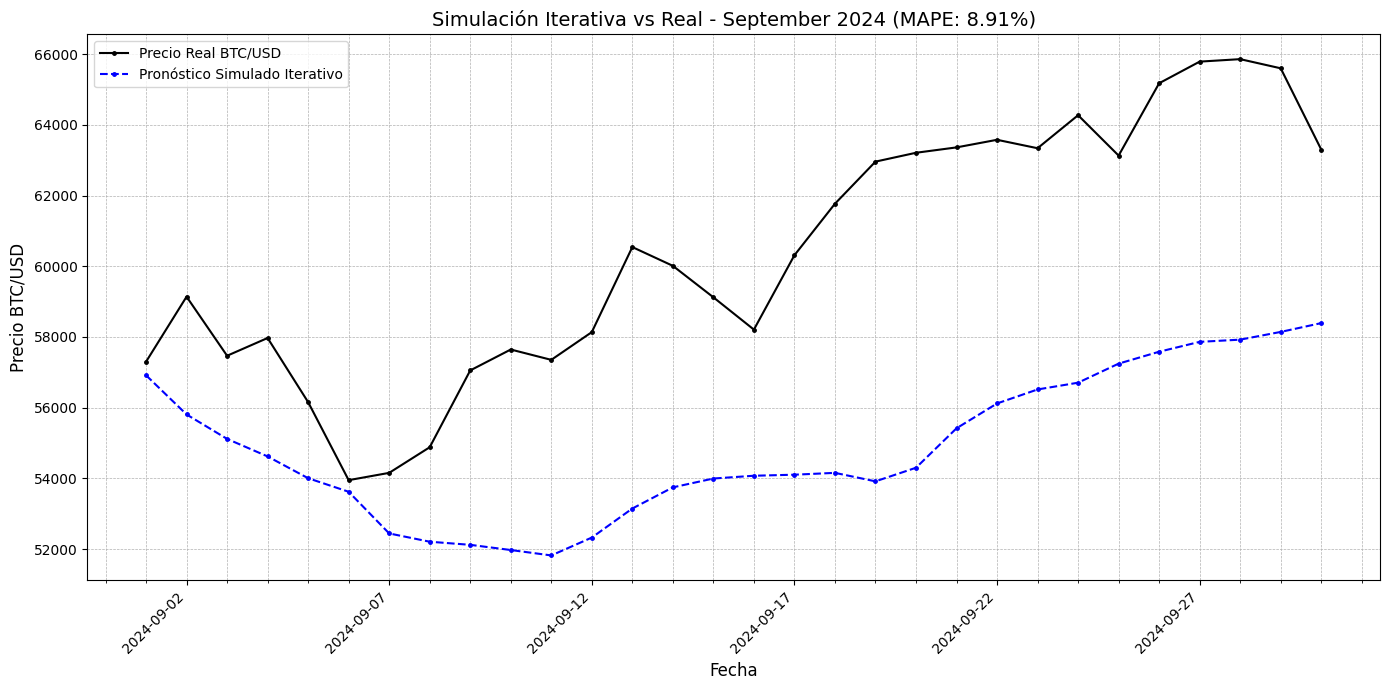



***** INICIANDO PERIODO DE SIMULACIÓN: October 2024 (2024-10-01 a 2024-10-31) *****
  Secuencia inicial obtenida (hasta 2024-09-30).
  Iniciando bucle de predicción para October 2024...
    Simulando día: 2024-10-01...
    Simulando día: 2024-10-02...
    Simulando día: 2024-10-03...
    Simulando día: 2024-10-04...
    Simulando día: 2024-10-05...
    Simulando día: 2024-10-06...
    Simulando día: 2024-10-07...
    Simulando día: 2024-10-08...
    Simulando día: 2024-10-09...
    Simulando día: 2024-10-10...
    Simulando día: 2024-10-11...
    Simulando día: 2024-10-12...
    Simulando día: 2024-10-13...
    Simulando día: 2024-10-14...
    Simulando día: 2024-10-15...
    Simulando día: 2024-10-16...
    Simulando día: 2024-10-17...
    Simulando día: 2024-10-18...
    Simulando día: 2024-10-19...
    Simulando día: 2024-10-20...
    Simulando día: 2024-10-21...
    Simulando día: 2024-10-22...
    Simulando día: 2024-10-23...
    Simulando día: 2024-10-24...
    Simulando día: 2

Pronostico_Iterativo_USD  Real_USD
2024-10-01              64648.495663  60790.00
2024-10-02              64177.464143  60631.37
2024-10-03              63927.609952  60744.99
2024-10-04              64019.356486  62090.71
2024-10-05              64441.694741  62051.29
2024-10-06              64332.340777  62810.86
2024-10-07              63971.927419  62200.28
2024-10-08              63866.481397  62122.02
2024-10-09              64260.197237  60578.28
2024-10-10              65110.962029  60279.53
2024-10-11              66322.486135  62518.75
2024-10-12              67619.852714  63187.47
2024-10-13              68531.605764  62845.30
2024-10-14              69409.560478  66065.65
2024-10-15              69665.477255  67056.60
2024-10-16              68566.514592  67608.44
2024-10-17              67421.616358  67402.33
2024-10-18              66431.580217  68426.11
2024-10-19              65456.616582  68363.73
2024-10-20              64506.101880  69014.86
2024-10-21              63308.828323  67346.15
2024-10-22              62677.532970  67380.08
2024-10-23              63135.751054  66601.11
2024-10-24              62925.034067  68156.84
2024-10-25              63172.130583  66564.51
2024-10-26              64031.905588  67012.56
2024-10-27              64423.747431  67943.19
2024-10-28              64930.192964  69924.50
2024-10-29              65254.329388  72724.35
2024-10-30              65948.307235  72322.91
2024-10-31              66457.161461  70197.83


Generando gráfica (Sim) para October 2024...


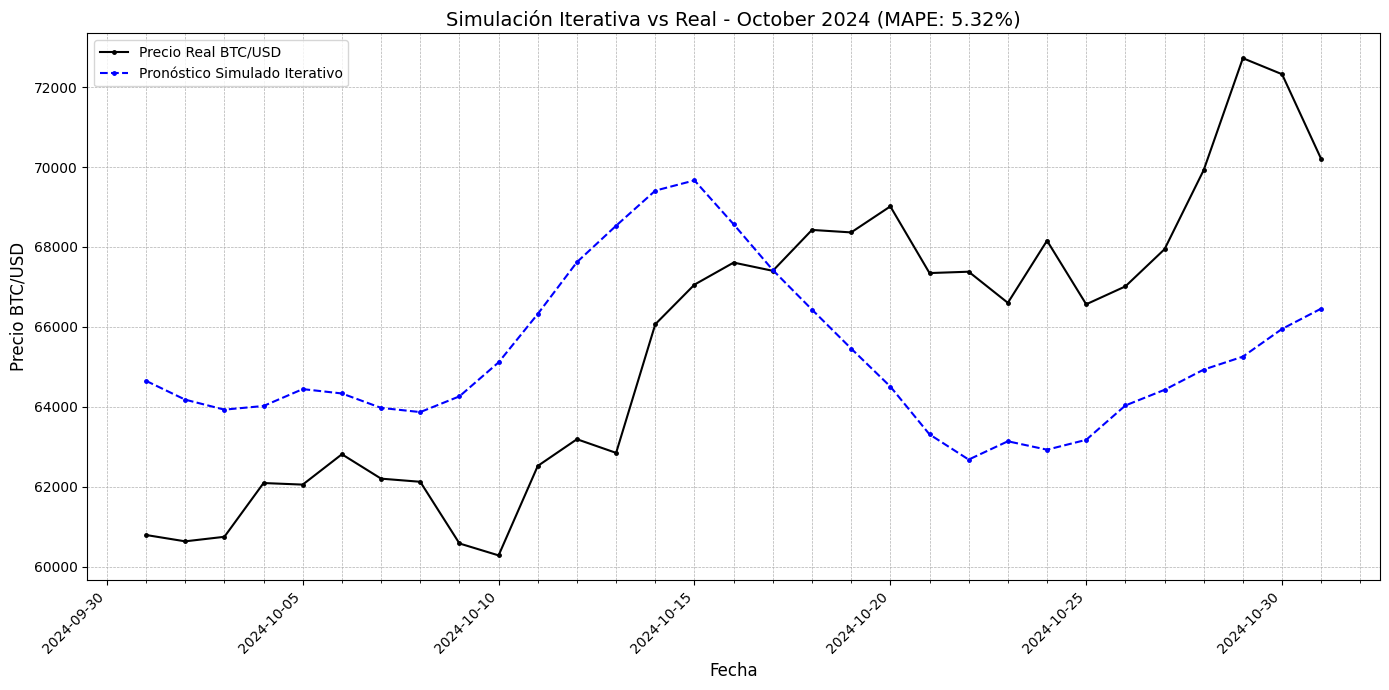



***** INICIANDO PERIODO DE SIMULACIÓN: November 2024 (2024-11-01 a 2024-11-30) *****
  Secuencia inicial obtenida (hasta 2024-10-31).
  Iniciando bucle de predicción para November 2024...
    Simulando día: 2024-11-01...
    Simulando día: 2024-11-02...
    Simulando día: 2024-11-03...
    Simulando día: 2024-11-04...
    Simulando día: 2024-11-05...
    Simulando día: 2024-11-06...
    Simulando día: 2024-11-07...
    Simulando día: 2024-11-08...
    Simulando día: 2024-11-09...
    Simulando día: 2024-11-10...
    Simulando día: 2024-11-11...
    Simulando día: 2024-11-12...
    Simulando día: 2024-11-13...
    Simulando día: 2024-11-14...
    Simulando día: 2024-11-15...
    Simulando día: 2024-11-16...
    Simulando día: 2024-11-17...
    Simulando día: 2024-11-18...
    Simulando día: 2024-11-19...
    Simulando día: 2024-11-20...
    Simulando día: 2024-11-21...
    Simulando día: 2024-11-22...
    Simulando día: 2024-11-23...
    Simulando día: 2024-11-24...
    Simulando día:

Pronostico_Iterativo_USD  Real_USD
2024-11-01              70659.982639  69467.29
2024-11-02              70153.826394  69358.94
2024-11-03              70184.812190  68738.18
2024-11-04              70223.369104  67807.48
2024-11-05              70342.264923  69380.73
2024-11-06              70934.887517  75646.55
2024-11-07              72019.297190  75920.00
2024-11-08              73240.560467  76566.73
2024-11-09              73105.719852  76716.06
2024-11-10              72494.474807  80428.92
2024-11-11              71757.789273  88770.73
2024-11-12              70937.308226  88035.43
2024-11-13              69710.722538  90493.82
2024-11-14              68592.197722  87340.40
2024-11-15              67443.585476  91058.36
2024-11-16              65400.320486  90636.24
2024-11-17              64585.170772  89886.69
2024-11-18              64004.513625  90520.30
2024-11-19              63424.655504  92435.89
2024-11-20              63257.146893  94393.15
2024-11-21              63040.655521  98439.09
2024-11-22              63100.662370  99024.03
2024-11-23              63349.575642  97778.77
2024-11-24              62573.490488  98028.18
2024-11-25              61821.300349  93000.01
2024-11-26              61401.215802  91929.54
2024-11-27              61324.846481  95951.19
2024-11-28              60822.657044  95665.53
2024-11-29              60663.630582  97490.56
2024-11-30              60504.014016  96465.42


Generando gráfica (Sim) para November 2024...


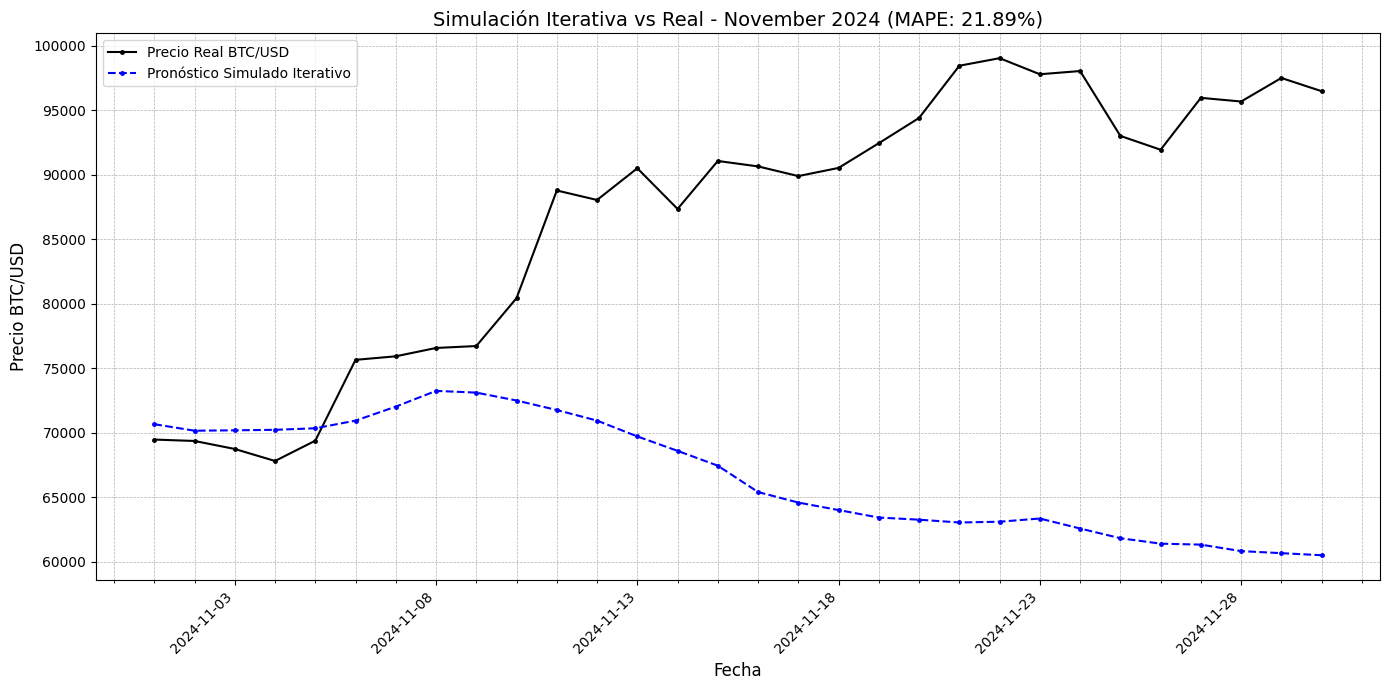



***** INICIANDO PERIODO DE SIMULACIÓN: December 2024 (2024-12-01 a 2024-12-31) *****
  Secuencia inicial obtenida (hasta 2024-11-30).
  Iniciando bucle de predicción para December 2024...
    Simulando día: 2024-12-01...
    Simulando día: 2024-12-02...
    Simulando día: 2024-12-03...
    Simulando día: 2024-12-04...
    Simulando día: 2024-12-05...
    Simulando día: 2024-12-06...
    Simulando día: 2024-12-07...
    Simulando día: 2024-12-08...
    Simulando día: 2024-12-09...
    Simulando día: 2024-12-10...
    Simulando día: 2024-12-11...
    Simulando día: 2024-12-12...
    Simulando día: 2024-12-13...
    Simulando día: 2024-12-14...
    Simulando día: 2024-12-15...
    Simulando día: 2024-12-16...
    Simulando día: 2024-12-17...
    Simulando día: 2024-12-18...
    Simulando día: 2024-12-19...
    Simulando día: 2024-12-20...
    Simulando día: 2024-12-21...
    Simulando día: 2024-12-22...
    Simulando día: 2024-12-23...
    Simulando día: 2024-12-24...
    Simulando día:

Pronostico_Iterativo_USD   Real_USD
2024-12-01              91511.462153   97263.18
2024-12-02              90194.408416   95862.89
2024-12-03              88639.447623   95924.52
2024-12-04              87064.531638   98746.24
2024-12-05              85774.319851   97044.23
2024-12-06              83947.573748   99891.35
2024-12-07              82710.499683   99929.32
2024-12-08              81382.868197  101174.99
2024-12-09              80117.664023   97324.81
2024-12-10              78963.233569   96660.76
2024-12-11              78170.160153  101202.11
2024-12-12              78595.778045  100030.47
2024-12-13              77971.735190  101428.75
2024-12-14              77359.415870  101399.99
2024-12-15              77208.209187  104447.76
2024-12-16              76805.673034  106099.81
2024-12-17              76142.724552  106136.99
2024-12-18              75065.884958  100150.73
2024-12-19              72451.099572   97372.21
2024-12-20              70238.117653   97765.00
2024-12-21              69792.527168   97230.08
2024-12-22              69758.621841   95087.75
2024-12-23              69436.126453   94764.56
2024-12-24              69085.474874   98594.47
2024-12-25              69267.972763   99346.28
2024-12-26              68949.193582   95669.49
2024-12-27              68259.305001   94171.89
2024-12-28              66921.439528   95130.82
2024-12-29              65318.157969   93563.35
2024-12-30              64191.879041   92620.71
2024-12-31              63425.857948   93354.22


Generando gráfica (Sim) para December 2024...


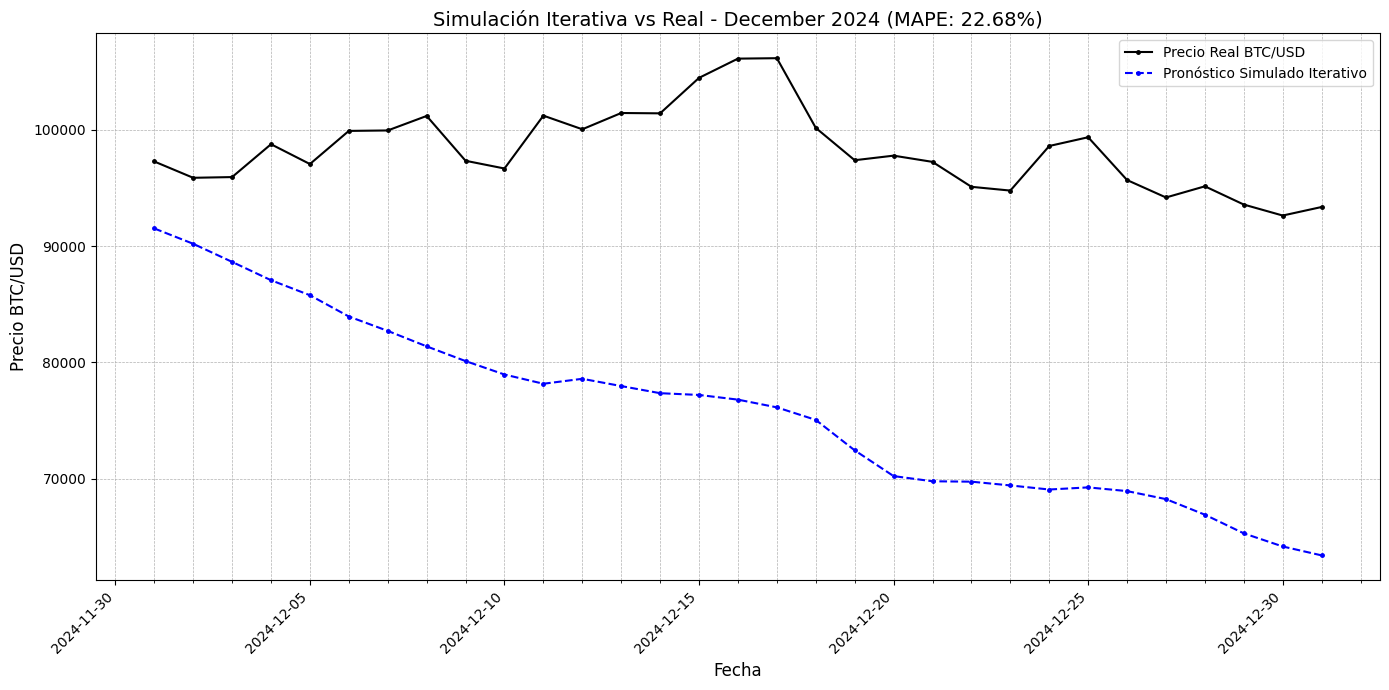



***** INICIANDO PERIODO DE SIMULACIÓN: January 2025 (2025-01-01 a 2025-01-31) *****
  Secuencia inicial obtenida (hasta 2024-12-31).
  Iniciando bucle de predicción para January 2025...
    Simulando día: 2025-01-01...
    Simulando día: 2025-01-02...
    Simulando día: 2025-01-03...
    Simulando día: 2025-01-04...
    Simulando día: 2025-01-05...
    Simulando día: 2025-01-06...
    Simulando día: 2025-01-07...
    Simulando día: 2025-01-08...
    Simulando día: 2025-01-09...
    Simulando día: 2025-01-10...
    Simulando día: 2025-01-11...
    Simulando día: 2025-01-12...
    Simulando día: 2025-01-13...
    Simulando día: 2025-01-14...
    Simulando día: 2025-01-15...
    Simulando día: 2025-01-16...
    Simulando día: 2025-01-17...
    Simulando día: 2025-01-18...
    Simulando día: 2025-01-19...
    Simulando día: 2025-01-20...
    Simulando día: 2025-01-21...
    Simulando día: 2025-01-22...
    Simulando día: 2025-01-23...
    Simulando día: 2025-01-24...
    Simulando día: 2

Pronostico_Iterativo_USD   Real_USD
2025-01-01              87180.557801   94383.59
2025-01-02              86108.404257   96903.19
2025-01-03              84638.820593   98136.51
2025-01-04              83495.994137   98209.85
2025-01-05              82431.902959   98345.33
2025-01-06              81141.869757  102279.41
2025-01-07              79794.579727   96941.98
2025-01-08              78076.919132   95036.63
2025-01-09              76761.912396   92547.44
2025-01-10              75566.298938   94701.18
2025-01-11              74467.545053   94565.02
2025-01-12              73525.247823   94509.62
2025-01-13              72633.335743   94506.45
2025-01-14              72120.237524   96534.96
2025-01-15              71975.156613  100510.23
2025-01-16              73551.393924   99981.78
2025-01-17              74529.515801  104107.00
2025-01-18              75802.587066  104435.00
2025-01-19              77038.084162  101211.13
2025-01-20              78080.949982  102145.43
2025-01-21              78324.324443  106159.26
2025-01-22              77366.546203  103667.11
2025-01-23              76641.375028  103926.36
2025-01-24              75660.381417  104850.27
2025-01-25              74301.443500  104733.56
2025-01-26              71473.295113  102563.00
2025-01-27              69376.245892  102062.42
2025-01-28              68245.668637  101290.00
2025-01-29              68751.611898  103747.25
2025-01-30              68891.702083  104742.64
2025-01-31              69268.599067  102411.26


Generando gráfica (Sim) para January 2025...


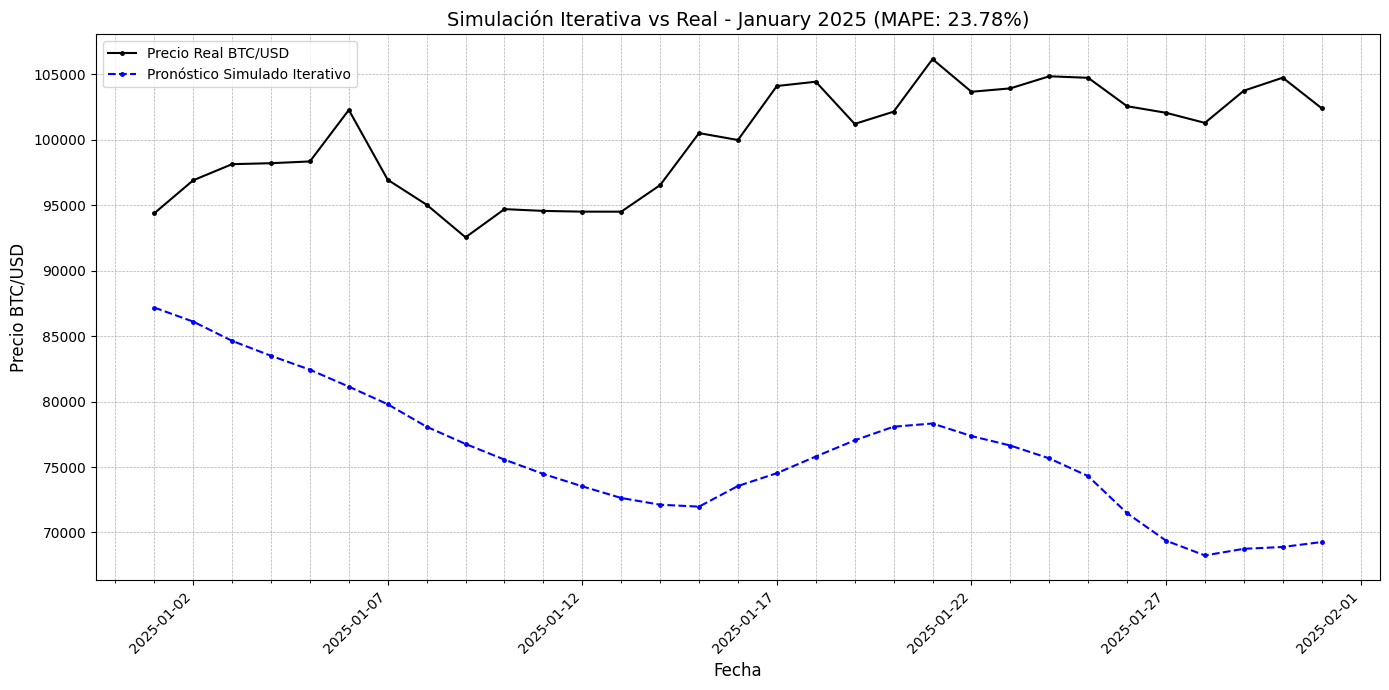



***** INICIANDO PERIODO DE SIMULACIÓN: February 2025 (2025-02-01 a 2025-02-28) *****
  Secuencia inicial obtenida (hasta 2025-01-31).
  Iniciando bucle de predicción para February 2025...
    Simulando día: 2025-02-01...
    Simulando día: 2025-02-02...
    Simulando día: 2025-02-03...
    Simulando día: 2025-02-04...
    Simulando día: 2025-02-05...
    Simulando día: 2025-02-06...
    Simulando día: 2025-02-07...
    Simulando día: 2025-02-08...
    Simulando día: 2025-02-09...
    Simulando día: 2025-02-10...
    Simulando día: 2025-02-11...
    Simulando día: 2025-02-12...
    Simulando día: 2025-02-13...
    Simulando día: 2025-02-14...
    Simulando día: 2025-02-15...
    Simulando día: 2025-02-16...
    Simulando día: 2025-02-17...
    Simulando día: 2025-02-18...
    Simulando día: 2025-02-19...
    Simulando día: 2025-02-20...
    Simulando día: 2025-02-21...
    Simulando día: 2025-02-22...
    Simulando día: 2025-02-23...
    Simulando día: 2025-02-24...
    Simulando día:

Pronostico_Iterativo_USD   Real_USD
2025-02-01              99458.333755  100623.85
2025-02-02              97527.007861   97676.52
2025-02-03              95449.935495  101460.20
2025-02-04              93267.851636   97795.05
2025-02-05              91670.438290   96638.33
2025-02-06              90114.050445   96564.62
2025-02-07              88731.481535   96537.08
2025-02-08              86890.832546   96476.25
2025-02-09              86458.086810   96475.82
2025-02-10              85758.885339   97444.41
2025-02-11              84732.730643   95774.08
2025-02-12              83700.323156   97862.53
2025-02-13              82521.486952   96625.29
2025-02-14              82297.325225   97509.03
2025-02-15              81773.943193   97596.94
2025-02-16              81868.853193   96119.88
2025-02-17              81813.950909   95781.80
2025-02-18              81671.210470   95607.40
2025-02-19              81474.876607   96632.03
2025-02-20              81290.868851   98347.20
2025-02-21              80696.838599   96157.03
2025-02-22              78830.685873   96582.12
2025-02-23              77228.884583   96265.98
2025-02-24              76279.740473   91510.82
2025-02-25              76071.025087   88583.74
2025-02-26              75069.169183   84111.78
2025-02-27              74857.041141   84625.19
2025-02-28              74134.242087   84297.73


Generando gráfica (Sim) para February 2025...


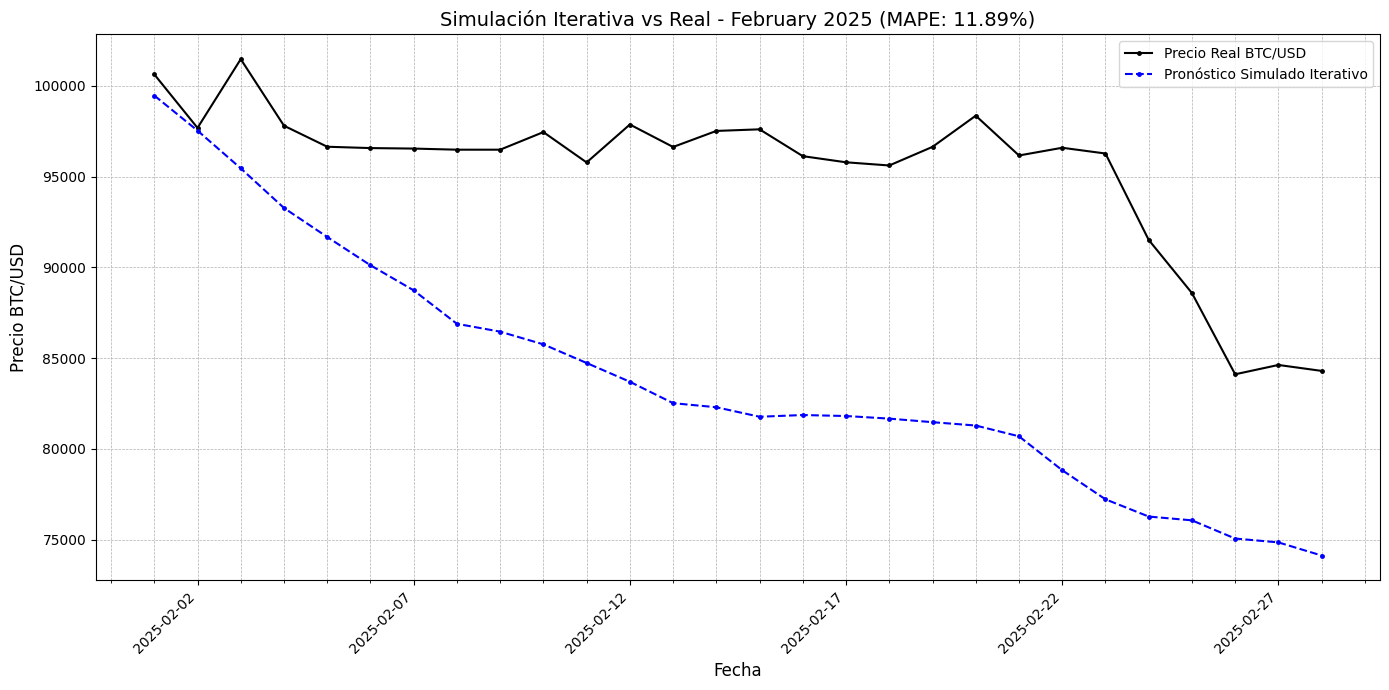



***** INICIANDO PERIODO DE SIMULACIÓN: March 2025 (2025-03-01 a 2025-03-31) *****
  Secuencia inicial obtenida (hasta 2025-02-28).
  Iniciando bucle de predicción para March 2025...
    Simulando día: 2025-03-01...
    Simulando día: 2025-03-02...
    Simulando día: 2025-03-03...
    Simulando día: 2025-03-04...
    Simulando día: 2025-03-05...
    Simulando día: 2025-03-06...
    Simulando día: 2025-03-07...
    Simulando día: 2025-03-08...
    Simulando día: 2025-03-09...
    Simulando día: 2025-03-10...
    Simulando día: 2025-03-11...
    Simulando día: 2025-03-12...
    Simulando día: 2025-03-13...
    Simulando día: 2025-03-14...
    Simulando día: 2025-03-15...
    Simulando día: 2025-03-16...
    Simulando día: 2025-03-17...
    Simulando día: 2025-03-18...
    Simulando día: 2025-03-19...
    Simulando día: 2025-03-20...
    Simulando día: 2025-03-21...
    Simulando día: 2025-03-22...
    Simulando día: 2025-03-23...
    Simulando día: 2025-03-24...
    Simulando día: 2025-

Pronostico_Iterativo_USD  Real_USD
2025-03-01              83408.685062  86018.76
2025-03-02              82663.664048  94265.48
2025-03-03              82345.778623  86161.10
2025-03-04              82037.131005  87249.96
2025-03-05              81639.606226  90603.73
2025-03-06              81681.668523  89921.85
2025-03-07              80618.029075  86756.98
2025-03-08              80626.000627  86206.69
2025-03-09              79048.540705  80699.17
2025-03-10              78304.771788  78544.71
2025-03-11              77800.858138  82914.51
2025-03-12              77361.830182  83659.43
2025-03-13              77551.464519  81073.43
2025-03-14              76858.604306  83980.49
2025-03-15              77053.477364  84351.46
2025-03-16              77184.702718  82562.57
2025-03-17              76681.041064  84011.40
2025-03-18              76384.780669  82698.76
2025-03-19              75354.634278  86877.96
2025-03-20              75080.730798  84183.42
2025-03-21              74747.866292  84061.96
2025-03-22              74263.268319  83852.03
2025-03-23              74714.669831  86092.94
2025-03-24              74811.074033  87523.62
2025-03-25              75030.862164  87427.88
2025-03-26              75656.563793  86926.01
2025-03-27              75705.413023  87217.48
2025-03-28              76054.430631  84381.80
2025-03-29              75604.019319  82616.83
2025-03-30              76385.894629  82379.98
2025-03-31              77522.811135  82534.32


Generando gráfica (Sim) para March 2025...


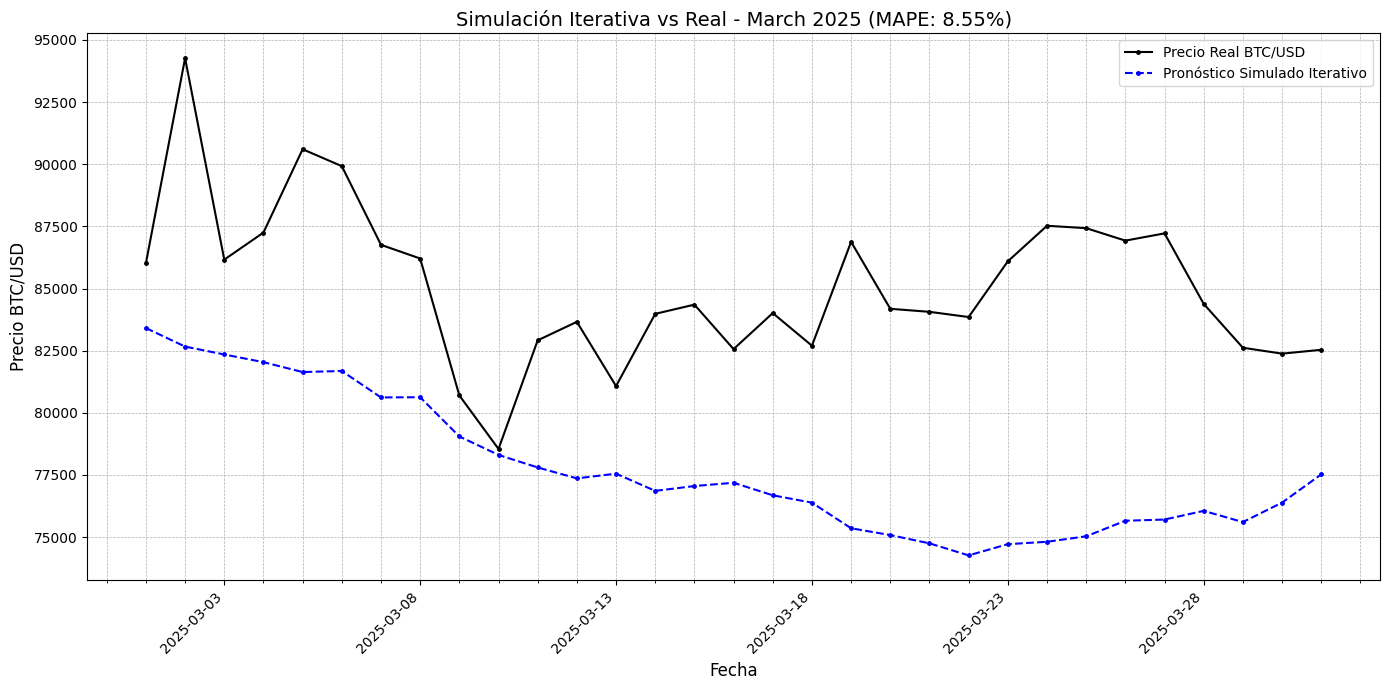



***** INICIANDO PERIODO DE SIMULACIÓN: April 2025 (2025-04-01 a 2025-04-30) *****
  Secuencia inicial obtenida (hasta 2025-03-31).
  Iniciando bucle de predicción para April 2025...
    Simulando día: 2025-04-01...
    Simulando día: 2025-04-02...
    Simulando día: 2025-04-03...
    Simulando día: 2025-04-04...
    Simulando día: 2025-04-05...
    Simulando día: 2025-04-06...
    Simulando día: 2025-04-07...
    Simulando día: 2025-04-08...
    Simulando día: 2025-04-09...
    Simulando día: 2025-04-10...
    Simulando día: 2025-04-11...
    Simulando día: 2025-04-12...
    Simulando día: 2025-04-13...
    Simulando día: 2025-04-14...
    Simulando día: 2025-04-15...
    Simulando día: 2025-04-16...
    Simulando día: 2025-04-17...
    Simulando día: 2025-04-18...
    Simulando día: 2025-04-19...
    Simulando día: 2025-04-20...
    Simulando día: 2025-04-21...
    Simulando día: 2025-04-22...
    Simulando día: 2025-04-23...
    Simulando día: 2025-04-24...
    Simulando día: 2025-

Pronostico_Iterativo_USD  Real_USD
2025-04-01              84710.935814  85170.37
2025-04-02              86471.402464  82490.08
2025-04-03              89104.420044  83174.33
2025-04-04              87965.595388  83860.16
2025-04-05              84308.077221  83498.25
2025-04-06              83361.405444  78370.75
2025-04-07              84867.528337  79140.01
2025-04-08              85293.457258  76251.64
2025-04-09              84946.775505  82594.75
2025-04-10              91279.997325  79552.34
2025-04-11              93087.939571  83380.47
2025-04-12              94411.193257  85271.01
2025-04-13              95214.368383  83733.07
2025-04-14              95219.422845  84590.36
2025-04-15              96111.041904  83629.78
2025-04-16              96833.620841  84028.72
2025-04-17              96346.776032  84961.97
2025-04-18              96126.236755  84466.47
2025-04-19              94976.002998  85074.99
2025-04-20              94163.907026  85177.34
2025-04-21              93813.644303  87522.07
2025-04-22              92589.648610  93489.10
2025-04-23              91937.022515  93740.92
2025-04-24              90832.836313  94021.96
2025-04-25              90539.766823  94708.79
2025-04-26              89362.916556  94666.64
2025-04-27              87159.328154  93780.57
2025-04-28              84321.971722  95042.57
2025-04-29              82086.843784  94271.09
2025-04-30              80624.895379  94182.54


Generando gráfica (Sim) para April 2025...


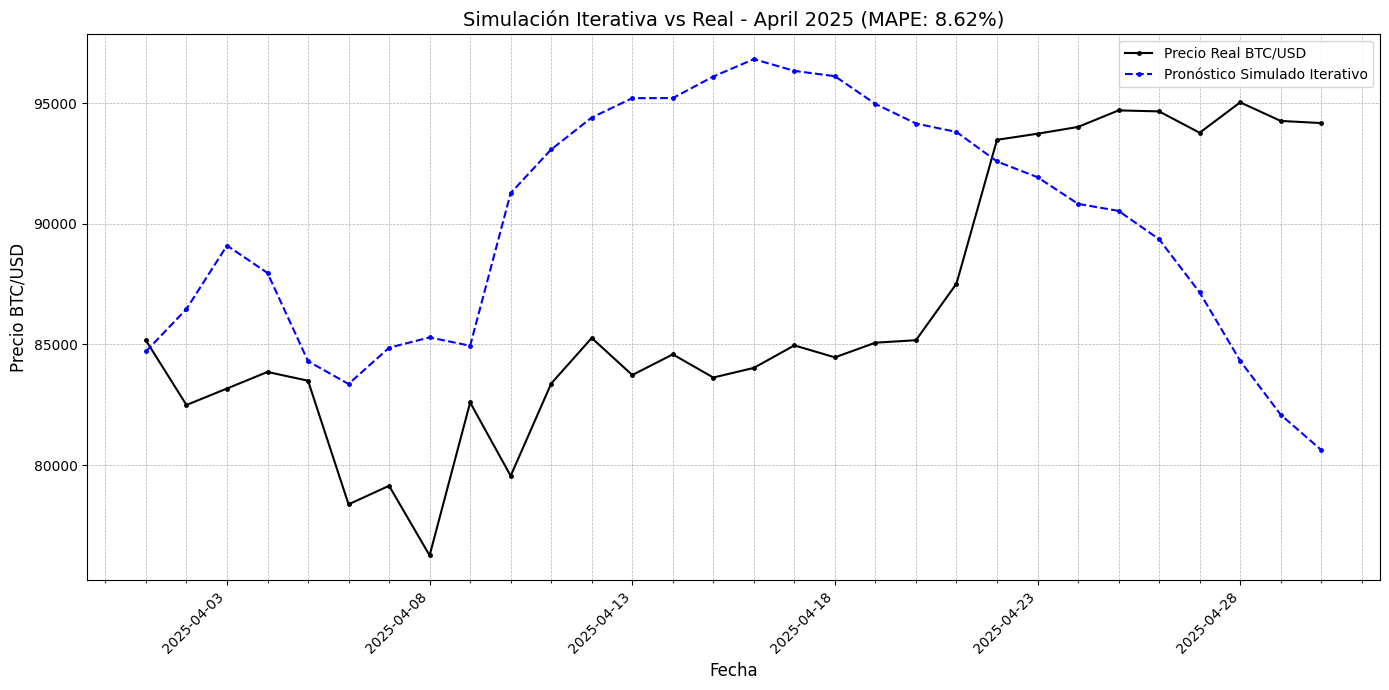


--- Resumen de Errores MAPE (Simulación Iterativa) ---

  Promedio General MAPE (Sim Iterativa): 11.05%

MAPEs Mensuales Individuales (Simulación):
 - January 2024: 10.67%
 - February 2024: 6.60%
 - March 2024: 8.18%
 - April 2024: 7.15%
 - May 2024: 13.47%
 - June 2024: 4.32%
 - July 2024: 7.80%
 - August 2024: 6.69%
 - September 2024: 8.91%
 - October 2024: 5.32%
 - November 2024: 21.89%
 - December 2024: 22.68%
 - January 2025: 23.78%
 - February 2025: 11.89%
 - March 2025: 8.55%
 - April 2025: 8.62%

--- Simulación Mensual Iterativa Finalizada ---


In [ ]:

# --- Bloque 13: Simulación de Pronóstico Mensual Iterativo (con MAPE y PRINTS de Progreso) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display
import locale
import datetime

# Intentar establecer locale en español para nombres de meses
try:
    locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')
except locale.Error:
    try: locale.setlocale(locale.LC_TIME, 'Spanish')
    except locale.Error: print("Advertencia: Locale español no disponible.")

print("\n--- Iniciando Simulación de Pronóstico Mensual Iterativo ---")

# --- (Verificación de variables requeridas como antes) ---
required_vars = ['best_model', 'scaler', 'scaled_data', 'date_index',
                 'n_steps', 'n_features', 'feature_names', #'inverse_scale_column',
                 'combined_data_final', 'log_btc_col', 'hist_btc_usd', 'scaled_df']
variables_exist = True
for var_name in required_vars:
    if var_name not in locals() and var_name not in globals(): print(f"Error: Variable '{var_name}' no encontrada."); variables_exist = False
if not variables_exist: print("Asegúrate de haber ejecutado los bloques anteriores (1-11).")
# --- Fin Verificación ---

else:
    # --- (Función inverse_scale_column definida aquí por robustez) ---
    def inverse_scale_column(scaler_obj, data_scaled, column_index, n_total_features):
        data_scaled_np = np.array(data_scaled).flatten(); temp_array = np.zeros((len(data_scaled_np), n_total_features))
        temp_array[:, column_index] = data_scaled_np; return scaler_obj.inverse_transform(temp_array)[:, column_index]

    # --- (Preparación hist_btc_usd como antes) ---
    print("Preparando datos históricos reales (USD)...")
    try:
        if 'hist_btc_usd' not in locals() or not isinstance(hist_btc_usd.index, pd.DatetimeIndex):
             if 'combined_data_final' in locals() and log_btc_col in combined_data_final.columns:
                  hist_btc_usd = np.exp(combined_data_final[log_btc_col])
                  if not isinstance(hist_btc_usd.index, pd.DatetimeIndex): hist_btc_usd.index = pd.to_datetime(hist_btc_usd.index)
             else: raise ValueError("No se pudo crear hist_btc_usd")
        print("  Histórico USD listo.")
    except Exception as e: print(f"Error prep hist USD: {e}"); exit() # O os._exit(1)
    # --- Fin Preparación hist_btc_usd ---

    # --- Generar Periodos Mensuales (Ene 2024 - Abr 2025) ---
    print("Generando periodos mensuales para backtesting...")
    backtest_periods = {}
    bt_start_overall = pd.to_datetime('2024-01-01'); bt_end_overall = pd.to_datetime('2025-04-30')
    current_month_start = bt_start_overall.replace(day=1)
    while current_month_start <= bt_end_overall:
        start_of_month = current_month_start; end_of_month = start_of_month + pd.offsets.MonthEnd(0)
        if end_of_month > bt_end_overall: end_of_month = bt_end_overall
        if start_of_month > bt_end_overall: break
        period_name = start_of_month.strftime('%B %Y').capitalize()
        backtest_periods[period_name] = (start_of_month.strftime('%Y-%m-%d'), end_of_month.strftime('%Y-%m-%d'))
        current_month_start = (end_of_month + pd.DateOffset(days=1)).replace(day=1)
    print(f"Periodos generados: {len(backtest_periods)}")
    if not backtest_periods: print("Error: No se generaron periodos."); exit() # O os._exit(1)
    # --- Fin Generar Periodos ---

    # --- Variables para almacenar errores globales ---
    monthly_mapes_sim = {}; all_reals_sim = []; all_preds_sim = []

    # --- Bucle principal sobre los periodos ---
    for period_name, (start_sim_str, end_sim_str) in backtest_periods.items():
        # ***** PRINT DE PROGRESO EXTERNO *****
        print(f"\n\n***** INICIANDO PERIODO DE SIMULACIÓN: {period_name} ({start_sim_str} a {end_sim_str}) *****")
        # *************************************
        start_sim_dt = pd.to_datetime(start_sim_str)
        end_sim_dt = pd.to_datetime(end_sim_str)

        # 1. Encontrar secuencia inicial
        start_sequence_end_date = start_sim_dt - pd.DateOffset(days=1)
        try: start_sequence_end_idx = date_index.get_loc(start_sequence_end_date)
        except KeyError: print(f"Error: Fecha inicial requerida ({start_sequence_end_date.strftime('%Y-%m-%d')}) no encontrada."); continue
        except Exception as e: print(f"Error buscando índice inicial: {e}"); continue
        if start_sequence_end_idx < n_steps - 1: print(f"Error: Datos insuficientes antes de {start_sim_str}."); continue
        initial_sequence_idx_start = start_sequence_end_idx - n_steps + 1
        if initial_sequence_idx_start < 0 or start_sequence_end_idx >= len(scaled_data): print("Error: Índices secuencia inicial fuera de rango."); continue
        current_sequence = scaled_data[initial_sequence_idx_start : start_sequence_end_idx + 1].reshape(1, n_steps, n_features)
        print(f"  Secuencia inicial obtenida (hasta {start_sequence_end_date.strftime('%Y-%m-%d')}).")

        # 2. Generar predicciones iterativamente para el mes
        predictions_scaled_log = []; actual_dates_in_period = []
        current_pred_date = start_sim_dt
        print(f"  Iniciando bucle de predicción para {period_name}...") # DEBUG
        while current_pred_date <= end_sim_dt:
            # ***** PRINT DE PROGRESO INTERNO *****
            print(f"    Simulando día: {current_pred_date.strftime('%Y-%m-%d')}...") # <-- AÑADIDO
            # *************************************
            try: current_date_idx = date_index.get_loc(current_pred_date)
            except KeyError: print(f"Adv: Fecha {current_pred_date.strftime('%Y-%m-%d')} no en índice original, saltando."); current_pred_date += pd.DateOffset(days=1); continue
            if current_date_idx >= len(scaled_data): print(f"Adv: Fecha {current_pred_date.strftime('%Y-%m-%d')} fuera de rango scaled_data."); break

            # Predecir
            pred_scaled = best_model.predict(current_sequence, verbose=0)[0, 0]
            predictions_scaled_log.append(pred_scaled)
            actual_dates_in_period.append(current_pred_date)

            # Preparar siguiente secuencia
            actual_exog_features_scaled = scaled_data[current_date_idx, 1:]
            new_features_vector = np.concatenate((np.array([pred_scaled]), actual_exog_features_scaled))
            if len(new_features_vector) != n_features: print(f"Error Fatal: Discrepancia features."); import os; os._exit(1)
            new_features_vector = new_features_vector.reshape(1, 1, n_features)
            next_sequence = np.concatenate((current_sequence[:, 1:, :], new_features_vector), axis=1)
            current_sequence = next_sequence
            current_pred_date += pd.DateOffset(days=1)
            # Fin del bucle while

        # 3. Post-procesar
        if not predictions_scaled_log: print(f"No se generaron predicciones para {period_name}."); continue
        preds_log = inverse_scale_column(scaler, predictions_scaled_log, 0, n_features)
        preds_usd = np.exp(preds_log)
        actual_dates_in_period_dt = pd.to_datetime(actual_dates_in_period)

        # 4. Comparar
        try:
            actuals_usd_series = hist_btc_usd.loc[hist_btc_usd.index.isin(actual_dates_in_period_dt)]
            df_compare_sim = pd.DataFrame(index=actual_dates_in_period_dt)
            preds_series = pd.Series(preds_usd, index=actual_dates_in_period_dt)
            df_compare_sim['Pronostico_Iterativo_USD'] = preds_series
            df_compare_sim = df_compare_sim.join(actuals_usd_series.rename('Real_USD'))
            df_compare_sim.dropna(inplace=True)
        except Exception as e: print(f"Error inesperado al obtener/alinear reales (Sim): {e}"); continue
        if df_compare_sim.empty: print("No se pudieron generar resultados comparativos (Sim)."); continue

        # 5. Calcular y Mostrar MAPE
        y_true = df_compare_sim['Real_USD']; y_pred = df_compare_sim['Pronostico_Iterativo_USD']
        zero_mask = y_true != 0; mape_sim = np.nan
        if zero_mask.sum() > 0:
            mape_sim = np.mean(np.abs((y_true[zero_mask] - y_pred[zero_mask]) / y_true[zero_mask])) * 100
            print(f"MAPE (Simulación Iterativa) para {period_name}: {mape_sim:.2f}%")
            monthly_mapes_sim[period_name] = mape_sim
            all_reals_sim.extend(y_true[zero_mask].values)
            all_preds_sim.extend(y_pred[zero_mask].values)
        else: print(f"No se pudo calcular MAPE (Sim) para {period_name}.")

        print(f"\nResultados Simulación - {period_name}:"); display(df_compare_sim)

        # 6. Graficar
        print(f"\nGenerando gráfica (Sim) para {period_name}...")
        fig_sim, ax_sim = plt.subplots(figsize=(14, 7))
        ax_sim.plot(df_compare_sim.index, df_compare_sim['Real_USD'], label='Precio Real BTC/USD', color='black', marker='.', markersize=5, linestyle='-')
        ax_sim.plot(df_compare_sim.index, df_compare_sim['Pronostico_Iterativo_USD'], label='Pronóstico Simulado Iterativo', color='blue', marker='.', markersize=5, linestyle='--')
        ax_sim.set_title(f'Simulación Iterativa vs Real - {period_name} (MAPE: {mape_sim:.2f}%)' if not np.isnan(mape_sim) else f'Simulación Iterativa vs Real - {period_name}', fontsize=14)
        ax_sim.set_ylabel('Precio BTC/USD', fontsize=12); ax_sim.set_xlabel('Fecha', fontsize=12)
        ax_sim.legend(); ax_sim.grid(True, which="both", ls="--", linewidth=0.5)
        ax_sim.xaxis.set_major_locator(mdates.DayLocator(interval=5)); ax_sim.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax_sim.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

    # --- FIN DEL BUCLE for period_name... ---

    # --- (Mostrar Resumen MAPE General y Mensual como antes) ---
    print("\n--- Resumen de Errores MAPE (Simulación Iterativa) ---")
    if all_reals_sim and all_preds_sim:
         all_reals_np = np.array(all_reals_sim); all_preds_np = np.array(all_preds_sim); zero_mask_overall = all_reals_np != 0
         if zero_mask_overall.sum() > 0:
             overall_mape = np.mean(np.abs((all_reals_np[zero_mask_overall] - all_preds_np[zero_mask_overall]) / all_reals_np[zero_mask_overall])) * 100
             print(f"\n=================================================="); print(f"  Promedio General MAPE (Sim Iterativa): {overall_mape:.2f}%"); print(f"==================================================")
         else: print("\nNo se pudo calcular MAPE general (Sim).")
         print("\nMAPEs Mensuales Individuales (Simulación):")
         if monthly_mapes_sim:
             try: sorted_mapes = sorted(monthly_mapes_sim.items(), key=lambda item: datetime.datetime.strptime(item[0], '%B %Y'));
             except Exception as sort_e: print(f"(No se pudo ordenar por fecha: {sort_e}). Mostrando en orden de cálculo:"); sorted_mapes = monthly_mapes_sim.items()
             for name, mape_val in sorted_mapes: print(f" - {name}: {mape_val:.2f}%")
         else: print("No se calcularon MAPEs mensuales (Sim).")
    else: print("No se acumularon datos suficientes para calcular el MAPE general (Sim).")

print("\n--- Simulación Mensual Iterativa Finalizada ---")

Advertencia: Locale español no disponible.

--- Iniciando Backtesting MENSUAL con Análisis SEMANAL (Ene 2024 - Abr 2025) ---
Reconstruyendo secuencias X y fechas objetivo...
Preparando datos históricos reales (USD)...
  Histórico USD listo.
Generando periodos mensuales para backtesting...
Periodos generados: 16


***** PROCESANDO PERIODO: January 2024 (2024-01-01 a 2024-01-31) *****
Realizando predicciones (1-paso) para 31 días...

Análisis Semanal para January 2024:
  - Semana 1: MAPE = 3.23% (7 días)
  - Semana 2: MAPE = 4.39% (7 días)
  - Semana 3: MAPE = 1.46% (7 días)
  - Semana 4: MAPE = 2.06% (7 días)
  - Semana 5: MAPE = 1.35% (3 días)
  >> Mejor resultado en: Semana 5 (MAPE: 1.35%)

Resultados Completos - January 2024:


Pronostico_USD  Real_USD
2024-01-01    42816.051746  44220.78
2024-01-02    43458.351466  44972.80
2024-01-03    44862.602173  42862.44
2024-01-04    45166.255266  44193.29
2024-01-05    45189.288545  44186.59
2024-01-06    45401.592999  43992.44
2024-01-07    45593.413293  43950.28
2024-01-08    45577.790629  46995.10
2024-01-09    46223.863033  46124.08
2024-01-10    46679.467928  46666.11
2024-01-11    47002.368506  46342.66
2024-01-12    47159.944096  42773.03
2024-01-13    46207.323524  42839.33
2024-01-14    45016.562256  41697.33
2024-01-15    43824.992580  42490.16
2024-01-16    43192.527391  43130.45
2024-01-17    42927.340162  42739.49
2024-01-18    42489.391860  41293.50
2024-01-19    42195.747231  41624.07
2024-01-20    42154.599822  41666.67
2024-01-21    42006.200755  41554.05
2024-01-22    41630.520445  39524.27
2024-01-23    40814.882068  39878.30
2024-01-24    40484.072974  40077.78
2024-01-25    40548.524669  39941.66
2024-01-26    40895.423376  41814.80
2024-01-27    41495.946624  42126.55
2024-01-28    42252.644685  42034.59
2024-01-29    42668.709074  43306.18
2024-01-30    43146.330419  42942.78
2024-01-31    43440.242047  42548.08


Generando gráfica para January 2024...


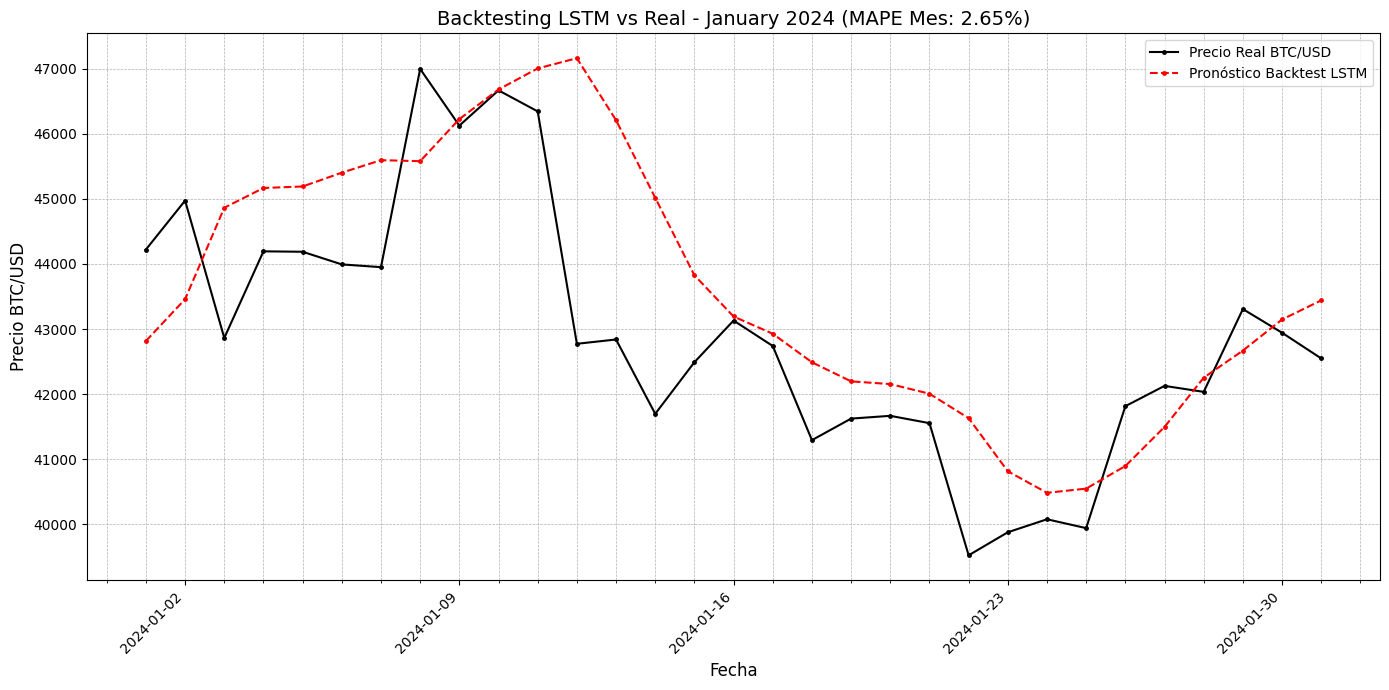



***** PROCESANDO PERIODO: February 2024 (2024-02-01 a 2024-02-29) *****
Realizando predicciones (1-paso) para 29 días...

Análisis Semanal para February 2024:
  - Semana 1: MAPE = 1.64% (7 días)
  - Semana 2: MAPE = 2.04% (7 días)
  - Semana 3: MAPE = 1.09% (7 días)
  - Semana 4: MAPE = 5.22% (7 días)
  - Semana 5: MAPE = 5.00% (1 días)
  >> Mejor resultado en: Semana 3 (MAPE: 1.09%)

Resultados Completos - February 2024:


Pronostico_USD  Real_USD
2024-02-01    42922.557577  43078.81
2024-02-02    42949.319358  43181.66
2024-02-03    43777.825470  43010.67
2024-02-04    44146.569554  42568.55
2024-02-05    43964.939640  42657.67
2024-02-06    43887.965388  43095.79
2024-02-07    44424.043673  44343.61
2024-02-08    45699.802845  45305.20
2024-02-09    47220.656758  47160.41
2024-02-10    48950.130829  47767.06
2024-02-11    50125.382900  48316.30
2024-02-12    50908.296881  49941.81
2024-02-13    51542.031312  49725.36
2024-02-14    51087.176636  51858.59
2024-02-15    51386.657450  51934.29
2024-02-16    52162.441991  52162.64
2024-02-17    52648.794086  51666.22
2024-02-18    52460.070134  52153.63
2024-02-19    52410.396181  51787.05
2024-02-20    52597.100490  52277.52
2024-02-21    53027.863625  51851.67
2024-02-22    53140.920779  51258.70
2024-02-23    53736.627096  50747.05
2024-02-24    53377.924092  51570.65
2024-02-25    52997.387801  51731.00
2024-02-26    52809.801690  54533.48
2024-02-27    53518.023168  57077.07
2024-02-28    55262.283376  62518.90
2024-02-29    58121.818317  61179.03


Generando gráfica para February 2024...


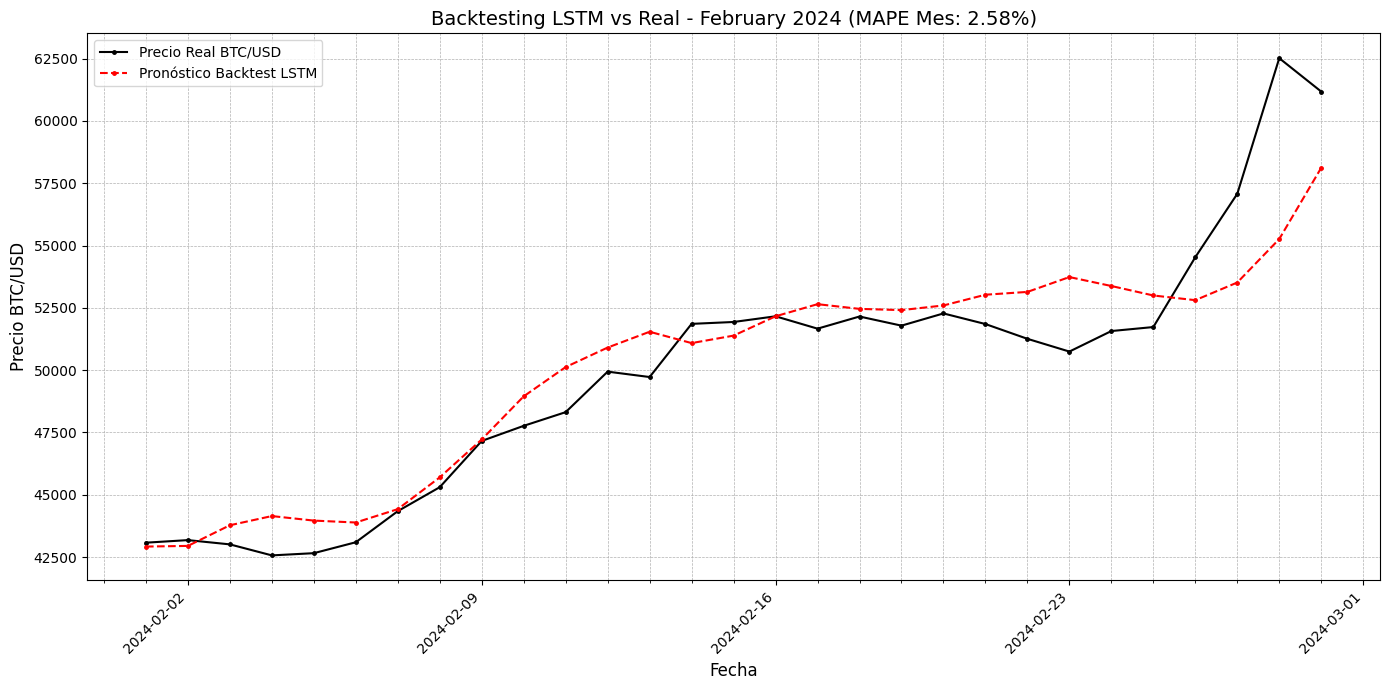



***** PROCESANDO PERIODO: March 2024 (2024-03-01 a 2024-03-31) *****
Realizando predicciones (1-paso) para 31 días...

Análisis Semanal para March 2024:
  - Semana 1: MAPE = 2.86% (7 días)
  - Semana 2: MAPE = 3.64% (7 días)
  - Semana 3: MAPE = 3.25% (7 días)
  - Semana 4: MAPE = 3.79% (7 días)
  - Semana 5: MAPE = 1.06% (3 días)
  >> Mejor resultado en: Semana 5 (MAPE: 1.06%)

Resultados Completos - March 2024:


Pronostico_USD  Real_USD
2024-03-01    60406.521747  62436.72
2024-03-02    62585.883952  62045.78
2024-03-03    63454.816001  63154.49
2024-03-04    63539.360248  68360.14
2024-03-05    64801.692764  63800.78
2024-03-06    64123.596072  66122.28
2024-03-07    64389.989969  66938.21
2024-03-08    65591.523254  68289.16
2024-03-09    66335.873659  68480.00
2024-03-10    66848.654211  69032.12
2024-03-11    67391.771857  72110.98
2024-03-12    68734.990236  71475.93
2024-03-13    69949.181456  73135.04
2024-03-14    71013.054001  71364.58
2024-03-15    71136.067041  69506.88
2024-03-16    69721.743582  65254.22
2024-03-17    67819.047767  68343.64
2024-03-18    67078.340228  67613.04
2024-03-19    66701.628394  61906.27
2024-03-20    65152.071129  67858.80
2024-03-21    65645.705429  65484.70
2024-03-22    65996.989856  63814.56
2024-03-23    65275.763652  63998.86
2024-03-24    64497.730016  67204.93
2024-03-25    64935.249632  69890.28
2024-03-26    66521.506915  69992.40
2024-03-27    67912.338219  69435.96
2024-03-28    68788.177654  70801.18
2024-03-29    69743.302689  69903.75
2024-03-30    70096.332235  69626.87
2024-03-31    69675.901798  71288.90


Generando gráfica para March 2024...


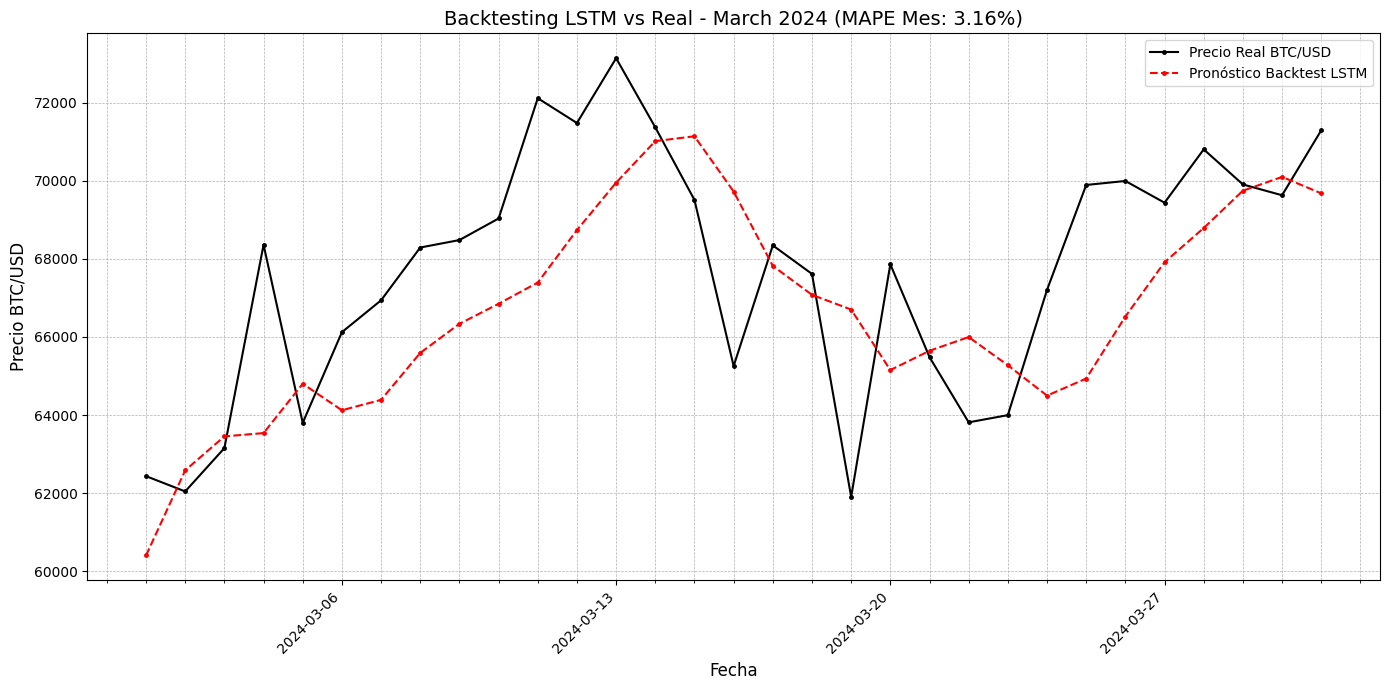



***** PROCESANDO PERIODO: April 2024 (2024-04-01 a 2024-04-30) *****
Realizando predicciones (1-paso) para 30 días...

Análisis Semanal para April 2024:
  - Semana 1: MAPE = 2.85% (7 días)
  - Semana 2: MAPE = 2.68% (7 días)
  - Semana 3: MAPE = 4.55% (7 días)
  - Semana 4: MAPE = 2.26% (7 días)
  - Semana 5: MAPE = 2.13% (2 días)
  >> Mejor resultado en: Semana 5 (MAPE: 2.13%)

Resultados Completos - April 2024:


Pronostico_USD  Real_USD
2024-04-01    69561.682773  69681.82
2024-04-02    69160.191360  65464.14
2024-04-03    67621.292478  65987.92
2024-04-04    66398.997779  68525.23
2024-04-05    65951.404150  67856.51
2024-04-06    66711.414858  68919.89
2024-04-07    67569.086134  69350.34
2024-04-08    68127.534635  71622.53
2024-04-09    69088.436996  69117.01
2024-04-10    69329.094450  70634.04
2024-04-11    69346.992446  70020.73
2024-04-12    69818.812077  67148.61
2024-04-13    68331.573407  64024.77
2024-04-14    65554.859414  65777.05
2024-04-15    64117.293527  63452.18
2024-04-16    62933.807533  63814.94
2024-04-17    61982.385343  61279.36
2024-04-18    59995.980826  63513.85
2024-04-19    59399.210048  63848.37
2024-04-20    59395.017575  64968.87
2024-04-21    60295.889776  64952.92
2024-04-22    61312.112597  66859.17
2024-04-23    62654.228949  66414.16
2024-04-24    64184.839673  64255.78
2024-04-25    64397.690447  64484.44
2024-04-26    63966.255457  63742.39
2024-04-27    63891.876192  63422.00
2024-04-28    63421.196290  63108.94
2024-04-29    62793.395614  63844.85
2024-04-30    62211.371353  60622.10


Generando gráfica para April 2024...


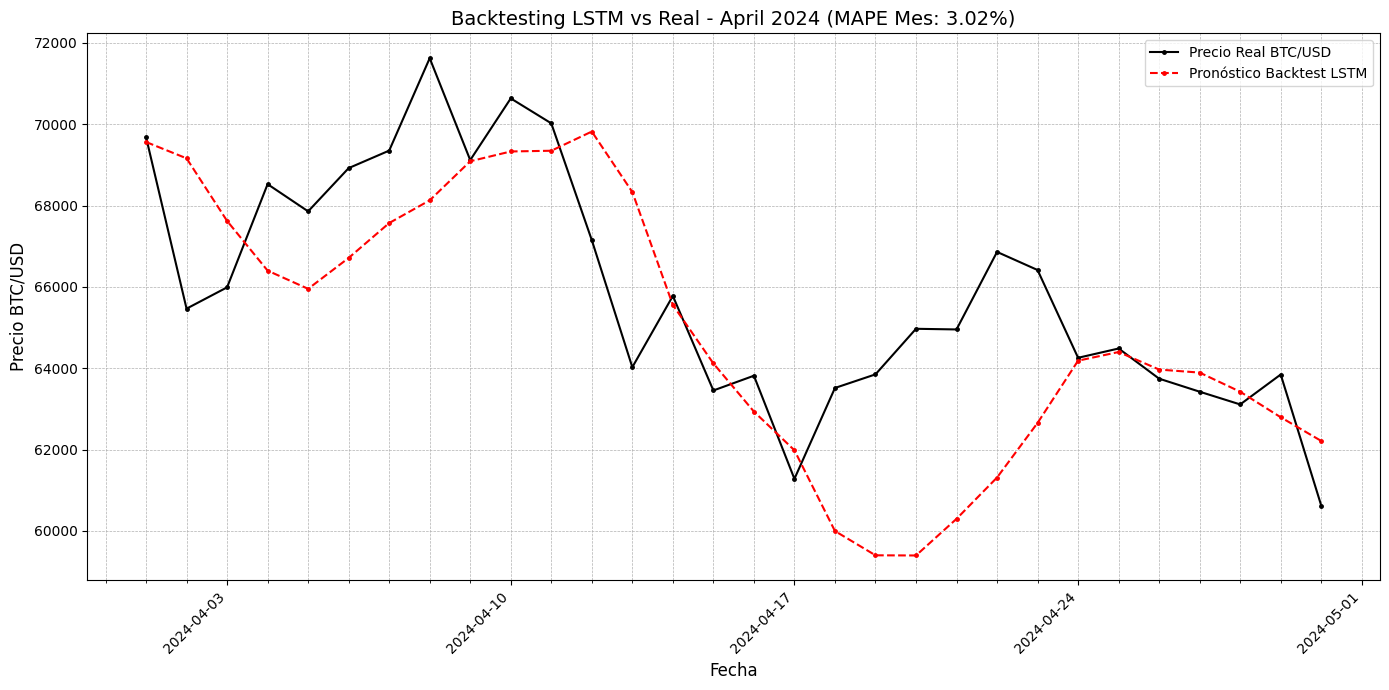



***** PROCESANDO PERIODO: May 2024 (2024-05-01 a 2024-05-31) *****
Realizando predicciones (1-paso) para 31 días...

Análisis Semanal para May 2024:
  - Semana 1: MAPE = 6.35% (7 días)
  - Semana 2: MAPE = 1.64% (7 días)
  - Semana 3: MAPE = 3.58% (7 días)
  - Semana 4: MAPE = 1.61% (7 días)
  - Semana 5: MAPE = 1.56% (3 días)
  >> Mejor resultado en: Semana 5 (MAPE: 1.56%)

Resultados Completos - May 2024:


Pronostico_USD  Real_USD
2024-05-01    59743.688127  58265.59
2024-05-02    56870.503794  59071.89
2024-05-03    55695.247125  62913.03
2024-05-04    56848.065558  63902.88
2024-05-05    58886.934908  64023.45
2024-05-06    60039.481450  63162.24
2024-05-07    60617.962723  62315.76
2024-05-08    61217.924714  61169.53
2024-05-09    61440.591966  63073.57
2024-05-10    62283.340116  60787.47
2024-05-11    62372.090133  60814.63
2024-05-12    62096.582626  61453.02
2024-05-13    62053.944412  62932.37
2024-05-14    62380.622752  61539.84
2024-05-15    62168.799382  66244.69
2024-05-16    63693.978811  65252.18
2024-05-17    64679.860681  67046.33
2024-05-18    65752.113673  66923.87
2024-05-19    66499.236885  66261.62
2024-05-20    66412.691304  71432.17
2024-05-21    67430.092403  70142.84
2024-05-22    68209.789155  69109.93
2024-05-23    67908.020236  67940.45
2024-05-24    66660.533142  68547.80
2024-05-25    66613.537079  69289.67
2024-05-26    67621.529155  68473.72
2024-05-27    68003.654506  69368.72
2024-05-28    68269.558952  68321.98
2024-05-29    68050.102983  67569.45
2024-05-30    67056.353178  68338.58
2024-05-31    66070.370238  67472.41


Generando gráfica para May 2024...


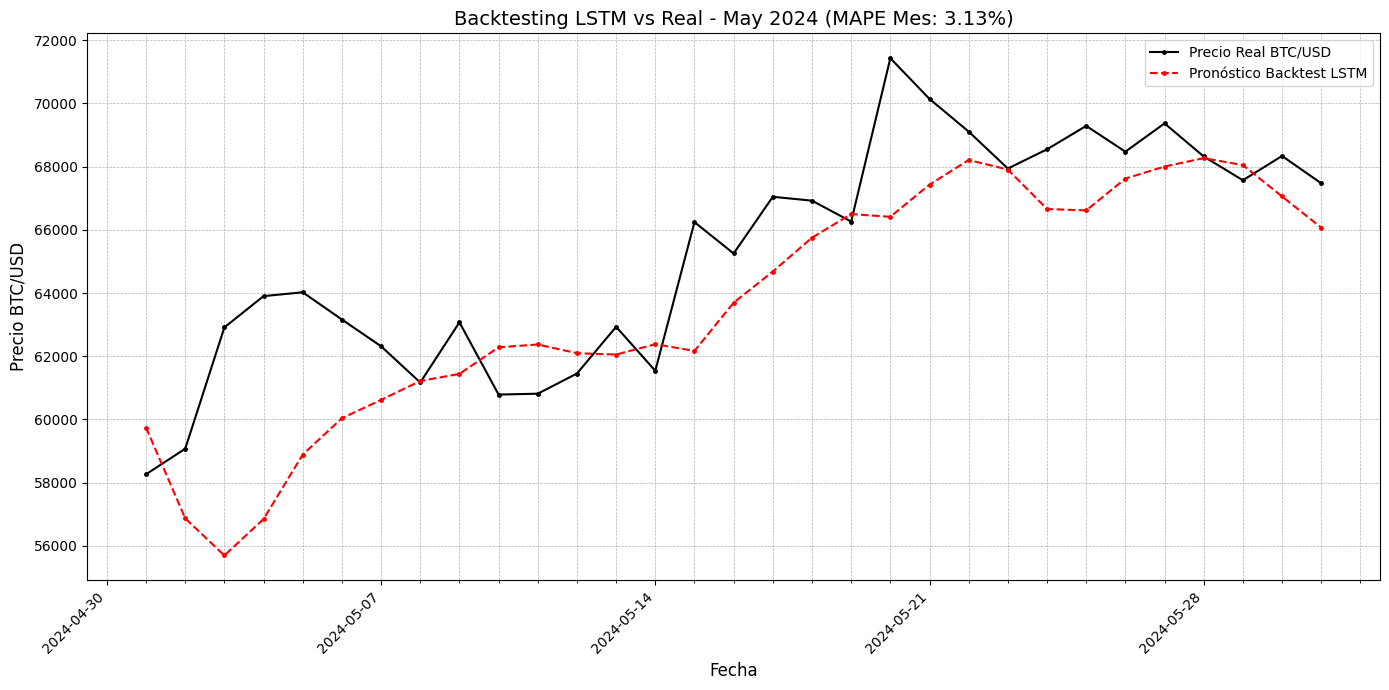



***** PROCESANDO PERIODO: June 2024 (2024-06-01 a 2024-06-30) *****
Realizando predicciones (1-paso) para 30 días...

Análisis Semanal para June 2024:
  - Semana 1: MAPE = 3.74% (7 días)
  - Semana 2: MAPE = 1.21% (7 días)
  - Semana 3: MAPE = 1.36% (7 días)
  - Semana 4: MAPE = 1.37% (7 días)
  - Semana 5: MAPE = 4.93% (2 días)
  >> Mejor resultado en: Semana 2 (MAPE: 1.21%)

Resultados Completos - June 2024:


Pronostico_USD  Real_USD
2024-06-01    65489.156812  67719.29
2024-06-02    65427.622815  67735.52
2024-06-03    65764.522894  68791.00
2024-06-04    66372.567773  70542.32
2024-06-05    67296.212951  71121.11
2024-06-06    69266.800982  70773.64
2024-06-07    70474.290038  69324.53
2024-06-08    69808.671567  69304.05
2024-06-09    69446.698975  69637.87
2024-06-10    69128.226368  69497.73
2024-06-11    68736.072827  67316.53
2024-06-12    68058.856546  68248.60
2024-06-13    68079.722750  66738.85
2024-06-14    67671.229824  66004.39
2024-06-15    67137.725615  66192.00
2024-06-16    67068.284758  66628.75
2024-06-17    66873.752393  66481.81
2024-06-18    66566.768302  65152.80
2024-06-19    66161.564001  64943.79
2024-06-20    65636.573048  64840.88
2024-06-21    65121.464798  64120.28
2024-06-22    64111.309488  64235.01
2024-06-23    63342.222193  63171.43
2024-06-24    62876.013286  60263.00
2024-06-25    61517.787250  61789.71
2024-06-26    60643.693093  60816.68
2024-06-27    59822.624798  61615.39
2024-06-28    59611.089162  60313.35
2024-06-29    58832.616806  60885.67
2024-06-30    58599.451825  62668.26


Generando gráfica para June 2024...


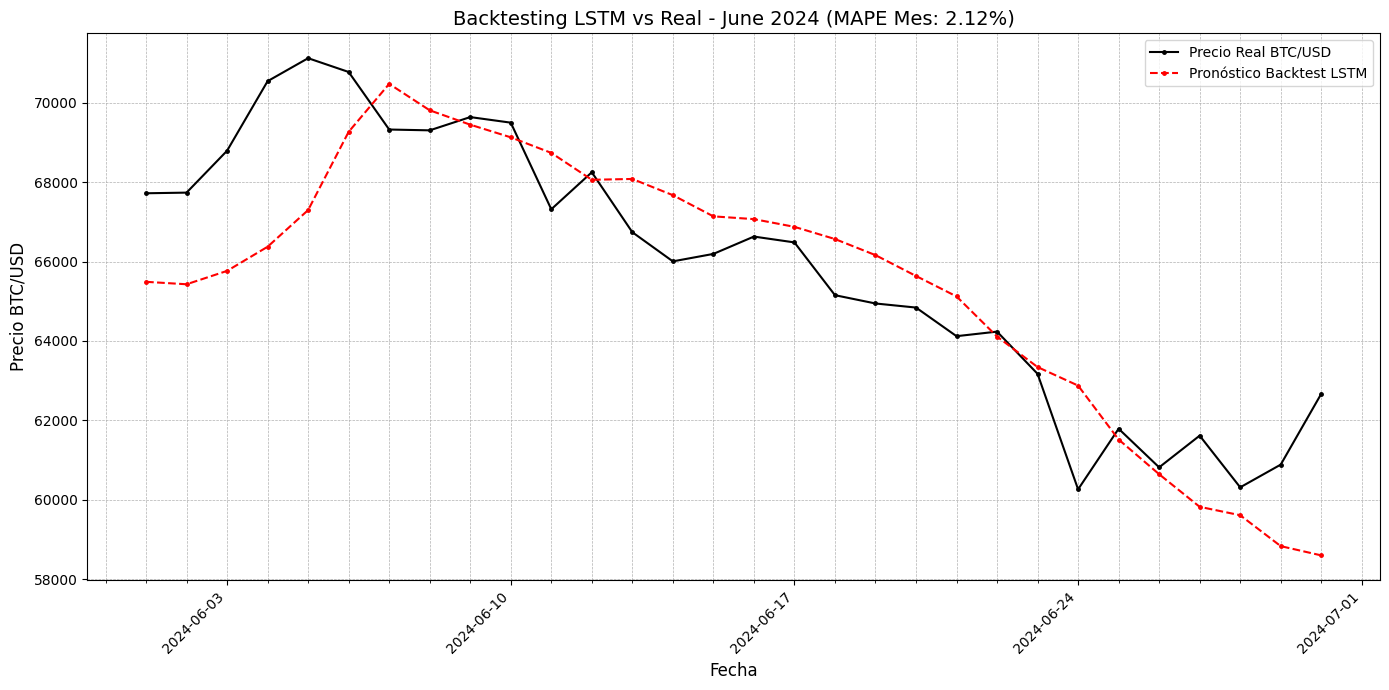



***** PROCESANDO PERIODO: July 2024 (2024-07-01 a 2024-07-31) *****
Realizando predicciones (1-paso) para 31 días...

Análisis Semanal para July 2024:
  - Semana 1: MAPE = 3.41% (7 días)
  - Semana 2: MAPE = 1.52% (7 días)
  - Semana 3: MAPE = 3.60% (7 días)
  - Semana 4: MAPE = 5.31% (7 días)
  - Semana 5: MAPE = 3.07% (3 días)
  >> Mejor resultado en: Semana 2 (MAPE: 1.52%)

Resultados Completos - July 2024:


Pronostico_USD  Real_USD
2024-07-01    58826.765666  62830.13
2024-07-02    59350.235492  62040.22
2024-07-03    60047.800048  60145.01
2024-07-04    60225.163567  57042.14
2024-07-05    59229.893237  56639.43
2024-07-06    57742.078191  58244.75
2024-07-07    56955.162151  55854.09
2024-07-08    56106.314254  56699.43
2024-07-09    55985.021371  58047.86
2024-07-10    56978.756115  57712.59
2024-07-11    58516.530761  57340.77
2024-07-12    58869.298348  57909.03
2024-07-13    59282.468611  59224.58
2024-07-14    60214.625020  60808.42
2024-07-15    61501.622910  64757.16
2024-07-16    63395.119521  65088.99
2024-07-17    64813.733573  64085.81
2024-07-18    64243.256092  63982.86
2024-07-19    63469.235193  66707.61
2024-07-20    63247.572007  67163.83
2024-07-21    64553.851672  68181.28
2024-07-22    66089.990668  67558.22
2024-07-23    66572.282513  65939.24
2024-07-24    65184.650083  65366.40
2024-07-25    62449.708967  65795.42
2024-07-26    60757.249181  67924.08
2024-07-27    61418.804763  67899.41
2024-07-28    62392.559462  68244.30
2024-07-29    63028.705121  66771.45
2024-07-30    63954.763813  66169.68
2024-07-31    64780.300802  64609.62


Generando gráfica para July 2024...


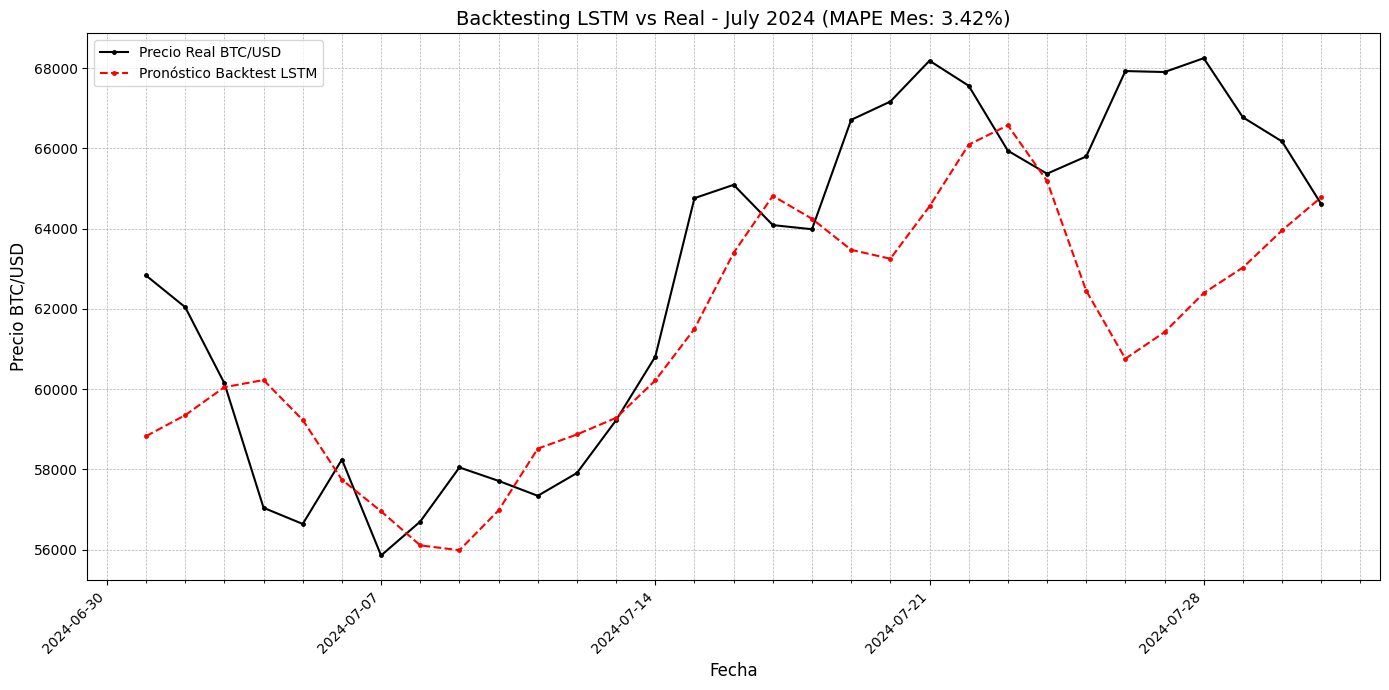



***** PROCESANDO PERIODO: August 2024 (2024-08-01 a 2024-08-31) *****
Realizando predicciones (1-paso) para 31 días...

Análisis Semanal para August 2024:
  - Semana 1: MAPE = 5.80% (7 días)
  - Semana 2: MAPE = 4.35% (7 días)
  - Semana 3: MAPE = 1.64% (7 días)
  - Semana 4: MAPE = 4.46% (7 días)
  - Semana 5: MAPE = 0.78% (3 días)
  >> Mejor resultado en: Semana 5 (MAPE: 0.78%)

Resultados Completos - August 2024:


Pronostico_USD  Real_USD
2024-08-01    66764.847408  65288.18
2024-08-02    66909.553588  61418.06
2024-08-03    64555.602730  60674.93
2024-08-04    61763.410850  58130.95
2024-08-05    60452.541641  54029.12
2024-08-06    57826.195556  56048.08
2024-08-07    56087.547375  55148.10
2024-08-08    54721.487253  61705.58
2024-08-09    56703.764008  60862.13
2024-08-10    58418.662718  60935.02
2024-08-11    59309.638728  58722.49
2024-08-12    58325.023983  59358.78
2024-08-13    57645.673543  60603.19
2024-08-14    58374.667856  58690.62
2024-08-15    58333.445319  57543.61
2024-08-16    58614.733720  58888.99
2024-08-17    58720.859515  59497.49
2024-08-18    58800.194059  58437.90
2024-08-19    58452.784525  59452.67
2024-08-20    58352.470105  59017.59
2024-08-21    58155.529270  61163.28
2024-08-22    58523.545894  60383.29
2024-08-23    58484.811010  64086.72
2024-08-24    60279.976174  64179.63
2024-08-25    62003.359731  64251.93
2024-08-26    62943.536864  62840.00
2024-08-27    62876.104981  59439.64
2024-08-28    61332.878058  59045.88
2024-08-29    59301.353204  59364.47
2024-08-30    58467.226673  59112.77
2024-08-31    58301.620756  58968.37


Generando gráfica para August 2024...


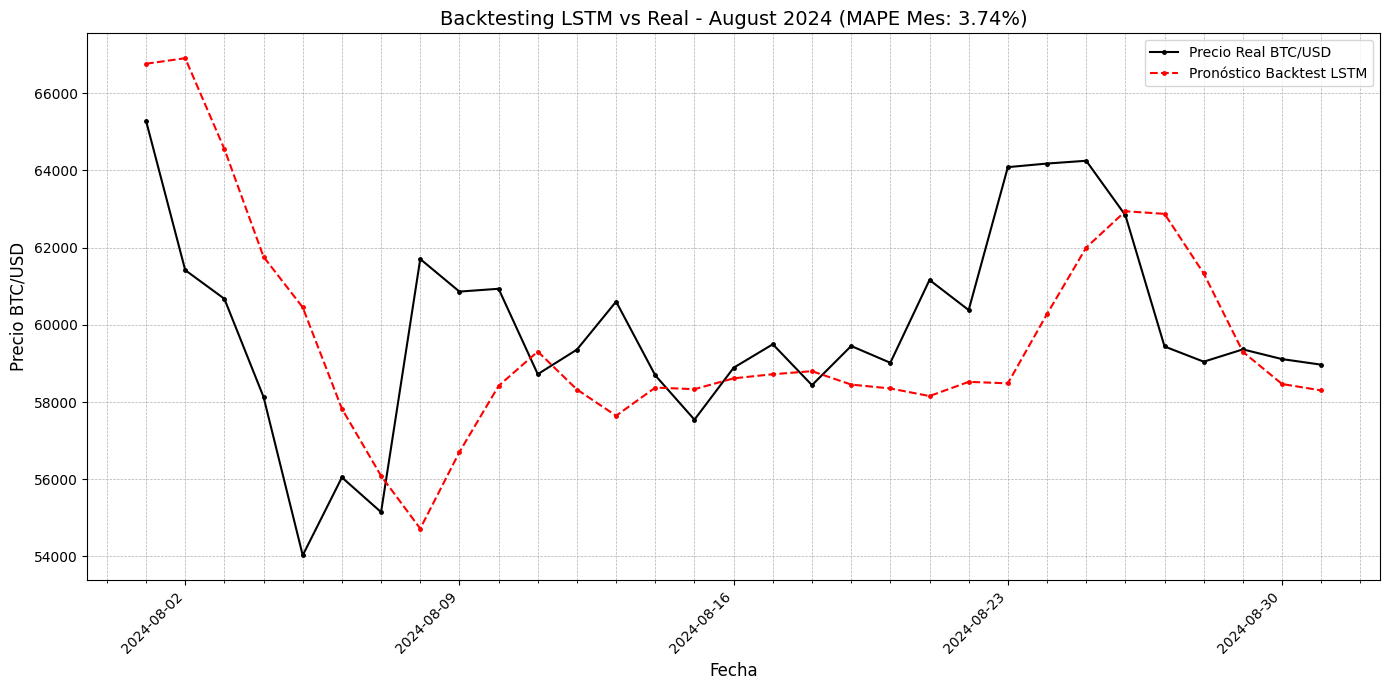



***** PROCESANDO PERIODO: September 2024 (2024-09-01 a 2024-09-30) *****
Realizando predicciones (1-paso) para 30 días...

Análisis Semanal para September 2024:
  - Semana 1: MAPE = 2.20% (7 días)
  - Semana 2: MAPE = 3.43% (7 días)
  - Semana 3: MAPE = 3.06% (7 días)
  - Semana 4: MAPE = 1.55% (7 días)
  - Semana 5: MAPE = 2.04% (2 días)
  >> Mejor resultado en: Semana 4 (MAPE: 1.55%)

Resultados Completos - September 2024:


Pronostico_USD  Real_USD
2024-09-01    56917.100109  57299.00
2024-09-02    55915.910462  59139.83
2024-09-03    56159.507535  57468.84
2024-09-04    56349.754683  57971.00
2024-09-05    56320.523604  56156.82
2024-09-06    55985.968465  53950.01
2024-09-07    54078.068261  54156.33
2024-09-08    53531.105546  54881.11
2024-09-09    53693.120015  57053.90
2024-09-10    54537.453239  57645.59
2024-09-11    55532.957316  57352.79
2024-09-12    56854.963585  58137.54
2024-09-13    58181.419251  60543.35
2024-09-14    59437.371684  60012.35
2024-09-15    59861.442574  59122.33
2024-09-16    59518.021459  58208.75
2024-09-17    58777.628774  60312.60
2024-09-18    58807.174591  61769.18
2024-09-19    59228.286638  62960.14
2024-09-20    60762.654320  63210.69
2024-09-21    62864.882527  63362.74
2024-09-22    63768.462480  63577.66
2024-09-23    63839.960859  63338.87
2024-09-24    63461.479148  64272.93
2024-09-25    63812.520722  63130.89
2024-09-26    63656.184760  65177.21
2024-09-27    63959.072937  65789.00
2024-09-28    64332.322013  65858.99
2024-09-29    64868.976050  65600.01
2024-09-30    65180.638609  63301.25


Generando gráfica para September 2024...


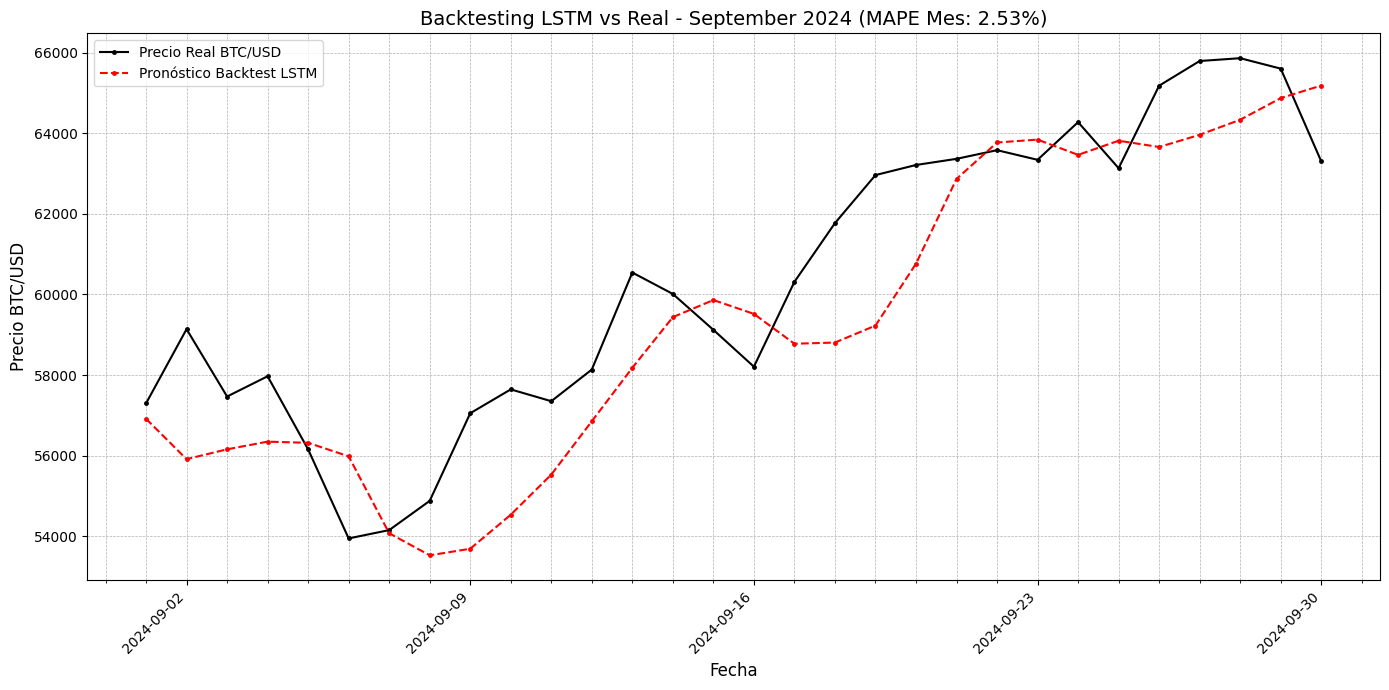



***** PROCESANDO PERIODO: October 2024 (2024-10-01 a 2024-10-31) *****
Realizando predicciones (1-paso) para 31 días...

Análisis Semanal para October 2024:
  - Semana 1: MAPE = 2.16% (7 días)
  - Semana 2: MAPE = 2.15% (7 días)
  - Semana 3: MAPE = 3.44% (7 días)
  - Semana 4: MAPE = 1.42% (7 días)
  - Semana 5: MAPE = 3.43% (3 días)
  >> Mejor resultado en: Semana 4 (MAPE: 1.42%)

Resultados Completos - October 2024:


Pronostico_USD  Real_USD
2024-10-01    64648.533375  60790.00
2024-10-02    63047.238401  60631.37
2024-10-03    61708.977194  60744.99
2024-10-04    61246.446335  62090.71
2024-10-05    61844.330641  62051.29
2024-10-06    62003.667167  62810.86
2024-10-07    62066.180665  62200.28
2024-10-08    62222.949002  62122.02
2024-10-09    62718.148363  60578.28
2024-10-10    62995.733770  60279.53
2024-10-11    63202.853061  62518.75
2024-10-12    64009.610219  63187.47
2024-10-13    64648.910495  62845.30
2024-10-14    65008.321686  66065.65
2024-10-15    65555.452145  67056.60
2024-10-16    65251.398428  67608.44
2024-10-17    65222.324351  67402.33
2024-10-18    65343.196109  68426.11
2024-10-19    65663.265379  68363.73
2024-10-20    65908.272030  69014.86
2024-10-21    65897.507823  67346.15
2024-10-22    65956.578822  67380.08
2024-10-23    66933.269012  66601.11
2024-10-24    66609.729090  68156.84
2024-10-25    67110.570930  66564.51
2024-10-26    67797.055217  67012.56
2024-10-27    67720.907767  67943.19
2024-10-28    68014.524694  69924.50
2024-10-29    68739.140262  72724.35
2024-10-30    70681.790634  72322.91
2024-10-31    71974.988670  70197.83


Generando gráfica para October 2024...


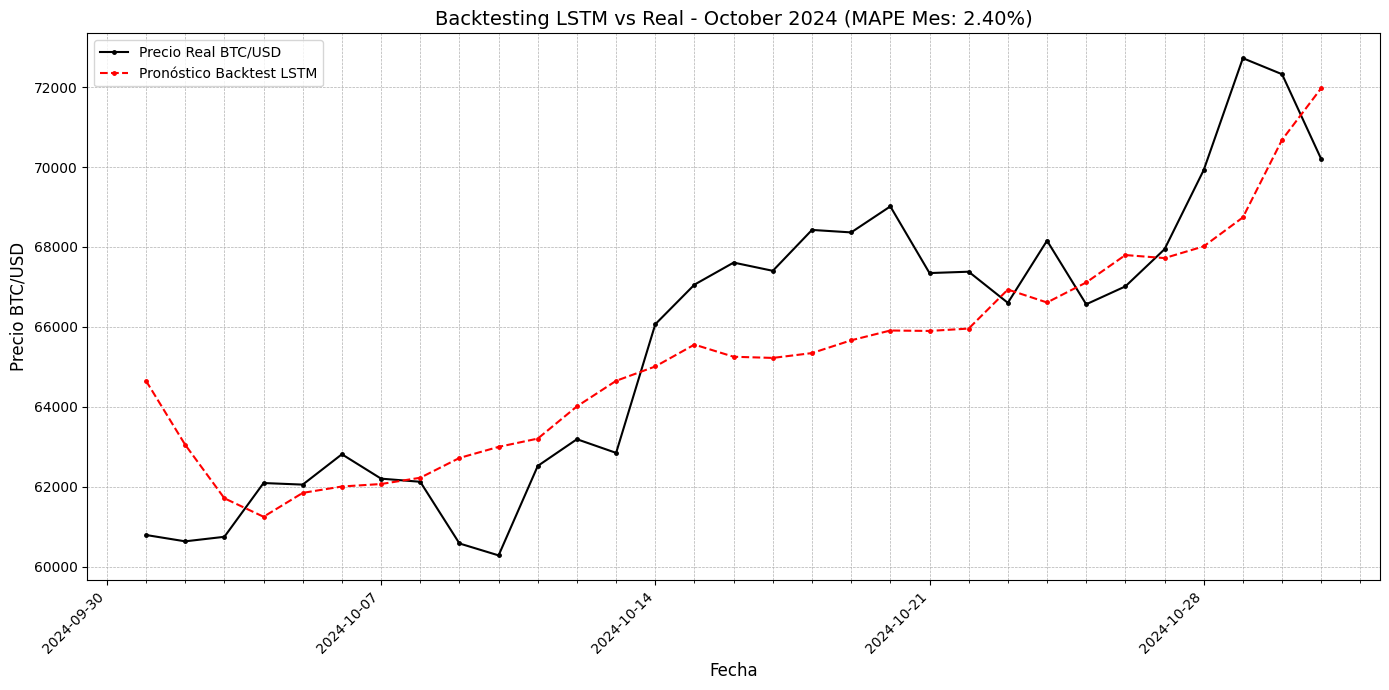



***** PROCESANDO PERIODO: November 2024 (2024-11-01 a 2024-11-30) *****
Realizando predicciones (1-paso) para 30 días...

Análisis Semanal para November 2024:
  - Semana 1: MAPE = 2.72% (7 días)
  - Semana 2: MAPE = 6.52% (7 días)
  - Semana 3: MAPE = 7.85% (7 días)
  - Semana 4: MAPE = 5.14% (7 días)
  - Semana 5: MAPE = 7.19% (2 días)
  >> Mejor resultado en: Semana 1 (MAPE: 2.72%)

Resultados Completos - November 2024:


Pronostico_USD  Real_USD
2024-11-01    70659.982639  69467.29
2024-11-02    69792.445743  69358.94
2024-11-03    69570.752525  68738.18
2024-11-04    69303.256683  67807.48
2024-11-05    68894.575519  69380.73
2024-11-06    69500.619556  75646.55
2024-11-07    72522.517644  75920.00
2024-11-08    75530.602071  76566.73
2024-11-09    76170.556806  76716.06
2024-11-10    75779.862187  80428.92
2024-11-11    76342.996633  88770.73
2024-11-12    79422.838559  88035.43
2024-11-13    81665.803300  90493.82
2024-11-14    83631.239191  87340.40
2024-11-15    83751.605630  91058.36
2024-11-16    83081.294750  90636.24
2024-11-17    84166.508572  89886.69
2024-11-18    84976.190064  90520.30
2024-11-19    85434.828250  92435.89
2024-11-20    86724.284013  94393.15
2024-11-21    88177.235901  98439.09
2024-11-22    90753.233023  99024.03
2024-11-23    93167.797217  97778.77
2024-11-24    92677.701326  98028.18
2024-11-25    91921.926834  93000.01
2024-11-26    90324.220910  91929.54
2024-11-27    88992.555901  95951.19
2024-11-28    88658.581155  95665.53
2024-11-29    89420.485172  97490.56
2024-11-30    90578.092358  96465.42


Generando gráfica para November 2024...


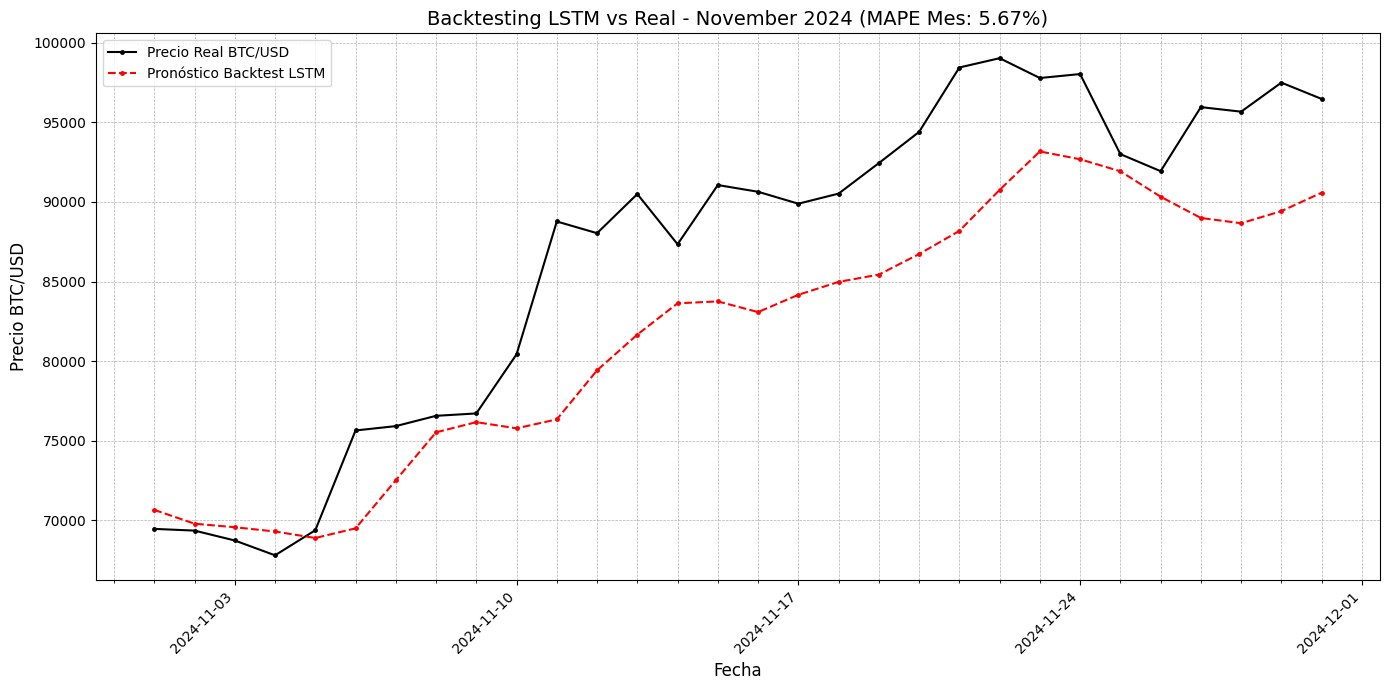



***** PROCESANDO PERIODO: December 2024 (2024-12-01 a 2024-12-31) *****
Realizando predicciones (1-paso) para 31 días...

Análisis Semanal para December 2024:
  - Semana 1: MAPE = 5.51% (7 días)
  - Semana 2: MAPE = 4.73% (7 días)
  - Semana 3: MAPE = 4.84% (7 días)
  - Semana 4: MAPE = 4.03% (7 días)
  - Semana 5: MAPE = 6.12% (3 días)
  >> Mejor resultado en: Semana 4 (MAPE: 4.03%)

Resultados Completos - December 2024:


Pronostico_USD   Real_USD
2024-12-01    91511.488844   97263.18
2024-12-02    91921.497864   95862.89
2024-12-03    92083.791509   95924.52
2024-12-04    92017.449445   98746.24
2024-12-05    92960.309688   97044.23
2024-12-06    92677.701326   99891.35
2024-12-07    93612.827364   99929.32
2024-12-08    94306.528973  101174.99
2024-12-09    95035.524482   97324.81
2024-12-10    94421.079475   96660.76
2024-12-11    93664.118160  101202.11
2024-12-12    95815.808799  100030.47
2024-12-13    96170.489317  101428.75
2024-12-14    96530.255427  101399.99
2024-12-15    97335.842202  104447.76
2024-12-16    98383.085938  106099.81
2024-12-17    99415.467895  106136.99
2024-12-18    99595.669420  100150.73
2024-12-19    95706.209645   97372.21
2024-12-20    92070.578350   97765.00
2024-12-21    92007.251345   97230.08
2024-12-22    92770.058748   95087.75
2024-12-23    92292.014476   94764.56
2024-12-24    91487.977077   98594.47
2024-12-25    92707.115902   99346.28
2024-12-26    93561.319056   95669.49
2024-12-27    92559.461401   94171.89
2024-12-28    90058.635736   95130.82
2024-12-29    88116.458270   93563.35
2024-12-30    87290.984429   92620.71
2024-12-31    87024.393008   93354.22


Generando gráfica para December 2024...


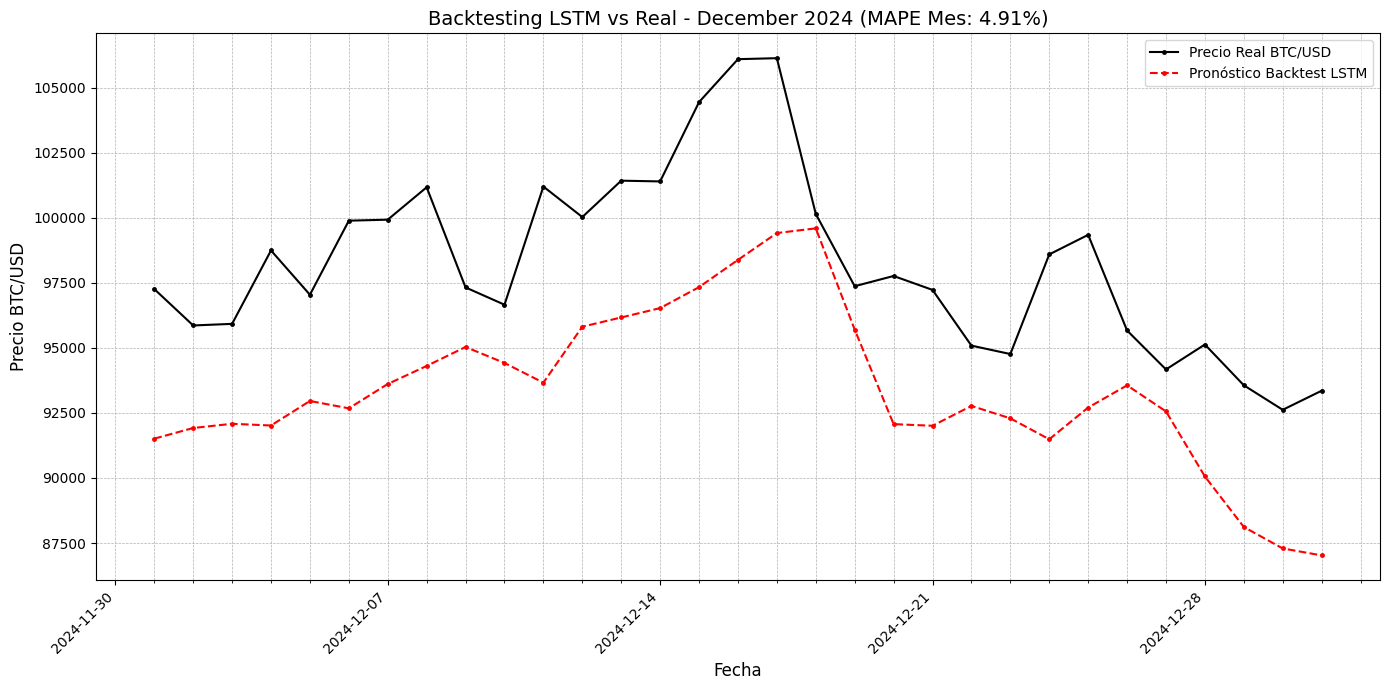



***** PROCESANDO PERIODO: January 2025 (2025-01-01 a 2025-01-31) *****
Realizando predicciones (1-paso) para 31 días...

Análisis Semanal para January 2025:
  - Semana 1: MAPE = 6.69% (7 días)
  - Semana 2: MAPE = 4.32% (7 días)
  - Semana 3: MAPE = 4.15% (7 días)
  - Semana 4: MAPE = 6.09% (7 días)
  - Semana 5: MAPE = 5.44% (3 días)
  >> Mejor resultado en: Semana 3 (MAPE: 4.15%)

Resultados Completos - January 2025:


Pronostico_USD   Real_USD
2025-01-01    87180.557801   94383.59
2025-01-02    88230.000372   96903.19
2025-01-03    89970.315983   98136.51
2025-01-04    92056.212534   98209.85
2025-01-05    93428.353001   98345.33
2025-01-06    93744.306039  102279.41
2025-01-07    94692.099883   96941.98
2025-01-08    93520.231012   95036.63
2025-01-09    91936.164435   92547.44
2025-01-10    90004.200148   94701.18
2025-01-11    89298.951485   94565.02
2025-01-12    89343.787372   94509.62
2025-01-13    89516.854711   94506.45
2025-01-14    90045.949539   96534.96
2025-01-15    91400.468222  100510.23
2025-01-16    95842.473425   99981.78
2025-01-17    98222.437769  104107.00
2025-01-18   100936.714015  104435.00
2025-01-19   102870.312823  101211.13
2025-01-20   102603.204280  102145.43
2025-01-21   101124.392024  106159.26
2025-01-22    99884.980320  103667.11
2025-01-23    99207.925906  103926.36
2025-01-24    98474.379156  104850.27
2025-01-25    97793.964315  104733.56
2025-01-26    95430.115658  102563.00
2025-01-27    94094.227548  102062.42
2025-01-28    94245.512364  101290.00
2025-01-29    96409.574838  103747.25
2025-01-30    97958.940154  104742.64
2025-01-31    99583.150122  102411.26


Generando gráfica para January 2025...


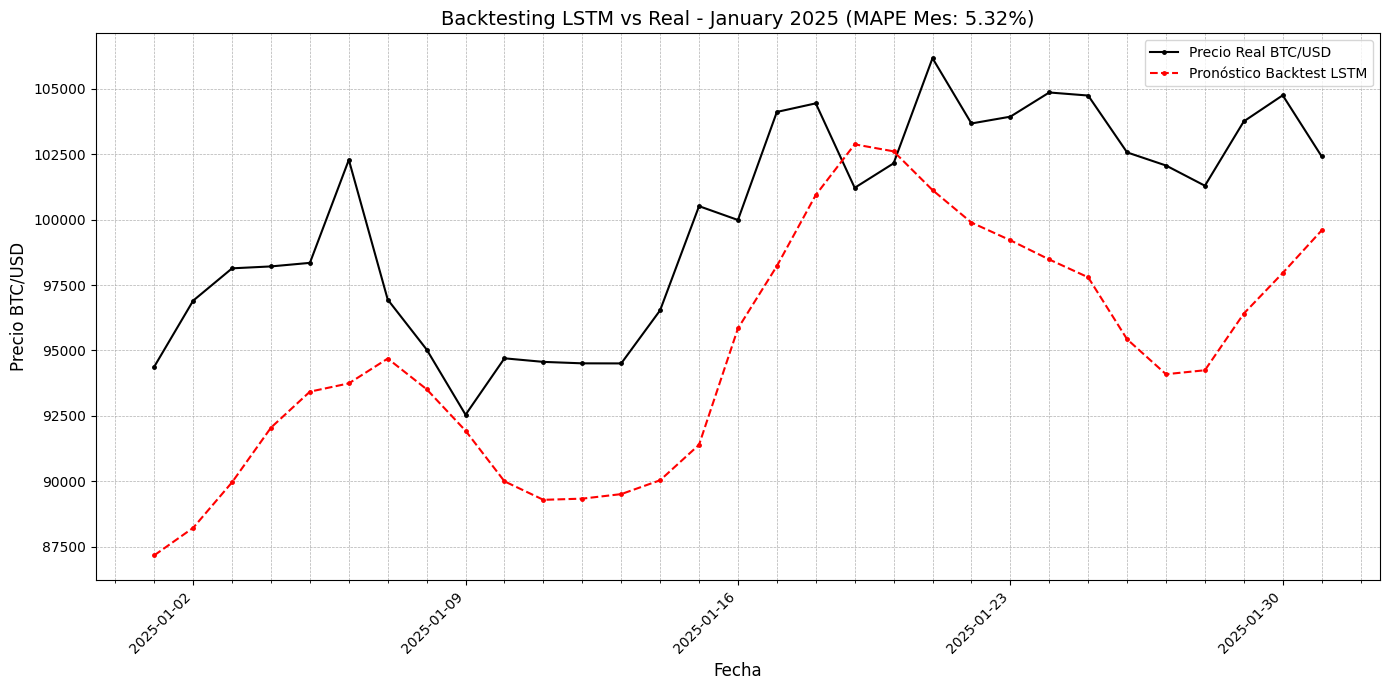



***** PROCESANDO PERIODO: February 2025 (2025-02-01 a 2025-02-28) *****
Realizando predicciones (1-paso) para 28 días...

Análisis Semanal para February 2025:
  - Semana 1: MAPE = 2.43% (7 días)
  - Semana 2: MAPE = 3.69% (7 días)
  - Semana 3: MAPE = 2.33% (7 días)
  - Semana 4: MAPE = 2.84% (7 días)
  >> Mejor resultado en: Semana 3 (MAPE: 2.33%)

Resultados Completos - February 2025:


Pronostico_USD   Real_USD
2025-02-01    99458.333755  100623.85
2025-02-02    97879.086700   97676.52
2025-02-03    95844.514106  101460.20
2025-02-04    95301.164625   97795.05
2025-02-05    94936.536550   96638.33
2025-02-06    94081.631447   96564.62
2025-02-07    93440.071282   96537.08
2025-02-08    92486.733936   96476.25
2025-02-09    93319.742749   96475.82
2025-02-10    93656.004806   97444.41
2025-02-11    93672.587393   95774.08
2025-02-12    93151.602853   97862.53
2025-02-13    93010.320604   96625.29
2025-02-14    93804.724557   97509.03
2025-02-15    94150.615075   97596.94
2025-02-16    95061.528339   96119.88
2025-02-17    94995.257498   95781.80
2025-02-18    94446.777470   95607.40
2025-02-19    93875.531286   96632.03
2025-02-20    93845.937592   98347.20
2025-02-21    94043.112663   96157.03
2025-02-22    92228.588966   96582.12
2025-02-23    91152.825664   96265.98
2025-02-24    91226.419948   91510.82
2025-02-25    90809.366479   88583.74
2025-02-26    88187.240974   84111.78
2025-02-27    85621.023645   84625.19
2025-02-28    83290.657730   84297.73


Generando gráfica para February 2025...


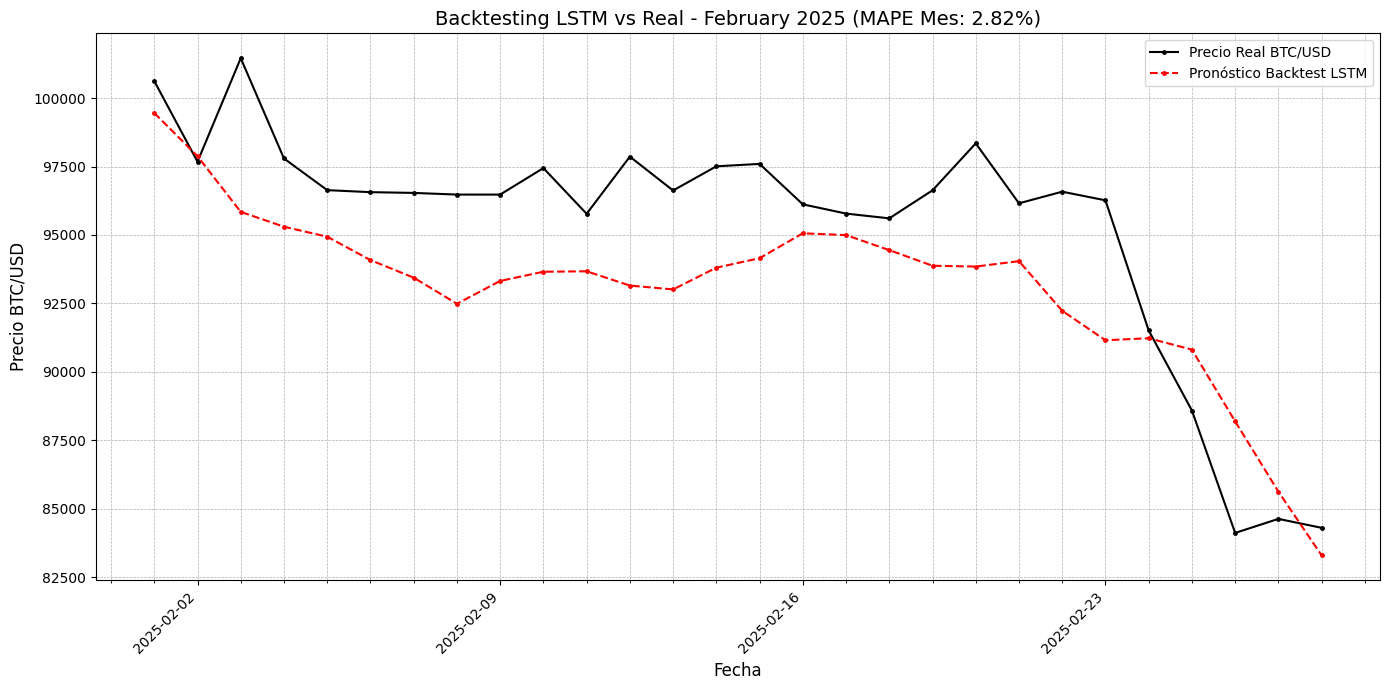



***** PROCESANDO PERIODO: March 2025 (2025-03-01 a 2025-03-31) *****
Realizando predicciones (1-paso) para 31 días...

Análisis Semanal para March 2025:
  - Semana 1: MAPE = 3.20% (7 días)
  - Semana 2: MAPE = 3.32% (7 días)
  - Semana 3: MAPE = 2.38% (7 días)
  - Semana 4: MAPE = 2.33% (7 días)
  - Semana 5: MAPE = 2.24% (3 días)
  >> Mejor resultado en: Semana 5 (MAPE: 2.24%)

Resultados Completos - March 2025:


Pronostico_USD  Real_USD
2025-03-01    83408.685062  86018.76
2025-03-02    83450.052384  94265.48
2025-03-03    86566.992350  86161.10
2025-03-04    87188.008471  87249.96
2025-03-05    86747.836616  90603.73
2025-03-06    87704.745439  89921.85
2025-03-07    87314.741870  86756.98
2025-03-08    87108.525125  86206.69
2025-03-09    84764.024178  80699.17
2025-03-10    82278.916571  78544.71
2025-03-11    79875.775934  82914.51
2025-03-12    79639.170749  83659.43
2025-03-13    81115.604163  81073.43
2025-03-14    80697.850685  83980.49
2025-03-15    81780.025395  84351.46
2025-03-16    82819.008393  82562.57
2025-03-17    82261.135850  84011.40
2025-03-18    82185.041333  82698.76
2025-03-19    81086.225172  86877.96
2025-03-20    82244.414441  84183.42
2025-03-21    82710.330815  84061.96
2025-03-22    82477.043631  83852.03
2025-03-23    83123.372496  86092.94
2025-03-24    83803.041739  87523.62
2025-03-25    84989.153544  87427.88
2025-03-26    86334.409822  86926.01
2025-03-27    86302.033092  87217.48
2025-03-28    86463.105158  84381.80
2025-03-29    84802.106144  82616.83
2025-03-30    84203.364268  82379.98
2025-03-31    84076.659153  82534.32


Generando gráfica para March 2025...


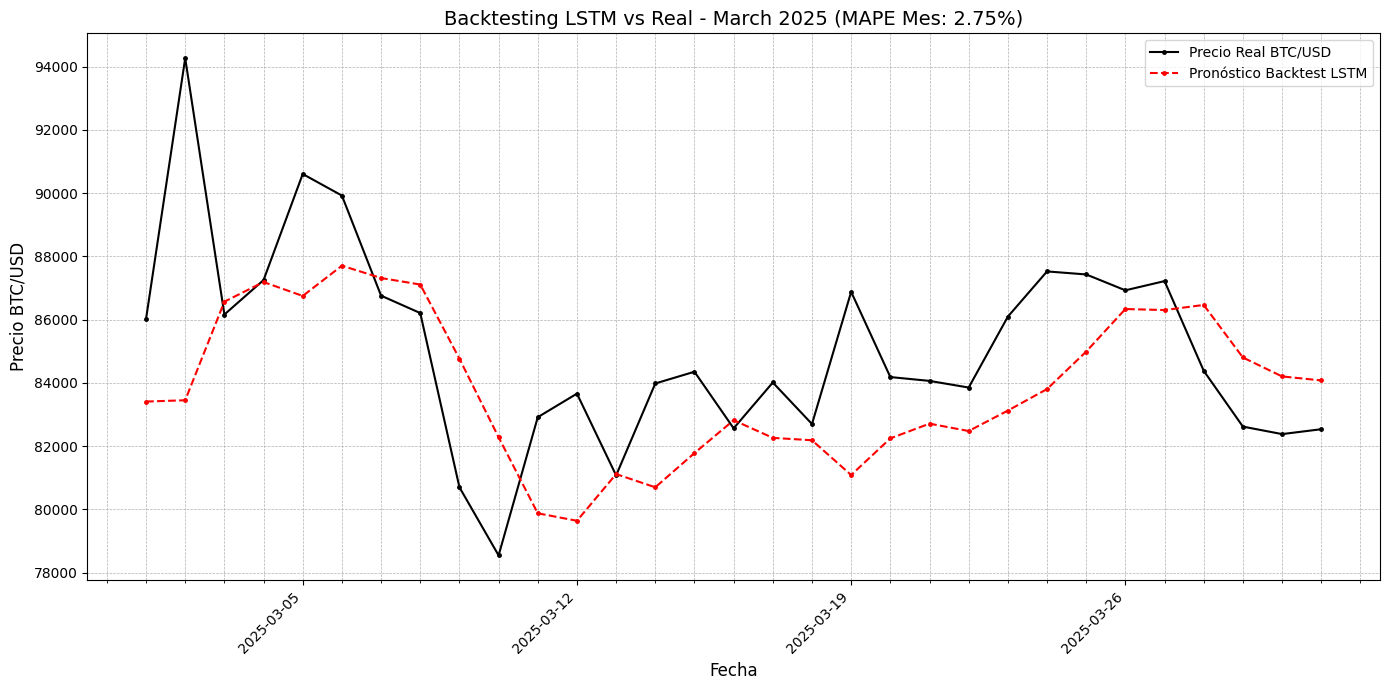



***** PROCESANDO PERIODO: April 2025 (2025-04-01 a 2025-04-30) *****
Realizando predicciones (1-paso) para 30 días...

Análisis Semanal para April 2025:
  - Semana 1: MAPE = 3.16% (7 días)
  - Semana 2: MAPE = 4.01% (7 días)
  - Semana 3: MAPE = 1.82% (7 días)
  - Semana 4: MAPE = 5.02% (7 días)
  - Semana 5: MAPE = 5.94% (2 días)
  >> Mejor resultado en: Semana 3 (MAPE: 1.82%)

Resultados Completos - April 2025:


Pronostico_USD  Real_USD
2025-04-01    84710.935814  85170.37
2025-04-02    86613.690092  82490.08
2025-04-03    87984.506478  83174.33
2025-04-04    84978.371161  83860.16
2025-04-05    80637.053935  83498.25
2025-04-06    80503.293206  78370.75
2025-04-07    81740.034269  79140.01
2025-04-08    81353.439863  76251.64
2025-04-09    79336.641549  82594.75
2025-04-10    85882.339046  79552.34
2025-04-11    86132.693993  83380.47
2025-04-12    86196.980544  85271.01
2025-04-13    86608.233567  83733.07
2025-04-14    86001.605751  84590.36
2025-04-15    86517.266373  83629.78
2025-04-16    86579.213663  84028.72
2025-04-17    85557.341329  84961.97
2025-04-18    85401.966874  84466.47
2025-04-19    84547.529892  85074.99
2025-04-20    84434.022877  85177.34
2025-04-21    84935.453491  87522.07
2025-04-22    85195.496540  93489.10
2025-04-23    87756.612873  93740.92
2025-04-24    89752.277512  94021.96
2025-04-25    91767.171657  94708.79
2025-04-26    92097.140874  94666.64
2025-04-27    90901.903518  93780.57
2025-04-28    88923.435106  95042.57
2025-04-29    88398.125598  94271.09
2025-04-30    88862.609675  94182.54


Generando gráfica para April 2025...


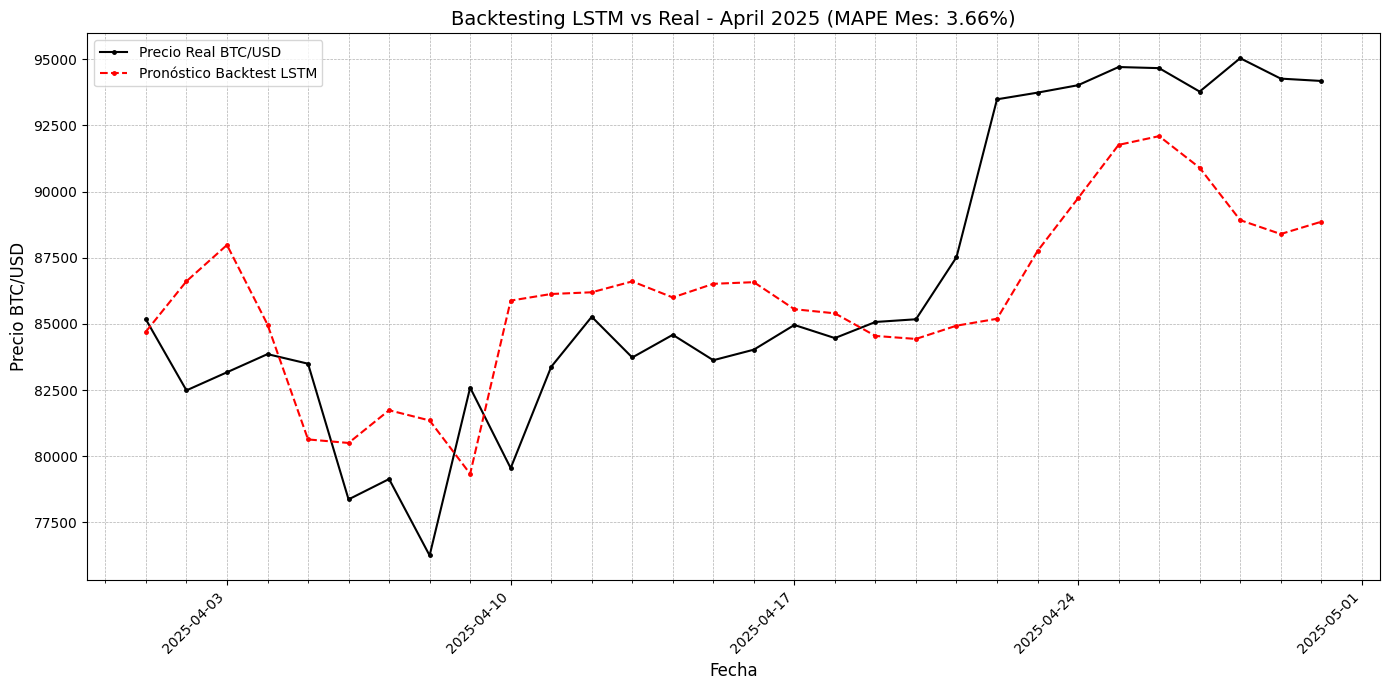


--- Resumen del Backtesting Semanal ---
Mejor semana encontrada por cada mes:


MejorSemana MAPESemanal
Periodo                               
January 2024      Semana 5       1.35%
February 2024     Semana 3       1.09%
March 2024        Semana 5       1.06%
April 2024        Semana 5       2.13%
May 2024          Semana 5       1.56%
June 2024         Semana 2       1.21%
July 2024         Semana 2       1.52%
August 2024       Semana 5       0.78%
September 2024    Semana 4       1.55%
October 2024      Semana 4       1.42%
November 2024     Semana 1       2.72%
December 2024     Semana 4       4.03%
January 2025      Semana 3       4.15%
February 2025     Semana 3       2.33%
March 2025        Semana 5       2.24%
April 2025        Semana 3       1.82%


--- Backtesting con Análisis Semanal Finalizado ---


In [ ]:
# --- Bloque 12: Backtesting MENSUAL con ANÁLISIS SEMANAL (Ene 2024 - Abr 2025) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display
import locale
import datetime

# --- (Intentar locale español como antes) ---
try: locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')
except locale.Error:
    try: locale.setlocale(locale.LC_TIME, 'Spanish')
    except locale.Error: print("Advertencia: Locale español no disponible.")

print("\n--- Iniciando Backtesting MENSUAL con Análisis SEMANAL (Ene 2024 - Abr 2025) ---")

# --- (Verificación de variables requeridas como antes) ---
required_vars = ['best_model', 'scaler', 'scaled_data', 'date_index',
                 'n_steps', 'n_features', #'inverse_scale_column', # Se redefine abajo
                 'combined_data_final', 'log_btc_col', 'hist_btc_usd']
variables_exist = True
for var_name in required_vars:
    if var_name not in locals() and var_name not in globals(): print(f"Error: Variable '{var_name}' no encontrada."); variables_exist = False
if not variables_exist: print("Asegúrate de haber ejecutado los bloques anteriores (1-11).")
# --- Fin Verificación ---

else:
    # --- (Reconstrucción de all_X y target_dates como antes) ---
    print("Reconstruyendo secuencias X y fechas objetivo...")
    all_X = []; target_dates_list = []
    if 'scaled_data' in locals() or 'scaled_data' in globals():
        if hasattr(scaled_data, '__len__') and len(scaled_data) > n_steps:
             for i in range(n_steps, len(scaled_data)): all_X.append(scaled_data[i-n_steps:i, :]); target_dates_list.append(date_index[i])
             all_X = np.array(all_X); target_dates = pd.Series(target_dates_list, name="TargetDate"); target_dates = pd.to_datetime(target_dates)
        else: print(f"Error: Datos insuficientes ({len(scaled_data)})."); exit()
    else: print("Error: 'scaled_data' no definida."); exit()
    if len(all_X) == 0: print("Error: No se reconstruyeron secuencias X."); exit()
    # --- Fin Reconstrucción ---

    # --- (Preparación hist_btc_usd como antes) ---
    print("Preparando datos históricos reales (USD)...")
    try:
        if 'hist_btc_usd' not in locals() or not isinstance(hist_btc_usd.index, pd.DatetimeIndex):
             if 'combined_data_final' in locals() and log_btc_col in combined_data_final.columns: hist_btc_usd = np.exp(combined_data_final[log_btc_col]); hist_btc_usd.index = pd.to_datetime(hist_btc_usd.index)
             else: raise ValueError("No se pudo crear hist_btc_usd")
        print("  Histórico USD listo.")
    except Exception as e: print(f"Error prep hist USD: {e}"); exit()
    # --- Fin Preparación hist_btc_usd ---

    # --- GENERAR PERIODOS MENSUALES (Ene 2024 - Abr 2025) ---
    print("Generando periodos mensuales para backtesting...")
    backtest_periods = {}
    bt_start_overall = pd.to_datetime('2024-01-01'); bt_end_overall = pd.to_datetime('2025-04-30')
    current_month_start = bt_start_overall.replace(day=1)
    while current_month_start <= bt_end_overall:
        start_of_month = current_month_start; end_of_month = start_of_month + pd.offsets.MonthEnd(0)
        if end_of_month > bt_end_overall: end_of_month = bt_end_overall
        if start_of_month > bt_end_overall: break
        # Usar formato con nombre de mes (requiere locale español configurado)
        try: period_name = start_of_month.strftime('%B %Y').capitalize()
        except: period_name = start_of_month.strftime('%Y-%m') # Fallback si locale falla
        backtest_periods[period_name] = (start_of_month.strftime('%Y-%m-%d'), end_of_month.strftime('%Y-%m-%d'))
        current_month_start = (end_of_month + pd.DateOffset(days=1)).replace(day=1)
    print(f"Periodos generados: {len(backtest_periods)}")
    if not backtest_periods: print("Error: No se generaron periodos."); exit()
    # --- FIN GENERAR PERIODOS ---

    # --- Variables para almacenar resumen ---
    results_summary = [] # Lista para guardar mejor semana de cada mes

    # --- Bucle principal sobre los periodos mensuales ---
    for period_name, (start_bt, end_bt) in backtest_periods.items():
        print(f"\n\n***** PROCESANDO PERIODO: {period_name} ({start_bt} a {end_bt}) *****")
        start_bt_dt = pd.to_datetime(start_bt); end_bt_dt = pd.to_datetime(end_bt)

        # Encontrar índices para este mes
        period_mask = (target_dates >= start_bt_dt) & (target_dates <= end_bt_dt)
        selected_indices = target_dates[period_mask].index.to_numpy()

        if len(selected_indices) == 0: print(f"No data in range for {period_name}."); continue

        X_backtest = all_X[selected_indices]
        dates_backtest = target_dates.iloc[selected_indices].values

        if X_backtest.shape[0] == 0: print(f"No input sequences for {period_name}"); continue

        print(f"Realizando predicciones (1-paso) para {len(dates_backtest)} días...")
        # Usar predicción estándar (no iterativa)
        preds_scaled_log = best_model.predict(X_backtest, verbose=0)

        # Redefinir función inverse_scale_column
        def inverse_scale_column(scaler_obj, data_scaled, column_index, n_total_features):
             data_scaled_np = np.array(data_scaled).flatten(); temp_array = np.zeros((len(data_scaled_np), n_total_features))
             temp_array[:, column_index] = data_scaled_np; return scaler_obj.inverse_transform(temp_array)[:, column_index]

        preds_log = inverse_scale_column(scaler, preds_scaled_log, 0, n_features)
        preds_usd = np.exp(preds_log)

        # Obtener y alinear valores reales
        try:
            dates_present_in_hist = pd.to_datetime(dates_backtest)[pd.to_datetime(dates_backtest).isin(hist_btc_usd.index)]
            if len(dates_present_in_hist) == 0: print(f"Error: Fechas backtest no en hist_btc_usd."); continue
            actuals_usd_series = hist_btc_usd.loc[dates_present_in_hist]
            df_compare = pd.DataFrame(index=dates_present_in_hist)
            preds_series = pd.Series(preds_usd, index=pd.to_datetime(dates_backtest))
            df_compare['Pronostico_USD'] = preds_series.reindex(dates_present_in_hist)
            df_compare['Real_USD'] = actuals_usd_series
            df_compare.dropna(inplace=True)
        except Exception as e: print(f"Error inesperado al obtener/alinear reales: {e}"); continue

        if df_compare.empty: print("No se pudieron generar resultados comparativos."); continue

        # --- *** ANÁLISIS SEMANAL DENTRO DEL MES *** ---
        print(f"\nAnálisis Semanal para {period_name}:")
        # Añadir columna de semana DENTRO del mes (Semana 1 = días 1-7, etc.)
        df_compare['SemanaDelMes'] = (df_compare.index.day - 1) // 7 + 1
        weekly_mapes = {}
        best_week_info = {'week': 'N/A', 'mape': np.nan} # Para guardar la mejor semana
        try:
            for week_num, week_df in df_compare.groupby('SemanaDelMes'):
                if week_df.empty: continue # Saltar semanas vacías si las hubiera
                y_true_w = week_df['Real_USD']
                y_pred_w = week_df['Pronostico_USD']
                zero_mask_w = y_true_w != 0
                mape_w = np.nan
                if zero_mask_w.sum() > 0:
                    # Calcular MAPE para la semana
                    mape_w = np.mean(np.abs((y_true_w[zero_mask_w] - y_pred_w[zero_mask_w]) / y_true_w[zero_mask_w])) * 100
                    weekly_mapes[f"Semana {week_num}"] = mape_w
                    print(f"  - Semana {week_num}: MAPE = {mape_w:.2f}% ({len(week_df)} días)")
                else:
                     print(f"  - Semana {week_num}: No se pudo calcular MAPE.")

            # Encontrar la mejor semana (menor MAPE)
            if weekly_mapes:
                 # Filtrar NaNs antes de encontrar el mínimo
                 valid_weekly_mapes = {k:v for k, v in weekly_mapes.items() if not np.isnan(v)}
                 if valid_weekly_mapes:
                      best_week = min(valid_weekly_mapes, key=valid_weekly_mapes.get)
                      best_mape = valid_weekly_mapes[best_week]
                      print(f"  >> Mejor resultado en: {best_week} (MAPE: {best_mape:.2f}%)")
                      best_week_info = {'week': best_week, 'mape': best_mape} # Guardar info
                 else:
                      print("  No se calcularon MAPEs semanales válidos.")
            else:
                 print("  No se calcularon MAPEs semanales.")

        except Exception as e_week:
             print(f"Error durante análisis semanal: {e_week}")
        # Añadir resultado al resumen general
        results_summary.append({
            'Periodo': period_name,
            'MejorSemana': best_week_info['week'],
            'MAPESemanal': best_week_info['mape']
        })
        # --- *** FIN ANÁLISIS SEMANAL *** ---

        # Mostrar tabla mensual completa
        print(f"\nResultados Completos - {period_name}:")
        # Quitar columna auxiliar antes de mostrar
        display(df_compare.drop(columns=['SemanaDelMes'], errors='ignore'))

        # Generar Gráfica Mensual
        print(f"\nGenerando gráfica para {period_name}...")
        fig_bt, ax_bt = plt.subplots(figsize=(14, 7))
        ax_bt.plot(df_compare.index, df_compare['Real_USD'], label='Precio Real BTC/USD', color='black', marker='.', markersize=5, linestyle='-')
        ax_bt.plot(df_compare.index, df_compare['Pronostico_USD'], label='Pronóstico Backtest LSTM', color='red', marker='.', markersize=5, linestyle='--')
        # Calcular MAPE mensual total para título
        y_true_m = df_compare['Real_USD']; y_pred_m = df_compare['Pronostico_USD']
        zero_mask_m = y_true_m != 0; mape_m = np.nan
        if zero_mask_m.sum() > 0: mape_m = np.mean(np.abs((y_true_m[zero_mask_m] - y_pred_m[zero_mask_m]) / y_true_m[zero_mask_m])) * 100
        ax_bt.set_title(f'Backtesting LSTM vs Real - {period_name} (MAPE Mes: {mape_m:.2f}%)' if not np.isnan(mape_m) else f'Backtesting LSTM vs Real - {period_name}', fontsize=14)
        ax_bt.set_ylabel('Precio BTC/USD', fontsize=12); ax_bt.set_xlabel('Fecha', fontsize=12)
        ax_bt.legend(); ax_bt.grid(True, which="both", ls="--", linewidth=0.5)
        ax_bt.xaxis.set_major_locator(mdates.DayLocator(interval=7)); ax_bt.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) # Marcas semanales
        ax_bt.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

    # --- FIN DEL BUCLE for period_name... ---

    # --- Mostrar Resumen Final Semanal ---
    print("\n--- Resumen del Backtesting Semanal ---")
    if 'results_summary' in locals() and results_summary:
        summary_df = pd.DataFrame(results_summary).set_index('Periodo')
        print("Mejor semana encontrada por cada mes:")
        # Formatear MAPE en el resumen
        summary_df['MAPESemanal'] = summary_df['MAPESemanal'].map('{:.2f}%'.format).replace('nan%','N/A')
        display(summary_df)
    else:
        print("No se generó resumen semanal (o lista 'results_summary' no inicializada).")

print("\n--- Backtesting con Análisis Semanal Finalizado ---")